In [2]:
import sys
sys.path.append('../code')
from resnet import *
from funcs import *
from fashionmnist_net import *
from fashionmnist_dataset import *    
import torch as t 
import numpy as np
from numpy import polyfit
from numpy import polyval
import tqdm
import matplotlib.pylab as plt
import matplotlib.cm as cm
import json
import hyperparams
from importlib import reload
from scipy.interpolate import interp1d
from PIL import Image
%matplotlib inline
plt.rcParams['figure.figsize']=(12,9)
plt.rcParams['font.size']= 20

# Dataset loading

In [3]:
# добавил в загрузку валидационную выборку
# обрати внимание, maxsize --- это размер совокпного обучения и валидации
# поэтому размер обучающей выборки совпадает с тем, что было до этого

#train_loader_no_augumentation, valid_loader, test_loader  = cifar10_loader(batch_size=128, split_train_val=True, use_aug = True)
train_loader_no_augumentation,  test_loader  = fashionmnist_loader(batch_size=128, split_train_val=False, use_aug = False)


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Experiments

In [4]:
epoch_num = 50
# epoch_num = 50

run_num = 10 # количество запусков эксперимента

# версия нужна, чтобы различать старые и новые результаты экспериментов. 
# менять нужно каждый раз, когда есть хотя бы незначительные изменения в эксперименте
experiment_version = '4_full_fmnist_'

validate_every_epoch = 5

# train_splines_every_epoch = 5 # каждые 5 эпох отслеживать траекторию гиперпараметров
train_splines_every_epoch = 2
# train_splines_every_epoch = 3
# train_splines_every_epoch = 10

# размер мини-эпохи в батчах, за которую у нас производится либо обучение спайлов, либо их использование
mini_epoch_size = 10

start_beta = 0.5
start_temp  = 1.0

### without distillation

In [ ]:
# запуск без дистилляции
filename='nodistil'
cifar_base(experiment_version, run_num, epoch_num, start_beta, start_temp, filename, 
           tr_load=train_loader_no_augumentation, t_load=test_loader, 
           validate_every_epoch=validate_every_epoch, lr0=1.0, student_class=FashionMNIST_Net)

current loss:0.8978023529052734:  26%|██▋       | 124/469 [00:07<00:20, 16.91it/s]

### with distillation and start_lambda1, start_temp

In [9]:
# Запуск --- с CNN-дистилляцией
filename='distil'
cifar_base(experiment_version, run_num, epoch_num, start_beta, start_temp, filename, 
           tr_load=train_loader_no_augumentation, t_load=test_loader, 
           validate_every_epoch=validate_every_epoch, mode='distil', logits='../code/logits_resnet_fmnist.npy', student_class=FashionMNIST_Net)

current loss:0.20565438270568848:   1%|          | 5/469 [00:00<00:10, 44.17it/s]

{'epoch': 0, 'test loss': 0.448363333940506, 'accuracy': 0.8258999586105347}


current loss:0.21711528301239014:  33%|███▎      | 156/469 [00:03<00:07, 44.50it/s]


KeyboardInterrupt: 

### with random metaparameter values

In [ ]:
# Запуск --- со случаными значениями гиперпараметров
filename='random'
cifar_base(experiment_version, run_num, epoch_num, start_beta, start_temp, filename, 
           tr_load=train_loader_no_augumentation, t_load=test_loader, 
           validate_every_epoch=validate_every_epoch, mode='random', lr0=1.0, logits='../code/logits_resnet_fmnist.npy', student_class=FashionMNIST_Net)

### with distillation and 2 coefficients

In [ ]:
train_loader_no_augumentation, valid_loader, test_loader  = fashionmnist_loader(batch_size=128, split_train_val=True, use_aug = False)

In [6]:
np.random.seed(2)
torch.manual_seed(2)
lambda1 = t.nn.Parameter(t.tensor(np.random.uniform(low=0.0, high=1.0), device=device), requires_grad=True)
#lambda2 = t.nn.Parameter(t.tensor(np.random.uniform(low=0.0, high=1.0), device=device), requires_grad=True)
temp = t.nn.Parameter(t.tensor(np.random.uniform(low=0.1, high=10.0), device=device), requires_grad=True)
lambda1, temp

(Parameter containing:
 tensor(0.4360, device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor(0.3567, device='cuda:0', requires_grad=True))

In [ ]:
# Запуск --- с CNN-дистилляцией и оптимизацией гиперпараметров, 2-lambda
filename='opt'
cifar_with_validation_set(experiment_version, run_num, epoch_num, filename,
                          tr_s_epoch=train_splines_every_epoch,
                          m_e=mini_epoch_size,
                          tr_load=train_loader_no_augumentation, 
                          t_load=test_loader, 
                          val_load=valid_loader, 
                          validate_every_epoch=validate_every_epoch,  
                          mode='opt', lr0=1.0, lr=0.1, logits='../code/logits_resnet_fmnist.npy', student_class=FashionMNIST_Net)

### with linear models

In [13]:
# Запуск --- с CNN-дистилляцией и оптимизацией гиперпараметров, 2-lambda (с линейными моделями)
filename='splines'
cifar_with_validation_set(experiment_version, run_num, epoch_num, filename,
                          tr_s_epoch=train_splines_every_epoch,
                          m_e=mini_epoch_size,
                          tr_load=train_loader_no_augumentation, 
                          t_load=test_loader, 
                          val_load=valid_loader, 
                          validate_every_epoch=validate_every_epoch, 
                          mode='splines', lr=.1, lr0=1.0, logits='../code/logits_resnet_fmnist.npy', student_class=FashionMNIST_Net)

current loss:0.2647959291934967:   0%|          | 2/422 [00:00<00:21, 19.81it/s]

{'epoch': 0, 'test loss': 0.4543266296386719, 'val loss': 0.43912094831466675, 'accuracy': 0.8317999839782715, 'temp': 9.51207160949707, 'lambda1': 0.4136652648448944}


current loss:0.10941145569086075:   0%|          | 2/422 [00:00<00:21, 19.17it/s]

{'epoch': 4, 'test loss': 0.38848915696144104, 'val loss': 0.36282649636268616, 'accuracy': 0.861299991607666, 'temp': 9.51207160949707, 'lambda1': 0.5441387295722961}


current loss:0.05478234216570854:   0%|          | 2/422 [00:00<00:21, 19.28it/s] 

{'epoch': 9, 'test loss': 0.38504329323768616, 'val loss': 0.35225149989128113, 'accuracy': 0.8695999979972839, 'temp': 9.51207160949707, 'lambda1': 0.6714253425598145}


current loss:0.0256127268075943:   0%|          | 2/422 [00:00<00:22, 18.53it/s]  

{'epoch': 14, 'test loss': 0.3721817433834076, 'val loss': 0.33539649844169617, 'accuracy': 0.880899965763092, 'temp': 9.51207160949707, 'lambda1': 0.8130660653114319}


current loss:0.009905426762998104:   0%|          | 2/422 [00:00<00:22, 18.91it/s]

{'epoch': 19, 'test loss': 0.39193475246429443, 'val loss': 0.3419494926929474, 'accuracy': 0.8822000026702881, 'temp': 9.51207160949707, 'lambda1': 0.9123390316963196}


current loss:0.003433711128309369:   0%|          | 2/422 [00:00<00:21, 19.15it/s]

{'epoch': 24, 'test loss': 0.38606569170951843, 'val loss': 0.3415396213531494, 'accuracy': 0.8830999732017517, 'temp': 9.51207160949707, 'lambda1': 0.9664357900619507}


current loss:0.0006245511467568576:   0%|          | 2/422 [00:00<00:22, 18.50it/s]

{'epoch': 29, 'test loss': 0.3860897123813629, 'val loss': 0.34302473068237305, 'accuracy': 0.8842999935150146, 'temp': 9.51207160949707, 'lambda1': 0.9937738180160522}


current loss:0.0006271894089877605:   0%|          | 2/422 [00:00<00:21, 19.52it/s]

{'epoch': 34, 'test loss': 0.3939568102359772, 'val loss': 0.3434199392795563, 'accuracy': 0.8841999769210815, 'temp': 9.51207160949707, 'lambda1': 0.9935241341590881}


current loss:0.5734738111495972:   0%|          | 2/422 [00:00<00:22, 18.51it/s]

{'epoch': 39, 'test loss': 0.39016011357307434, 'val loss': 0.3437049686908722, 'accuracy': 0.8841999769210815, 'temp': 9.51207160949707, 'lambda1': 0.9951409101486206}


current loss:0.0957842767238617:   1%|          | 3/422 [00:00<00:20, 20.52it/s] 

{'epoch': 0, 'test loss': 0.4488072097301483, 'val loss': 0.425255686044693, 'accuracy': 0.8420000076293945, 'temp': 6.026719093322754, 'lambda1': 0.7668365240097046}


current loss:0.027020791545510292:   0%|          | 2/422 [00:00<00:21, 19.14it/s]

{'epoch': 4, 'test loss': 0.3582390546798706, 'val loss': 0.32948213815689087, 'accuracy': 0.8680999875068665, 'temp': 6.026719093322754, 'lambda1': 0.8785707950592041}


current loss:0.0071374960243701935:   0%|          | 2/422 [00:00<00:23, 18.23it/s]

{'epoch': 9, 'test loss': 0.3465322256088257, 'val loss': 0.3242572247982025, 'accuracy': 0.8751999735832214, 'temp': 6.026719093322754, 'lambda1': 0.9606935381889343}


current loss:0.0005192749085836112:   0%|          | 2/422 [00:00<00:21, 19.15it/s]

{'epoch': 14, 'test loss': 0.33269965648651123, 'val loss': 0.31160005927085876, 'accuracy': 0.8819999694824219, 'temp': 6.026719093322754, 'lambda1': 0.9969038367271423}


current loss:5.7204615586670116e-05:   0%|          | 2/422 [00:00<00:21, 19.98it/s]

{'epoch': 19, 'test loss': 0.3346054255962372, 'val loss': 0.3113217353820801, 'accuracy': 0.8830999732017517, 'temp': 6.026719093322754, 'lambda1': 0.9997414350509644}


current loss:6.287376891123131e-05:   1%|          | 3/422 [00:00<00:20, 19.99it/s]

{'epoch': 24, 'test loss': 0.32895541191101074, 'val loss': 0.31179654598236084, 'accuracy': 0.8826999664306641, 'temp': 6.026719093322754, 'lambda1': 0.9997270703315735}


current loss:0.0004602534172590822:   0%|          | 2/422 [00:00<00:22, 19.05it/s]

{'epoch': 29, 'test loss': 0.328774631023407, 'val loss': 0.3119756877422333, 'accuracy': 0.8831999897956848, 'temp': 6.026719093322754, 'lambda1': 0.9971981644630432}


current loss:0.0007148354779928923:   1%|          | 3/422 [00:00<00:20, 20.26it/s]

{'epoch': 34, 'test loss': 0.3335053026676178, 'val loss': 0.3120706379413605, 'accuracy': 0.8833000063896179, 'temp': 6.026719093322754, 'lambda1': 0.9957335591316223}


current loss:1.7671151161193848:   0%|          | 2/422 [00:00<00:22, 18.89it/s]

{'epoch': 39, 'test loss': 0.3307965099811554, 'val loss': 0.3120654821395874, 'accuracy': 0.8831999897956848, 'temp': 6.026719093322754, 'lambda1': 0.9986324906349182}


current loss:0.3251507580280304:   1%|          | 3/422 [00:00<00:20, 20.13it/s]

{'epoch': 0, 'test loss': 0.48211902379989624, 'val loss': 0.455046147108078, 'accuracy': 0.8253999948501587, 'temp': 1.644345760345459, 'lambda1': 0.19378286600112915}


current loss:0.17377328872680664:   0%|          | 2/422 [00:00<00:21, 19.79it/s]

{'epoch': 4, 'test loss': 0.3699294328689575, 'val loss': 0.34986358880996704, 'accuracy': 0.8672999739646912, 'temp': 1.644345760345459, 'lambda1': 0.3248019516468048}


current loss:0.11221492290496826:   0%|          | 2/422 [00:00<00:22, 18.35it/s]

{'epoch': 9, 'test loss': 0.3866564929485321, 'val loss': 0.37038934230804443, 'accuracy': 0.8623999953269958, 'temp': 1.644345760345459, 'lambda1': 0.46025633811950684}


current loss:0.055347297340631485:   0%|          | 2/422 [00:00<00:21, 19.78it/s]

{'epoch': 14, 'test loss': 0.3751857578754425, 'val loss': 0.37245792150497437, 'accuracy': 0.8779999613761902, 'temp': 1.644345760345459, 'lambda1': 0.6119412183761597}


current loss:0.03167116269469261:   0%|          | 2/422 [00:00<00:22, 18.88it/s]

{'epoch': 19, 'test loss': 0.41762128472328186, 'val loss': 0.40391799807548523, 'accuracy': 0.8800999522209167, 'temp': 1.644345760345459, 'lambda1': 0.7419567704200745}


current loss:0.017141247168183327:   0%|          | 2/422 [00:00<00:21, 19.50it/s]

{'epoch': 24, 'test loss': 0.4317466616630554, 'val loss': 0.41450196504592896, 'accuracy': 0.8824999928474426, 'temp': 1.644345760345459, 'lambda1': 0.8458314538002014}


current loss:0.008343443274497986:   0%|          | 2/422 [00:00<00:21, 19.98it/s] 

{'epoch': 29, 'test loss': 0.43037739396095276, 'val loss': 0.42085951566696167, 'accuracy': 0.8818999528884888, 'temp': 1.644345760345459, 'lambda1': 0.9197214841842651}


current loss:0.0049702259711921215:   0%|          | 2/422 [00:00<00:22, 18.65it/s]

{'epoch': 34, 'test loss': 0.43353787064552307, 'val loss': 0.42021751403808594, 'accuracy': 0.8811999559402466, 'temp': 1.644345760345459, 'lambda1': 0.9529996514320374}


current loss:2.193007707595825:   0%|          | 2/422 [00:00<00:22, 18.55it/s] 

{'epoch': 39, 'test loss': 0.45173007249832153, 'val loss': 0.42188411951065063, 'accuracy': 0.8807999491691589, 'temp': 1.644345760345459, 'lambda1': 0.9794092774391174}


current loss:0.4462571144104004:   1%|          | 3/422 [00:00<00:20, 19.97it/s]

{'epoch': 0, 'test loss': 0.4890603721141815, 'val loss': 0.47285109758377075, 'accuracy': 0.8215000033378601, 'temp': 8.67514419555664, 'lambda1': 0.09705960005521774}


current loss:0.1798773556947708:   0%|          | 2/422 [00:00<00:22, 18.74it/s]

{'epoch': 4, 'test loss': 0.36658138036727905, 'val loss': 0.3543182611465454, 'accuracy': 0.8659999966621399, 'temp': 8.67514419555664, 'lambda1': 0.2375512570142746}


current loss:0.10511229187250137:   0%|          | 2/422 [00:00<00:21, 19.53it/s]

{'epoch': 9, 'test loss': 0.3724212646484375, 'val loss': 0.35473039746284485, 'accuracy': 0.8733999729156494, 'temp': 8.67514419555664, 'lambda1': 0.3828772008419037}


current loss:0.06526149064302444:   0%|          | 2/422 [00:00<00:21, 19.57it/s]

{'epoch': 14, 'test loss': 0.40085554122924805, 'val loss': 0.375948429107666, 'accuracy': 0.877299964427948, 'temp': 8.67514419555664, 'lambda1': 0.5424963235855103}


current loss:0.038245249539613724:   0%|          | 2/422 [00:00<00:22, 18.30it/s]

{'epoch': 19, 'test loss': 0.441241055727005, 'val loss': 0.4097346067428589, 'accuracy': 0.8714999556541443, 'temp': 8.67514419555664, 'lambda1': 0.6836639642715454}


current loss:0.019566558301448822:   0%|          | 2/422 [00:00<00:22, 18.58it/s]

{'epoch': 24, 'test loss': 0.4421730041503906, 'val loss': 0.40793123841285706, 'accuracy': 0.8746999502182007, 'temp': 8.67514419555664, 'lambda1': 0.8104714751243591}


current loss:0.010114944539964199:   0%|          | 2/422 [00:00<00:21, 19.12it/s]

{'epoch': 29, 'test loss': 0.44500505924224854, 'val loss': 0.4153135120868683, 'accuracy': 0.8741999864578247, 'temp': 8.67514419555664, 'lambda1': 0.8956938982009888}


current loss:0.0056463307701051235:   0%|          | 2/422 [00:00<00:21, 19.63it/s]

{'epoch': 34, 'test loss': 0.4467433989048004, 'val loss': 0.4158197045326233, 'accuracy': 0.8743999600410461, 'temp': 8.67514419555664, 'lambda1': 0.9414728879928589}


current loss:0.874730110168457:   0%|          | 2/422 [00:00<00:22, 18.84it/s] 

{'epoch': 39, 'test loss': 0.4536797106266022, 'val loss': 0.4176051914691925, 'accuracy': 0.8738999962806702, 'temp': 8.67514419555664, 'lambda1': 0.962499737739563}


current loss:0.15746288001537323:   0%|          | 2/422 [00:00<00:21, 19.46it/s]

{'epoch': 0, 'test loss': 0.4602299928665161, 'val loss': 0.44080451130867004, 'accuracy': 0.8289999961853027, 'temp': 7.109918594360352, 'lambda1': 0.6372246146202087}


current loss:0.05241771042346954:   1%|          | 3/422 [00:00<00:20, 20.26it/s] 

{'epoch': 4, 'test loss': 0.34189265966415405, 'val loss': 0.32725661993026733, 'accuracy': 0.8752999901771545, 'temp': 7.109918594360352, 'lambda1': 0.7676677107810974}


current loss:0.020568756386637688:   0%|          | 2/422 [00:00<00:21, 19.35it/s]

{'epoch': 9, 'test loss': 0.3480570614337921, 'val loss': 0.3424161672592163, 'accuracy': 0.8747999668121338, 'temp': 7.109918594360352, 'lambda1': 0.87949138879776}


current loss:0.005640022922307253:   0%|          | 2/422 [00:00<00:21, 19.48it/s]

{'epoch': 14, 'test loss': 0.3383968770503998, 'val loss': 0.3296360671520233, 'accuracy': 0.8876000046730042, 'temp': 7.109918594360352, 'lambda1': 0.9609279632568359}


current loss:0.001256372663192451:   0%|          | 2/422 [00:00<00:22, 18.69it/s] 

{'epoch': 19, 'test loss': 0.3464624285697937, 'val loss': 0.331081748008728, 'accuracy': 0.8871999979019165, 'temp': 7.109918594360352, 'lambda1': 0.9907263517379761}


current loss:0.00010557461064308882:   0%|          | 2/422 [00:00<00:21, 19.46it/s]

{'epoch': 24, 'test loss': 0.33956336975097656, 'val loss': 0.3320435881614685, 'accuracy': 0.8894000053405762, 'temp': 7.109918594360352, 'lambda1': 0.9994053244590759}


current loss:0.0003033685788977891:   1%|          | 3/422 [00:00<00:20, 20.46it/s] 

{'epoch': 29, 'test loss': 0.34467828273773193, 'val loss': 0.3322215676307678, 'accuracy': 0.8889999985694885, 'temp': 7.109918594360352, 'lambda1': 0.997622013092041}


current loss:0.00038899978972040117:   0%|          | 2/422 [00:00<00:21, 19.47it/s]

{'epoch': 34, 'test loss': 0.33898085355758667, 'val loss': 0.33233270049095154, 'accuracy': 0.8888999819755554, 'temp': 7.109918594360352, 'lambda1': 0.9970675706863403}


current loss:2.1406090259552:   0%|          | 2/422 [00:00<00:21, 19.85it/s]  

{'epoch': 39, 'test loss': 0.3494041860103607, 'val loss': 0.3324224650859833, 'accuracy': 0.8889999985694885, 'temp': 7.109918594360352, 'lambda1': 0.9987432360649109}


current loss:0.46918201446533203:   1%|          | 3/422 [00:00<00:20, 20.72it/s]

{'epoch': 0, 'test loss': 0.4824804961681366, 'val loss': 0.4546348452568054, 'accuracy': 0.8150999546051025, 'temp': 9.702107429504395, 'lambda1': 0.05746248736977577}


current loss:0.2252229005098343:   0%|          | 2/422 [00:00<00:22, 18.87it/s] 

{'epoch': 4, 'test loss': 0.3965129852294922, 'val loss': 0.37328842282295227, 'accuracy': 0.8534999489784241, 'temp': 9.702107429504395, 'lambda1': 0.1941029131412506}


current loss:0.12890319526195526:   0%|          | 2/422 [00:00<00:22, 18.98it/s]

{'epoch': 9, 'test loss': 0.3598878085613251, 'val loss': 0.34604597091674805, 'accuracy': 0.8774999976158142, 'temp': 9.702107429504395, 'lambda1': 0.33842137455940247}


current loss:0.07719802856445312:   1%|          | 3/422 [00:00<00:20, 20.19it/s]

{'epoch': 14, 'test loss': 0.3772636950016022, 'val loss': 0.3663404881954193, 'accuracy': 0.8804000020027161, 'temp': 9.702107429504395, 'lambda1': 0.49543434381484985}


current loss:0.04444282129406929:   0%|          | 2/422 [00:00<00:21, 19.49it/s]

{'epoch': 19, 'test loss': 0.40504372119903564, 'val loss': 0.40015748143196106, 'accuracy': 0.8799999952316284, 'temp': 9.702107429504395, 'lambda1': 0.634793221950531}


current loss:0.025818610563874245:   0%|          | 2/422 [00:00<00:22, 18.84it/s]

{'epoch': 24, 'test loss': 0.42849037051200867, 'val loss': 0.4196627140045166, 'accuracy': 0.8824999928474426, 'temp': 9.702107429504395, 'lambda1': 0.7654099464416504}


current loss:0.014523808844387531:   0%|          | 2/422 [00:00<00:21, 19.35it/s]

{'epoch': 29, 'test loss': 0.43998369574546814, 'val loss': 0.4320197105407715, 'accuracy': 0.8823999762535095, 'temp': 9.702107429504395, 'lambda1': 0.8600232005119324}


current loss:0.009302760474383831:   0%|          | 2/422 [00:00<00:22, 18.76it/s]

{'epoch': 34, 'test loss': 0.43964114785194397, 'val loss': 0.43549850583076477, 'accuracy': 0.882599949836731, 'temp': 9.702107429504395, 'lambda1': 0.908780038356781}


current loss:0.37879014015197754:   0%|          | 2/422 [00:00<00:22, 18.66it/s]

{'epoch': 39, 'test loss': 0.44449684023857117, 'val loss': 0.43897631764411926, 'accuracy': 0.8829999566078186, 'temp': 9.702107429504395, 'lambda1': 0.9428575038909912}


current loss:0.058265119791030884:   0%|          | 2/422 [00:00<00:21, 19.84it/s]

{'epoch': 0, 'test loss': 0.4646248519420624, 'val loss': 0.43843090534210205, 'accuracy': 0.8314999938011169, 'temp': 2.2021572589874268, 'lambda1': 0.8666504621505737}


current loss:0.008599103428423405:   0%|          | 2/422 [00:00<00:22, 18.29it/s]

{'epoch': 4, 'test loss': 0.3608250319957733, 'val loss': 0.3376828730106354, 'accuracy': 0.8676999807357788, 'temp': 2.2021572589874268, 'lambda1': 0.9672147631645203}


current loss:0.0008770910208113492:   0%|          | 2/422 [00:00<00:21, 19.33it/s]

{'epoch': 9, 'test loss': 0.3386646807193756, 'val loss': 0.32030192017555237, 'accuracy': 0.8748999834060669, 'temp': 2.2021572589874268, 'lambda1': 0.9962866306304932}


current loss:0.0007578646182082593:   0%|          | 2/422 [00:00<00:22, 19.04it/s]

{'epoch': 14, 'test loss': 0.3426209092140198, 'val loss': 0.31947648525238037, 'accuracy': 0.8759999871253967, 'temp': 2.2021572589874268, 'lambda1': 0.9966846108436584}


current loss:0.00012999256432522088:   0%|          | 2/422 [00:00<00:21, 19.65it/s]

{'epoch': 19, 'test loss': 0.3382560610771179, 'val loss': 0.3193364441394806, 'accuracy': 0.8761000037193298, 'temp': 2.2021572589874268, 'lambda1': 0.9994320273399353}


current loss:0.00010620014654705301:   0%|          | 2/422 [00:00<00:22, 18.33it/s]

{'epoch': 24, 'test loss': 0.33763179183006287, 'val loss': 0.3188803791999817, 'accuracy': 0.8761999607086182, 'temp': 2.2021572589874268, 'lambda1': 0.9996513724327087}


current loss:0.00027003357536159456:   0%|          | 2/422 [00:00<00:21, 19.15it/s]

{'epoch': 29, 'test loss': 0.33739393949508667, 'val loss': 0.3190666437149048, 'accuracy': 0.8758999705314636, 'temp': 2.2021572589874268, 'lambda1': 0.9988697171211243}


current loss:0.0002475295914337039:   0%|          | 2/422 [00:00<00:21, 19.14it/s] 

{'epoch': 34, 'test loss': 0.33900514245033264, 'val loss': 0.3190406560897827, 'accuracy': 0.8755999803543091, 'temp': 2.2021572589874268, 'lambda1': 0.9987756013870239}


current loss:1.7750836610794067:   0%|          | 2/422 [00:00<00:21, 19.17it/s]

{'epoch': 39, 'test loss': 0.33531221747398376, 'val loss': 0.3187103271484375, 'accuracy': 0.8765999674797058, 'temp': 2.2021572589874268, 'lambda1': 0.9958084225654602}


current loss:0.37528833746910095:   0%|          | 2/422 [00:00<00:21, 19.31it/s]

{'epoch': 0, 'test loss': 0.5076367259025574, 'val loss': 0.49690744280815125, 'accuracy': 0.8130999803543091, 'temp': 1.915704607963562, 'lambda1': 0.2197742462158203}


current loss:0.1932370811700821:   0%|          | 2/422 [00:00<00:21, 19.61it/s] 

{'epoch': 4, 'test loss': 0.39411160349845886, 'val loss': 0.3713119626045227, 'accuracy': 0.8593999743461609, 'temp': 1.915704607963562, 'lambda1': 0.356660395860672}


current loss:0.10250741243362427:   0%|          | 2/422 [00:00<00:23, 17.78it/s]

{'epoch': 9, 'test loss': 0.396601140499115, 'val loss': 0.37066832184791565, 'accuracy': 0.8709999918937683, 'temp': 1.915704607963562, 'lambda1': 0.49510180950164795}


current loss:0.05595375970005989:   0%|          | 2/422 [00:00<00:22, 18.72it/s] 

{'epoch': 14, 'test loss': 0.39913254976272583, 'val loss': 0.37134823203086853, 'accuracy': 0.8766999840736389, 'temp': 1.915704607963562, 'lambda1': 0.6414045095443726}


current loss:0.031316276639699936:   0%|          | 2/422 [00:00<00:21, 19.77it/s]

{'epoch': 19, 'test loss': 0.41655635833740234, 'val loss': 0.39253753423690796, 'accuracy': 0.8763999938964844, 'temp': 1.915704607963562, 'lambda1': 0.769095778465271}


current loss:0.01478120218962431:   0%|          | 2/422 [00:00<00:21, 19.40it/s] 

{'epoch': 24, 'test loss': 0.4007905423641205, 'val loss': 0.38000452518463135, 'accuracy': 0.8816999793052673, 'temp': 1.915704607963562, 'lambda1': 0.874613344669342}


current loss:0.00679005915299058:   0%|          | 2/422 [00:00<00:22, 18.68it/s] 

{'epoch': 29, 'test loss': 0.40406903624534607, 'val loss': 0.3847512900829315, 'accuracy': 0.8818999528884888, 'temp': 1.915704607963562, 'lambda1': 0.9375582933425903}


current loss:0.0030476022511720657:   0%|          | 2/422 [00:00<00:22, 18.75it/s]

{'epoch': 34, 'test loss': 0.40074560046195984, 'val loss': 0.38516730070114136, 'accuracy': 0.8822999596595764, 'temp': 1.915704607963562, 'lambda1': 0.9708244800567627}


current loss:1.4940630197525024:   0%|          | 2/422 [00:00<00:21, 19.49it/s]

{'epoch': 39, 'test loss': 0.4081733226776123, 'val loss': 0.38615813851356506, 'accuracy': 0.882599949836731, 'temp': 1.915704607963562, 'lambda1': 0.9802874326705933}


current loss:0.28745585680007935:   1%|          | 3/422 [00:00<00:20, 20.60it/s]

{'epoch': 0, 'test loss': 0.45978856086730957, 'val loss': 0.4348050057888031, 'accuracy': 0.8307999968528748, 'temp': 5.295088768005371, 'lambda1': 0.3410957157611847}


current loss:0.14753179252147675:   0%|          | 2/422 [00:00<00:21, 19.51it/s]

{'epoch': 4, 'test loss': 0.3674897253513336, 'val loss': 0.3496992290019989, 'accuracy': 0.8672999739646912, 'temp': 5.295088768005371, 'lambda1': 0.4673314690589905}


current loss:0.08027997612953186:   0%|          | 2/422 [00:00<00:21, 19.25it/s]

{'epoch': 9, 'test loss': 0.36057424545288086, 'val loss': 0.3495236933231354, 'accuracy': 0.8789999485015869, 'temp': 5.295088768005371, 'lambda1': 0.5970638394355774}


current loss:0.03871358558535576:   0%|          | 2/422 [00:00<00:22, 18.66it/s]

{'epoch': 14, 'test loss': 0.38492411375045776, 'val loss': 0.36515215039253235, 'accuracy': 0.8776999711990356, 'temp': 5.295088768005371, 'lambda1': 0.7234721779823303}


current loss:0.01772185228765011:   0%|          | 2/422 [00:00<00:21, 19.39it/s] 

{'epoch': 19, 'test loss': 0.40811794996261597, 'val loss': 0.39028456807136536, 'accuracy': 0.8757999539375305, 'temp': 5.295088768005371, 'lambda1': 0.840360164642334}


current loss:0.007689761463552713:   0%|          | 2/422 [00:00<00:22, 18.99it/s]

{'epoch': 24, 'test loss': 0.4140155017375946, 'val loss': 0.39108774065971375, 'accuracy': 0.8804000020027161, 'temp': 5.295088768005371, 'lambda1': 0.923105001449585}


current loss:0.003122263355180621:   0%|          | 2/422 [00:00<00:21, 19.78it/s]

{'epoch': 29, 'test loss': 0.41066399216651917, 'val loss': 0.397777259349823, 'accuracy': 0.8806999921798706, 'temp': 5.295088768005371, 'lambda1': 0.967919647693634}


current loss:0.0022995539475232363:   0%|          | 2/422 [00:00<00:21, 19.15it/s]

{'epoch': 34, 'test loss': 0.4118058979511261, 'val loss': 0.4013199210166931, 'accuracy': 0.8804000020027161, 'temp': 5.295088768005371, 'lambda1': 0.9758970141410828}


current loss:1.1954768896102905:   0%|          | 2/422 [00:00<00:21, 19.17it/s]

{'epoch': 39, 'test loss': 0.42419782280921936, 'val loss': 0.4032783508300781, 'accuracy': 0.8807999491691589, 'temp': 5.295088768005371, 'lambda1': 0.9867141842842102}


current loss:0.25014030933380127:   1%|          | 3/422 [00:00<00:20, 20.19it/s]

{'epoch': 0, 'test loss': 0.5182701945304871, 'val loss': 0.4902612268924713, 'accuracy': 0.8078999519348145, 'temp': 2.983168601989746, 'lambda1': 0.47082701325416565}


current loss:0.0851433053612709:   0%|          | 2/422 [00:00<00:21, 19.32it/s] 

{'epoch': 4, 'test loss': 0.3493785262107849, 'val loss': 0.3202328383922577, 'accuracy': 0.8709999918937683, 'temp': 2.983168601989746, 'lambda1': 0.6002355813980103}


current loss:0.0388224758207798:   0%|          | 2/422 [00:00<00:21, 19.63it/s] 

{'epoch': 9, 'test loss': 0.3544760048389435, 'val loss': 0.3193396329879761, 'accuracy': 0.8747999668121338, 'temp': 2.983168601989746, 'lambda1': 0.7272183895111084}


current loss:0.016484955325722694:   0%|          | 2/422 [00:00<00:22, 18.80it/s]

{'epoch': 14, 'test loss': 0.37573376297950745, 'val loss': 0.3408786952495575, 'accuracy': 0.8789999485015869, 'temp': 2.983168601989746, 'lambda1': 0.8536522388458252}


current loss:0.00705919973552227:   0%|          | 2/422 [00:00<00:22, 18.77it/s] 

{'epoch': 19, 'test loss': 0.38576385378837585, 'val loss': 0.3524879813194275, 'accuracy': 0.8817999958992004, 'temp': 2.983168601989746, 'lambda1': 0.9286730289459229}


current loss:0.0020327589008957148:   0%|          | 2/422 [00:00<00:22, 18.61it/s]

{'epoch': 24, 'test loss': 0.3758901357650757, 'val loss': 0.3508492410182953, 'accuracy': 0.8823999762535095, 'temp': 2.983168601989746, 'lambda1': 0.9781191945075989}


current loss:0.0004882187058683485:   0%|          | 2/422 [00:00<00:21, 19.41it/s]

{'epoch': 29, 'test loss': 0.3792841136455536, 'val loss': 0.3516272008419037, 'accuracy': 0.8822000026702881, 'temp': 2.983168601989746, 'lambda1': 0.9945483207702637}


current loss:0.0001453860168112442:   0%|          | 2/422 [00:00<00:22, 18.63it/s] 

{'epoch': 34, 'test loss': 0.37615200877189636, 'val loss': 0.3520224094390869, 'accuracy': 0.8828999996185303, 'temp': 2.983168601989746, 'lambda1': 0.9983614683151245}


current loss:0.0009059297735802829: 100%|██████████| 422/422 [00:20<00:00, 21.05it/s]


{'epoch': 39, 'test loss': 0.3783675730228424, 'val loss': 0.3520887792110443, 'accuracy': 0.8823999762535095, 'temp': 2.983168601989746, 'lambda1': 0.9925876259803772}


### with HyperOpt

In [14]:
# Запуск --- с CNN-дистилляцией и оптимизацией гиперпараметров, 2-lambda (с линейными моделями)
filename='hyperopt'

cifar_with_hyperopt(experiment_version, run_num, epoch_num, filename,
                          tr_s_epoch=train_splines_every_epoch,
                          m_e=mini_epoch_size,
                          tr_load=train_loader_no_augumentation, 
                          t_load=test_loader, 
                          val_load=valid_loader, 
                          validate_every_epoch=validate_every_epoch, 
                          trial_num=5, lr0=1.0, logits='../code/logits_resnet_fmnist.npy', student_class=FashionMNIST_Net)

  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 0, 'test loss': 0.47122669219970703, 'val loss': 0.4559481143951416, 'accuracy': 0.8259999752044678, 'temp': 6.221935272216797, 'lambda1': 0.8177890181541443, 'val acc': 0.8316666483879089}
  0%|          | 0/5 [00:19<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 4, 'test loss': 0.3858663737773895, 'val loss': 0.3649170696735382, 'accuracy': 0.8657999634742737, 'temp': 6.221935272216797, 'lambda1': 0.8177890181541443, 'val acc': 0.8684999942779541}
  0%|          | 0/5 [01:26<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 9, 'test loss': 0.3907700777053833, 'val loss': 0.37509211897850037, 'accuracy': 0.8652999997138977, 'temp': 6.221935272216797, 'lambda1': 0.8177890181541443, 'val acc': 0.8693333268165588}
  0%|          | 0/5 [02:47<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 14, 'test loss': 0.41955074667930603, 'val loss': 0.3994990289211273, 'accuracy': 0.8649999499320984, 'temp': 6.221935272216797, 'lambda1': 0.8177890181541443, 'val acc': 0.8688333034515381}
  0%|          | 0/5 [04:08<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 19, 'test loss': 0.4528978168964386, 'val loss': 0.4260498881340027, 'accuracy': 0.8654999732971191, 'temp': 6.221935272216797, 'lambda1': 0.8177890181541443, 'val acc': 0.8665000200271606}
  0%|          | 0/5 [05:29<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 24, 'test loss': 0.4788719415664673, 'val loss': 0.44737374782562256, 'accuracy': 0.8659999966621399, 'temp': 6.221935272216797, 'lambda1': 0.8177890181541443, 'val acc': 0.8696666359901428}
  0%|          | 0/5 [06:49<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 29, 'test loss': 0.5057409405708313, 'val loss': 0.47729215025901794, 'accuracy': 0.8652999997138977, 'temp': 6.221935272216797, 'lambda1': 0.8177890181541443, 'val acc': 0.8675000071525574}
  0%|          | 0/5 [08:09<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 34, 'test loss': 0.5010336637496948, 'val loss': 0.46862131357192993, 'accuracy': 0.8736000061035156, 'temp': 6.221935272216797, 'lambda1': 0.8177890181541443, 'val acc': 0.874833345413208}
  0%|          | 0/5 [09:32<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 39, 'test loss': 0.5246527791023254, 'val loss': 0.48767587542533875, 'accuracy': 0.873199999332428, 'temp': 6.221935272216797, 'lambda1': 0.8177890181541443, 'val acc': 0.8756666779518127}
 20%|██        | 1/5 [10:53<43:34, 653.72s/trial, best loss: -0.8756666779518127]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 0, 'test loss': 0.4788723587989807, 'val loss': 0.4679238796234131, 'accuracy': 0.825499951839447, 'temp': 7.771463871002197, 'lambda1': 0.8426017165184021, 'val acc': 0.8246666789054871}
 20%|██        | 1/5 [11:13<43:34, 653.72s/trial, best loss: -0.8756666779518127]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 4, 'test loss': 0.3887593448162079, 'val loss': 0.3718840777873993, 'accuracy': 0.85999995470047, 'temp': 7.771463871002197, 'lambda1': 0.8426017165184021, 'val acc': 0.8654999732971191}
 20%|██        | 1/5 [12:19<43:34, 653.72s/trial, best loss: -0.8756666779518127]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 9, 'test loss': 0.39980676770210266, 'val loss': 0.3780744969844818, 'accuracy': 0.8622999787330627, 'temp': 7.771463871002197, 'lambda1': 0.8426017165184021, 'val acc': 0.8669999837875366}
 20%|██        | 1/5 [13:41<43:34, 653.72s/trial, best loss: -0.8756666779518127]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 14, 'test loss': 0.39391160011291504, 'val loss': 0.37024495005607605, 'accuracy': 0.8725000023841858, 'temp': 7.771463871002197, 'lambda1': 0.8426017165184021, 'val acc': 0.8779999613761902}
 20%|██        | 1/5 [15:02<43:34, 653.72s/trial, best loss: -0.8756666779518127]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 19, 'test loss': 0.42983999848365784, 'val loss': 0.40872398018836975, 'accuracy': 0.8694999814033508, 'temp': 7.771463871002197, 'lambda1': 0.8426017165184021, 'val acc': 0.8734999895095825}
 20%|██        | 1/5 [16:23<43:34, 653.72s/trial, best loss: -0.8756666779518127]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 24, 'test loss': 0.44278740882873535, 'val loss': 0.4153783321380615, 'accuracy': 0.8762999773025513, 'temp': 7.771463871002197, 'lambda1': 0.8426017165184021, 'val acc': 0.8769999742507935}
 20%|██        | 1/5 [17:44<43:34, 653.72s/trial, best loss: -0.8756666779518127]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 29, 'test loss': 0.4655791223049164, 'val loss': 0.44653716683387756, 'accuracy': 0.8733999729156494, 'temp': 7.771463871002197, 'lambda1': 0.8426017165184021, 'val acc': 0.8765000104904175}
 20%|██        | 1/5 [19:06<43:34, 653.72s/trial, best loss: -0.8756666779518127]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 34, 'test loss': 0.47378018498420715, 'val loss': 0.4551127851009369, 'accuracy': 0.8768999576568604, 'temp': 7.771463871002197, 'lambda1': 0.8426017165184021, 'val acc': 0.8779999613761902}
 20%|██        | 1/5 [20:28<43:34, 653.72s/trial, best loss: -0.8756666779518127]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 39, 'test loss': 0.5008863210678101, 'val loss': 0.4773368835449219, 'accuracy': 0.8745999932289124, 'temp': 7.771463871002197, 'lambda1': 0.8426017165184021, 'val acc': 0.8761666417121887}
 40%|████      | 2/5 [21:49<32:43, 654.42s/trial, best loss: -0.8779999613761902]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 0, 'test loss': 0.4394267499446869, 'val loss': 0.4198382496833801, 'accuracy': 0.8371999859809875, 'temp': 8.586662292480469, 'lambda1': 0.6709402203559875, 'val acc': 0.8410000205039978}
 40%|████      | 2/5 [22:09<32:43, 654.42s/trial, best loss: -0.8779999613761902]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 4, 'test loss': 0.361195832490921, 'val loss': 0.34335044026374817, 'accuracy': 0.8676999807357788, 'temp': 8.586662292480469, 'lambda1': 0.6709402203559875, 'val acc': 0.8738332986831665}
 40%|████      | 2/5 [23:15<32:43, 654.42s/trial, best loss: -0.8779999613761902]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 9, 'test loss': 0.42951661348342896, 'val loss': 0.4105977416038513, 'accuracy': 0.8533999919891357, 'temp': 8.586662292480469, 'lambda1': 0.6709402203559875, 'val acc': 0.8614999651908875}
 40%|████      | 2/5 [24:37<32:43, 654.42s/trial, best loss: -0.8779999613761902]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 14, 'test loss': 0.4002532958984375, 'val loss': 0.4057604968547821, 'accuracy': 0.8725000023841858, 'temp': 8.586662292480469, 'lambda1': 0.6709402203559875, 'val acc': 0.8734999895095825}
 40%|████      | 2/5 [25:59<32:43, 654.42s/trial, best loss: -0.8779999613761902]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 19, 'test loss': 0.43276065587997437, 'val loss': 0.44196969270706177, 'accuracy': 0.8737999796867371, 'temp': 8.586662292480469, 'lambda1': 0.6709402203559875, 'val acc': 0.8736666440963745}
 40%|████      | 2/5 [27:20<32:43, 654.42s/trial, best loss: -0.8779999613761902]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 24, 'test loss': 0.47344252467155457, 'val loss': 0.46164703369140625, 'accuracy': 0.8762999773025513, 'temp': 8.586662292480469, 'lambda1': 0.6709402203559875, 'val acc': 0.8758333325386047}
 40%|████      | 2/5 [28:41<32:43, 654.42s/trial, best loss: -0.8779999613761902]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 29, 'test loss': 0.5081619024276733, 'val loss': 0.5039578676223755, 'accuracy': 0.8763999938964844, 'temp': 8.586662292480469, 'lambda1': 0.6709402203559875, 'val acc': 0.8728333115577698}
 40%|████      | 2/5 [30:03<32:43, 654.42s/trial, best loss: -0.8779999613761902]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 34, 'test loss': 0.5345182418823242, 'val loss': 0.518381655216217, 'accuracy': 0.8784999847412109, 'temp': 8.586662292480469, 'lambda1': 0.6709402203559875, 'val acc': 0.8774999976158142}
 40%|████      | 2/5 [31:24<32:43, 654.42s/trial, best loss: -0.8779999613761902]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 39, 'test loss': 0.5735403895378113, 'val loss': 0.5493861436843872, 'accuracy': 0.8776999711990356, 'temp': 8.586662292480469, 'lambda1': 0.6709402203559875, 'val acc': 0.8769999742507935}
 60%|██████    | 3/5 [32:45<21:49, 654.92s/trial, best loss: -0.8779999613761902]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 0, 'test loss': 0.5313183069229126, 'val loss': 0.512780487537384, 'accuracy': 0.8011999726295471, 'temp': 3.792372703552246, 'lambda1': 0.8562867641448975, 'val acc': 0.8053333163261414}
 60%|██████    | 3/5 [33:06<21:49, 654.92s/trial, best loss: -0.8779999613761902]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 4, 'test loss': 0.3732878267765045, 'val loss': 0.3466967046260834, 'accuracy': 0.8686999678611755, 'temp': 3.792372703552246, 'lambda1': 0.8562867641448975, 'val acc': 0.8713333010673523}
 60%|██████    | 3/5 [34:12<21:49, 654.92s/trial, best loss: -0.8779999613761902]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 9, 'test loss': 0.37623199820518494, 'val loss': 0.3414166271686554, 'accuracy': 0.871999979019165, 'temp': 3.792372703552246, 'lambda1': 0.8562867641448975, 'val acc': 0.8786666393280029}
 60%|██████    | 3/5 [35:34<21:49, 654.92s/trial, best loss: -0.8779999613761902]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 14, 'test loss': 0.39855098724365234, 'val loss': 0.36878544092178345, 'accuracy': 0.871999979019165, 'temp': 3.792372703552246, 'lambda1': 0.8562867641448975, 'val acc': 0.871833324432373}
 60%|██████    | 3/5 [36:55<21:49, 654.92s/trial, best loss: -0.8779999613761902]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 19, 'test loss': 0.4122235178947449, 'val loss': 0.3855748176574707, 'accuracy': 0.8685999512672424, 'temp': 3.792372703552246, 'lambda1': 0.8562867641448975, 'val acc': 0.8713333010673523}
 60%|██████    | 3/5 [38:18<21:49, 654.92s/trial, best loss: -0.8779999613761902]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 24, 'test loss': 0.431264191865921, 'val loss': 0.40229395031929016, 'accuracy': 0.873699963092804, 'temp': 3.792372703552246, 'lambda1': 0.8562867641448975, 'val acc': 0.8729999661445618}
 60%|██████    | 3/5 [39:39<21:49, 654.92s/trial, best loss: -0.8779999613761902]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 29, 'test loss': 0.43910863995552063, 'val loss': 0.42395254969596863, 'accuracy': 0.8744999766349792, 'temp': 3.792372703552246, 'lambda1': 0.8562867641448975, 'val acc': 0.8743333220481873}
 60%|██████    | 3/5 [41:00<21:49, 654.92s/trial, best loss: -0.8779999613761902]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 34, 'test loss': 0.4537601172924042, 'val loss': 0.4372275471687317, 'accuracy': 0.8773999810218811, 'temp': 3.792372703552246, 'lambda1': 0.8562867641448975, 'val acc': 0.8779999613761902}
 60%|██████    | 3/5 [42:22<21:49, 654.92s/trial, best loss: -0.8779999613761902]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 39, 'test loss': 0.46415671706199646, 'val loss': 0.45140916109085083, 'accuracy': 0.8752999901771545, 'temp': 3.792372703552246, 'lambda1': 0.8562867641448975, 'val acc': 0.8779999613761902}
 80%|████████  | 4/5 [43:45<10:56, 656.26s/trial, best loss: -0.8786666393280029]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 0, 'test loss': 0.46045294404029846, 'val loss': 0.4471192955970764, 'accuracy': 0.8328999876976013, 'temp': 2.0269429683685303, 'lambda1': 0.47362184524536133, 'val acc': 0.8345000147819519}
 80%|████████  | 4/5 [44:04<10:56, 656.26s/trial, best loss: -0.8786666393280029]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 4, 'test loss': 0.39115843176841736, 'val loss': 0.36781853437423706, 'accuracy': 0.8603000044822693, 'temp': 2.0269429683685303, 'lambda1': 0.47362184524536133, 'val acc': 0.8603333234786987}
 80%|████████  | 4/5 [45:11<10:56, 656.26s/trial, best loss: -0.8786666393280029]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 9, 'test loss': 0.40211933851242065, 'val loss': 0.3776777684688568, 'accuracy': 0.864799976348877, 'temp': 2.0269429683685303, 'lambda1': 0.47362184524536133, 'val acc': 0.8696666359901428}
 80%|████████  | 4/5 [46:31<10:56, 656.26s/trial, best loss: -0.8786666393280029]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 14, 'test loss': 0.4160935580730438, 'val loss': 0.3900344669818878, 'accuracy': 0.8730999827384949, 'temp': 2.0269429683685303, 'lambda1': 0.47362184524536133, 'val acc': 0.8763332962989807}
 80%|████████  | 4/5 [47:54<10:56, 656.26s/trial, best loss: -0.8786666393280029]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 19, 'test loss': 0.4563458263874054, 'val loss': 0.4370272159576416, 'accuracy': 0.8709999918937683, 'temp': 2.0269429683685303, 'lambda1': 0.47362184524536133, 'val acc': 0.8731666803359985}
 80%|████████  | 4/5 [49:15<10:56, 656.26s/trial, best loss: -0.8786666393280029]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 24, 'test loss': 0.5039442777633667, 'val loss': 0.4819748103618622, 'accuracy': 0.8700999617576599, 'temp': 2.0269429683685303, 'lambda1': 0.47362184524536133, 'val acc': 0.875333309173584}
 80%|████████  | 4/5 [50:37<10:56, 656.26s/trial, best loss: -0.8786666393280029]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 29, 'test loss': 0.5698828101158142, 'val loss': 0.539264976978302, 'accuracy': 0.8696999549865723, 'temp': 2.0269429683685303, 'lambda1': 0.47362184524536133, 'val acc': 0.8736666440963745}
 80%|████████  | 4/5 [51:59<10:56, 656.26s/trial, best loss: -0.8786666393280029]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 34, 'test loss': 0.5995962619781494, 'val loss': 0.5638974905014038, 'accuracy': 0.8700000047683716, 'temp': 2.0269429683685303, 'lambda1': 0.47362184524536133, 'val acc': 0.8761666417121887}
 80%|████████  | 4/5 [53:21<10:56, 656.26s/trial, best loss: -0.8786666393280029]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 39, 'test loss': 0.6565285325050354, 'val loss': 0.6047285199165344, 'accuracy': 0.8705999851226807, 'temp': 2.0269429683685303, 'lambda1': 0.47362184524536133, 'val acc': 0.8743333220481873}
100%|██████████| 5/5 [54:44<00:00, 656.86s/trial, best loss: -0.8786666393280029]

current loss:0.3129226565361023:   1%|          | 3/422 [00:00<00:16, 25.59it/s] 

current loss:0.06359972059726715:   1%|          | 3/422 [00:00<00:16, 26.06it/s]

{'epoch': 0, 'test loss': 0.48378419876098633, 'val loss': 0.46957510709762573, 'accuracy': 0.821899950504303, 'temp': 3.792372703552246, 'lambda1': 0.8562867641448975, 'val acc': 0.8223333358764648}


current loss:0.04329213500022888:   1%|          | 3/422 [00:00<00:16, 25.02it/s] 

{'epoch': 4, 'test loss': 0.41752320528030396, 'val loss': 0.39184847474098206, 'accuracy': 0.8511999845504761, 'temp': 3.792372703552246, 'lambda1': 0.8562867641448975, 'val acc': 0.8611666560173035}


current loss:0.03308146819472313:   1%|          | 3/422 [00:00<00:16, 26.09it/s] 

{'epoch': 9, 'test loss': 0.396223247051239, 'val loss': 0.3774435222148895, 'accuracy': 0.865399956703186, 'temp': 3.792372703552246, 'lambda1': 0.8562867641448975, 'val acc': 0.8678333163261414}


current loss:0.025662176311016083:   1%|          | 3/422 [00:00<00:17, 24.18it/s]

{'epoch': 14, 'test loss': 0.38456353545188904, 'val loss': 0.35646000504493713, 'accuracy': 0.8734999895095825, 'temp': 3.792372703552246, 'lambda1': 0.8562867641448975, 'val acc': 0.8806666731834412}


current loss:0.020189194008708:   1%|          | 3/422 [00:00<00:16, 25.33it/s]   

{'epoch': 19, 'test loss': 0.4058510363101959, 'val loss': 0.3804786801338196, 'accuracy': 0.8734999895095825, 'temp': 3.792372703552246, 'lambda1': 0.8562867641448975, 'val acc': 0.8768333196640015}


current loss:0.01637827418744564:   1%|          | 3/422 [00:00<00:15, 26.29it/s] 

{'epoch': 24, 'test loss': 0.4205094277858734, 'val loss': 0.38800865411758423, 'accuracy': 0.8750999569892883, 'temp': 3.792372703552246, 'lambda1': 0.8562867641448975, 'val acc': 0.8778333067893982}


current loss:0.013936154544353485:   1%|          | 3/422 [00:00<00:16, 25.27it/s]

{'epoch': 29, 'test loss': 0.43902072310447693, 'val loss': 0.41561159491539, 'accuracy': 0.8738999962806702, 'temp': 3.792372703552246, 'lambda1': 0.8562867641448975, 'val acc': 0.875499963760376}


current loss:0.012345333583652973:   1%|          | 3/422 [00:00<00:16, 26.14it/s]

{'epoch': 34, 'test loss': 0.4518296420574188, 'val loss': 0.42644116282463074, 'accuracy': 0.8761000037193298, 'temp': 3.792372703552246, 'lambda1': 0.8562867641448975, 'val acc': 0.875333309173584}


current loss:0.013587506487965584: 100%|██████████| 422/422 [00:17<00:00, 24.66it/s]


{'epoch': 39, 'test loss': 0.47017499804496765, 'val loss': 0.4437895715236664, 'accuracy': 0.875499963760376, 'temp': 3.792372703552246, 'lambda1': 0.8562867641448975, 'val acc': 0.875}
  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 0, 'test loss': 0.8579469323158264, 'val loss': 0.8382622003555298, 'accuracy': 0.7346000075340271, 'temp': 6.812006950378418, 'lambda1': 0.9923678040504456, 'val acc': 0.7479999661445618}
  0%|          | 0/5 [00:19<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 4, 'test loss': 0.5223827362060547, 'val loss': 0.493792325258255, 'accuracy': 0.8100000023841858, 'temp': 6.812006950378418, 'lambda1': 0.9923678040504456, 'val acc': 0.8183333277702332}
  0%|          | 0/5 [01:25<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 9, 'test loss': 0.45372506976127625, 'val loss': 0.4284655451774597, 'accuracy': 0.8333999514579773, 'temp': 6.812006950378418, 'lambda1': 0.9923678040504456, 'val acc': 0.8443333506584167}
  0%|          | 0/5 [02:48<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 14, 'test loss': 0.4316256642341614, 'val loss': 0.40200772881507874, 'accuracy': 0.8442999720573425, 'temp': 6.812006950378418, 'lambda1': 0.9923678040504456, 'val acc': 0.8533333539962769}
  0%|          | 0/5 [04:11<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 19, 'test loss': 0.4159562289714813, 'val loss': 0.3891196548938751, 'accuracy': 0.849299967288971, 'temp': 6.812006950378418, 'lambda1': 0.9923678040504456, 'val acc': 0.859833300113678}
  0%|          | 0/5 [05:33<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 24, 'test loss': 0.41056564450263977, 'val loss': 0.38010767102241516, 'accuracy': 0.8517000079154968, 'temp': 6.812006950378418, 'lambda1': 0.9923678040504456, 'val acc': 0.8641666769981384}
  0%|          | 0/5 [06:54<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 29, 'test loss': 0.403917133808136, 'val loss': 0.3759583830833435, 'accuracy': 0.8531999588012695, 'temp': 6.812006950378418, 'lambda1': 0.9923678040504456, 'val acc': 0.8654999732971191}
  0%|          | 0/5 [08:17<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 34, 'test loss': 0.40122607350349426, 'val loss': 0.370869904756546, 'accuracy': 0.8553999662399292, 'temp': 6.812006950378418, 'lambda1': 0.9923678040504456, 'val acc': 0.8684999942779541}
  0%|          | 0/5 [09:39<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 39, 'test loss': 0.400885671377182, 'val loss': 0.3691807985305786, 'accuracy': 0.856499969959259, 'temp': 6.812006950378418, 'lambda1': 0.9923678040504456, 'val acc': 0.8684999942779541}
 20%|██        | 1/5 [11:01<44:04, 661.07s/trial, best loss: -0.8684999942779541]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 0, 'test loss': 0.4692780077457428, 'val loss': 0.4496370255947113, 'accuracy': 0.8226999640464783, 'temp': 9.23508358001709, 'lambda1': 0.6632111072540283, 'val acc': 0.8291666507720947}
 20%|██        | 1/5 [11:21<44:04, 661.07s/trial, best loss: -0.8684999942779541]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 4, 'test loss': 0.4184127449989319, 'val loss': 0.3897739052772522, 'accuracy': 0.8508999943733215, 'temp': 9.23508358001709, 'lambda1': 0.6632111072540283, 'val acc': 0.8623332977294922}
 20%|██        | 1/5 [12:28<44:04, 661.07s/trial, best loss: -0.8684999942779541]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 9, 'test loss': 0.4130842089653015, 'val loss': 0.38504722714424133, 'accuracy': 0.861299991607666, 'temp': 9.23508358001709, 'lambda1': 0.6632111072540283, 'val acc': 0.8679999709129333}
 20%|██        | 1/5 [13:50<44:04, 661.07s/trial, best loss: -0.8684999942779541]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 14, 'test loss': 0.4337218999862671, 'val loss': 0.40261492133140564, 'accuracy': 0.865399956703186, 'temp': 9.23508358001709, 'lambda1': 0.6632111072540283, 'val acc': 0.875333309173584}
 20%|██        | 1/5 [15:11<44:04, 661.07s/trial, best loss: -0.8684999942779541]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 19, 'test loss': 0.4828406274318695, 'val loss': 0.4420360326766968, 'accuracy': 0.8658999800682068, 'temp': 9.23508358001709, 'lambda1': 0.6632111072540283, 'val acc': 0.8765000104904175}
 20%|██        | 1/5 [16:34<44:04, 661.07s/trial, best loss: -0.8684999942779541]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 24, 'test loss': 0.4980531930923462, 'val loss': 0.45559850335121155, 'accuracy': 0.8698999881744385, 'temp': 9.23508358001709, 'lambda1': 0.6632111072540283, 'val acc': 0.8798333406448364}
 20%|██        | 1/5 [17:55<44:04, 661.07s/trial, best loss: -0.8684999942779541]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 29, 'test loss': 0.5502903461456299, 'val loss': 0.5074862837791443, 'accuracy': 0.8672999739646912, 'temp': 9.23508358001709, 'lambda1': 0.6632111072540283, 'val acc': 0.875333309173584}
 20%|██        | 1/5 [19:16<44:04, 661.07s/trial, best loss: -0.8684999942779541]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 34, 'test loss': 0.5760613679885864, 'val loss': 0.5310153365135193, 'accuracy': 0.871399998664856, 'temp': 9.23508358001709, 'lambda1': 0.6632111072540283, 'val acc': 0.8768333196640015}
 20%|██        | 1/5 [20:38<44:04, 661.07s/trial, best loss: -0.8684999942779541]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 39, 'test loss': 0.6058518886566162, 'val loss': 0.5612611770629883, 'accuracy': 0.8705999851226807, 'temp': 9.23508358001709, 'lambda1': 0.6632111072540283, 'val acc': 0.8774999976158142}
 40%|████      | 2/5 [21:59<33:01, 660.42s/trial, best loss: -0.8798333406448364]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 0, 'test loss': 0.5414629578590393, 'val loss': 0.5320199728012085, 'accuracy': 0.7963999509811401, 'temp': 2.73807692527771, 'lambda1': 0.2727142870426178, 'val acc': 0.7951666712760925}
 40%|████      | 2/5 [22:19<33:01, 660.42s/trial, best loss: -0.8798333406448364]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 4, 'test loss': 0.41983887553215027, 'val loss': 0.3954896032810211, 'accuracy': 0.8495000004768372, 'temp': 2.73807692527771, 'lambda1': 0.2727142870426178, 'val acc': 0.8576666712760925}
 40%|████      | 2/5 [23:26<33:01, 660.42s/trial, best loss: -0.8798333406448364]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 9, 'test loss': 0.3957212567329407, 'val loss': 0.3751291036605835, 'accuracy': 0.8587999939918518, 'temp': 2.73807692527771, 'lambda1': 0.2727142870426178, 'val acc': 0.8733333349227905}
 40%|████      | 2/5 [24:47<33:01, 660.42s/trial, best loss: -0.8798333406448364]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 14, 'test loss': 0.42635732889175415, 'val loss': 0.3947419822216034, 'accuracy': 0.8667999505996704, 'temp': 2.73807692527771, 'lambda1': 0.2727142870426178, 'val acc': 0.875166654586792}
 40%|████      | 2/5 [26:08<33:01, 660.42s/trial, best loss: -0.8798333406448364]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 19, 'test loss': 0.4853379428386688, 'val loss': 0.43646568059921265, 'accuracy': 0.8640999794006348, 'temp': 2.73807692527771, 'lambda1': 0.2727142870426178, 'val acc': 0.8726666569709778}
 40%|████      | 2/5 [27:30<33:01, 660.42s/trial, best loss: -0.8798333406448364]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 24, 'test loss': 0.529476523399353, 'val loss': 0.46777310967445374, 'accuracy': 0.8707999587059021, 'temp': 2.73807692527771, 'lambda1': 0.2727142870426178, 'val acc': 0.8776666522026062}
 40%|████      | 2/5 [28:52<33:01, 660.42s/trial, best loss: -0.8798333406448364]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 29, 'test loss': 0.5861095190048218, 'val loss': 0.5301046371459961, 'accuracy': 0.8690999746322632, 'temp': 2.73807692527771, 'lambda1': 0.2727142870426178, 'val acc': 0.8756666779518127}
 40%|████      | 2/5 [30:14<33:01, 660.42s/trial, best loss: -0.8798333406448364]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 34, 'test loss': 0.634380578994751, 'val loss': 0.5613442659378052, 'accuracy': 0.8666999936103821, 'temp': 2.73807692527771, 'lambda1': 0.2727142870426178, 'val acc': 0.8765000104904175}
 40%|████      | 2/5 [31:37<33:01, 660.42s/trial, best loss: -0.8798333406448364]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 39, 'test loss': 0.7041244506835938, 'val loss': 0.6094337105751038, 'accuracy': 0.8668999671936035, 'temp': 2.73807692527771, 'lambda1': 0.2727142870426178, 'val acc': 0.8744999766349792}
 60%|██████    | 3/5 [32:58<21:59, 659.87s/trial, best loss: -0.8798333406448364]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 0, 'test loss': 0.4628008008003235, 'val loss': 0.44422808289527893, 'accuracy': 0.8299999833106995, 'temp': 0.5589480996131897, 'lambda1': 0.7771985530853271, 'val acc': 0.8321666717529297}
 60%|██████    | 3/5 [33:18<21:59, 659.87s/trial, best loss: -0.8798333406448364]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 4, 'test loss': 0.39693179726600647, 'val loss': 0.3747442662715912, 'accuracy': 0.8579999804496765, 'temp': 0.5589480996131897, 'lambda1': 0.7771985530853271, 'val acc': 0.8619999885559082}
 60%|██████    | 3/5 [34:24<21:59, 659.87s/trial, best loss: -0.8798333406448364]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 9, 'test loss': 0.4160970449447632, 'val loss': 0.3976016044616699, 'accuracy': 0.861799955368042, 'temp': 0.5589480996131897, 'lambda1': 0.7771985530853271, 'val acc': 0.8628333210945129}
 60%|██████    | 3/5 [35:46<21:59, 659.87s/trial, best loss: -0.8798333406448364]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 14, 'test loss': 0.457300066947937, 'val loss': 0.44339945912361145, 'accuracy': 0.8561999797821045, 'temp': 0.5589480996131897, 'lambda1': 0.7771985530853271, 'val acc': 0.859333336353302}
 60%|██████    | 3/5 [37:08<21:59, 659.87s/trial, best loss: -0.8798333406448364]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 19, 'test loss': 0.48610782623291016, 'val loss': 0.4764471650123596, 'accuracy': 0.8608999848365784, 'temp': 0.5589480996131897, 'lambda1': 0.7771985530853271, 'val acc': 0.8589999675750732}
 60%|██████    | 3/5 [38:29<21:59, 659.87s/trial, best loss: -0.8798333406448364]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 24, 'test loss': 0.49581044912338257, 'val loss': 0.479892373085022, 'accuracy': 0.8659999966621399, 'temp': 0.5589480996131897, 'lambda1': 0.7771985530853271, 'val acc': 0.8644999861717224}
 60%|██████    | 3/5 [39:52<21:59, 659.87s/trial, best loss: -0.8798333406448364]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 29, 'test loss': 0.5301291346549988, 'val loss': 0.5155307054519653, 'accuracy': 0.8657000064849854, 'temp': 0.5589480996131897, 'lambda1': 0.7771985530853271, 'val acc': 0.8650000095367432}
 60%|██████    | 3/5 [41:14<21:59, 659.87s/trial, best loss: -0.8798333406448364]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 34, 'test loss': 0.5289890170097351, 'val loss': 0.5055761933326721, 'accuracy': 0.8716999888420105, 'temp': 0.5589480996131897, 'lambda1': 0.7771985530853271, 'val acc': 0.8741666674613953}
 60%|██████    | 3/5 [42:37<21:59, 659.87s/trial, best loss: -0.8798333406448364]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 39, 'test loss': 0.5585860013961792, 'val loss': 0.5232804417610168, 'accuracy': 0.8725000023841858, 'temp': 0.5589480996131897, 'lambda1': 0.7771985530853271, 'val acc': 0.8743333220481873}
 80%|████████  | 4/5 [43:59<11:00, 660.06s/trial, best loss: -0.8798333406448364]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 0, 'test loss': 0.48370790481567383, 'val loss': 0.46916133165359497, 'accuracy': 0.8226999640464783, 'temp': 3.272050619125366, 'lambda1': 0.36231353878974915, 'val acc': 0.8273333311080933}
 80%|████████  | 4/5 [44:19<11:00, 660.06s/trial, best loss: -0.8798333406448364]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 4, 'test loss': 0.38482314348220825, 'val loss': 0.35916033387184143, 'accuracy': 0.8639999628067017, 'temp': 3.272050619125366, 'lambda1': 0.36231353878974915, 'val acc': 0.8688333034515381}
 80%|████████  | 4/5 [45:25<11:00, 660.06s/trial, best loss: -0.8798333406448364]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 9, 'test loss': 0.3992404341697693, 'val loss': 0.3639877140522003, 'accuracy': 0.8657999634742737, 'temp': 3.272050619125366, 'lambda1': 0.36231353878974915, 'val acc': 0.8736666440963745}
 80%|████████  | 4/5 [46:47<11:00, 660.06s/trial, best loss: -0.8798333406448364]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 14, 'test loss': 0.4262807369232178, 'val loss': 0.3833315074443817, 'accuracy': 0.8763999938964844, 'temp': 3.272050619125366, 'lambda1': 0.36231353878974915, 'val acc': 0.878333330154419}
 80%|████████  | 4/5 [48:09<11:00, 660.06s/trial, best loss: -0.8798333406448364]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 19, 'test loss': 0.4859950840473175, 'val loss': 0.4489346742630005, 'accuracy': 0.8722999691963196, 'temp': 3.272050619125366, 'lambda1': 0.36231353878974915, 'val acc': 0.8761666417121887}
 80%|████████  | 4/5 [49:31<11:00, 660.06s/trial, best loss: -0.8798333406448364]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 24, 'test loss': 0.532890260219574, 'val loss': 0.48877304792404175, 'accuracy': 0.8729999661445618, 'temp': 3.272050619125366, 'lambda1': 0.36231353878974915, 'val acc': 0.8756666779518127}
 80%|████████  | 4/5 [50:54<11:00, 660.06s/trial, best loss: -0.8798333406448364]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 29, 'test loss': 0.6010379195213318, 'val loss': 0.556033194065094, 'accuracy': 0.8725999593734741, 'temp': 3.272050619125366, 'lambda1': 0.36231353878974915, 'val acc': 0.8729999661445618}
 80%|████████  | 4/5 [52:15<11:00, 660.06s/trial, best loss: -0.8798333406448364]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 34, 'test loss': 0.6186010837554932, 'val loss': 0.5710915923118591, 'accuracy': 0.8754000067710876, 'temp': 3.272050619125366, 'lambda1': 0.36231353878974915, 'val acc': 0.8779999613761902}
 80%|████████  | 4/5 [53:36<11:00, 660.06s/trial, best loss: -0.8798333406448364]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 39, 'test loss': 0.6688035130500793, 'val loss': 0.6159436106681824, 'accuracy': 0.8737999796867371, 'temp': 3.272050619125366, 'lambda1': 0.36231353878974915, 'val acc': 0.8765000104904175}
100%|██████████| 5/5 [54:58<00:00, 659.78s/trial, best loss: -0.8798333406448364]

current loss:0.6963388919830322:   1%|          | 3/422 [00:00<00:16, 24.85it/s]

current loss:0.13832798600196838:   1%|          | 3/422 [00:00<00:16, 25.27it/s]

{'epoch': 0, 'test loss': 0.481421560049057, 'val loss': 0.4692208170890808, 'accuracy': 0.8187999725341797, 'temp': 9.23508358001709, 'lambda1': 0.6632111072540283, 'val acc': 0.8201666474342346}


current loss:0.0844138115644455:   1%|          | 3/422 [00:00<00:16, 24.91it/s] 

{'epoch': 4, 'test loss': 0.3773229122161865, 'val loss': 0.3558782637119293, 'accuracy': 0.8655999898910522, 'temp': 9.23508358001709, 'lambda1': 0.6632111072540283, 'val acc': 0.8665000200271606}


current loss:0.06375570595264435:   1%|          | 3/422 [00:00<00:17, 24.54it/s]

{'epoch': 9, 'test loss': 0.3881680965423584, 'val loss': 0.35862359404563904, 'accuracy': 0.8737999796867371, 'temp': 9.23508358001709, 'lambda1': 0.6632111072540283, 'val acc': 0.8765000104904175}


current loss:0.04507114365696907:   1%|          | 3/422 [00:00<00:16, 24.77it/s] 

{'epoch': 14, 'test loss': 0.4180338382720947, 'val loss': 0.38792186975479126, 'accuracy': 0.8737999796867371, 'temp': 9.23508358001709, 'lambda1': 0.6632111072540283, 'val acc': 0.8798333406448364}


current loss:0.03692500665783882:   1%|          | 3/422 [00:00<00:16, 24.84it/s]

{'epoch': 19, 'test loss': 0.47529953718185425, 'val loss': 0.4402225613594055, 'accuracy': 0.8691999912261963, 'temp': 9.23508358001709, 'lambda1': 0.6632111072540283, 'val acc': 0.875166654586792}


current loss:0.0299953855574131:   1%|          | 3/422 [00:00<00:17, 24.19it/s] 

{'epoch': 24, 'test loss': 0.5057421326637268, 'val loss': 0.473090261220932, 'accuracy': 0.871999979019165, 'temp': 9.23508358001709, 'lambda1': 0.6632111072540283, 'val acc': 0.8771666288375854}


current loss:0.025261223316192627:   1%|          | 3/422 [00:00<00:16, 26.10it/s]

{'epoch': 29, 'test loss': 0.5580069422721863, 'val loss': 0.5285736918449402, 'accuracy': 0.8691999912261963, 'temp': 9.23508358001709, 'lambda1': 0.6632111072540283, 'val acc': 0.8758333325386047}


current loss:0.019555971026420593:   1%|          | 3/422 [00:00<00:16, 24.73it/s]

{'epoch': 34, 'test loss': 0.5650669932365417, 'val loss': 0.5378466248512268, 'accuracy': 0.8738999962806702, 'temp': 9.23508358001709, 'lambda1': 0.6632111072540283, 'val acc': 0.875166654586792}


current loss:0.021070774644613266: 100%|██████████| 422/422 [00:17<00:00, 24.70it/s]


{'epoch': 39, 'test loss': 0.6081173419952393, 'val loss': 0.5685928463935852, 'accuracy': 0.8725000023841858, 'temp': 9.23508358001709, 'lambda1': 0.6632111072540283, 'val acc': 0.8736666440963745}
  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 0, 'test loss': 0.44974589347839355, 'val loss': 0.43289420008659363, 'accuracy': 0.8345999717712402, 'temp': 5.102349281311035, 'lambda1': 0.6732503771781921, 'val acc': 0.8401666283607483}
  0%|          | 0/5 [00:19<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 4, 'test loss': 0.3793764114379883, 'val loss': 0.35813936591148376, 'accuracy': 0.8679999709129333, 'temp': 5.102349281311035, 'lambda1': 0.6732503771781921, 'val acc': 0.871833324432373}
  0%|          | 0/5 [01:26<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 9, 'test loss': 0.4173421859741211, 'val loss': 0.39637988805770874, 'accuracy': 0.8646999597549438, 'temp': 5.102349281311035, 'lambda1': 0.6732503771781921, 'val acc': 0.8654999732971191}
  0%|          | 0/5 [02:48<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 14, 'test loss': 0.427234411239624, 'val loss': 0.40213409066200256, 'accuracy': 0.8727999925613403, 'temp': 5.102349281311035, 'lambda1': 0.6732503771781921, 'val acc': 0.8731666803359985}
  0%|          | 0/5 [04:11<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 19, 'test loss': 0.4906643331050873, 'val loss': 0.4649568796157837, 'accuracy': 0.8685999512672424, 'temp': 5.102349281311035, 'lambda1': 0.6732503771781921, 'val acc': 0.8704999685287476}
  0%|          | 0/5 [05:33<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 24, 'test loss': 0.5377310514450073, 'val loss': 0.49418166279792786, 'accuracy': 0.8708999752998352, 'temp': 5.102349281311035, 'lambda1': 0.6732503771781921, 'val acc': 0.8711666464805603}
  0%|          | 0/5 [06:55<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 29, 'test loss': 0.5773227214813232, 'val loss': 0.5382005572319031, 'accuracy': 0.8722999691963196, 'temp': 5.102349281311035, 'lambda1': 0.6732503771781921, 'val acc': 0.8729999661445618}
  0%|          | 0/5 [08:16<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 34, 'test loss': 0.5937475562095642, 'val loss': 0.5540125966072083, 'accuracy': 0.875499963760376, 'temp': 5.102349281311035, 'lambda1': 0.6732503771781921, 'val acc': 0.8733333349227905}
  0%|          | 0/5 [09:38<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 39, 'test loss': 0.6323916912078857, 'val loss': 0.5869110226631165, 'accuracy': 0.8743000030517578, 'temp': 5.102349281311035, 'lambda1': 0.6732503771781921, 'val acc': 0.871833324432373}
 20%|██        | 1/5 [11:00<44:00, 660.23s/trial, best loss: -0.8733333349227905]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 0, 'test loss': 0.4845135807991028, 'val loss': 0.4671570658683777, 'accuracy': 0.8229999542236328, 'temp': 2.231501579284668, 'lambda1': 0.30435091257095337, 'val acc': 0.8230000138282776}
 20%|██        | 1/5 [11:20<44:00, 660.23s/trial, best loss: -0.8733333349227905]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 4, 'test loss': 0.3797440230846405, 'val loss': 0.3522932529449463, 'accuracy': 0.8668999671936035, 'temp': 2.231501579284668, 'lambda1': 0.30435091257095337, 'val acc': 0.8723333477973938}
 20%|██        | 1/5 [12:27<44:00, 660.23s/trial, best loss: -0.8733333349227905]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 9, 'test loss': 0.3785459101200104, 'val loss': 0.3634158968925476, 'accuracy': 0.8738999962806702, 'temp': 2.231501579284668, 'lambda1': 0.30435091257095337, 'val acc': 0.8713333010673523}
 20%|██        | 1/5 [13:48<44:00, 660.23s/trial, best loss: -0.8733333349227905]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 14, 'test loss': 0.39571094512939453, 'val loss': 0.378289133310318, 'accuracy': 0.8781999945640564, 'temp': 2.231501579284668, 'lambda1': 0.30435091257095337, 'val acc': 0.8793333172798157}
 20%|██        | 1/5 [15:10<44:00, 660.23s/trial, best loss: -0.8733333349227905]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 19, 'test loss': 0.4552386403083801, 'val loss': 0.4334969222545624, 'accuracy': 0.8775999546051025, 'temp': 2.231501579284668, 'lambda1': 0.30435091257095337, 'val acc': 0.8790000081062317}
 20%|██        | 1/5 [16:31<44:00, 660.23s/trial, best loss: -0.8733333349227905]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 24, 'test loss': 0.5112939476966858, 'val loss': 0.478665292263031, 'accuracy': 0.8781999945640564, 'temp': 2.231501579284668, 'lambda1': 0.30435091257095337, 'val acc': 0.8769999742507935}
 20%|██        | 1/5 [17:53<44:00, 660.23s/trial, best loss: -0.8733333349227905]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 29, 'test loss': 0.5679450035095215, 'val loss': 0.5455719828605652, 'accuracy': 0.8758999705314636, 'temp': 2.231501579284668, 'lambda1': 0.30435091257095337, 'val acc': 0.8736666440963745}
 20%|██        | 1/5 [19:15<44:00, 660.23s/trial, best loss: -0.8733333349227905]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 34, 'test loss': 0.5974927544593811, 'val loss': 0.5721343159675598, 'accuracy': 0.877299964427948, 'temp': 2.231501579284668, 'lambda1': 0.30435091257095337, 'val acc': 0.8790000081062317}
 20%|██        | 1/5 [20:37<44:00, 660.23s/trial, best loss: -0.8733333349227905]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 39, 'test loss': 0.657839298248291, 'val loss': 0.6111873984336853, 'accuracy': 0.8770999908447266, 'temp': 2.231501579284668, 'lambda1': 0.30435091257095337, 'val acc': 0.8791666626930237}
 40%|████      | 2/5 [21:59<33:00, 660.08s/trial, best loss: -0.8793333172798157]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 0, 'test loss': 0.4565381407737732, 'val loss': 0.4400905966758728, 'accuracy': 0.8290999531745911, 'temp': 9.659492492675781, 'lambda1': 0.773625910282135, 'val acc': 0.8355000019073486}
 40%|████      | 2/5 [22:19<33:00, 660.08s/trial, best loss: -0.8793333172798157]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 4, 'test loss': 0.3827870190143585, 'val loss': 0.36343398690223694, 'accuracy': 0.8619999885559082, 'temp': 9.659492492675781, 'lambda1': 0.773625910282135, 'val acc': 0.8629999756813049}
 40%|████      | 2/5 [23:26<33:00, 660.08s/trial, best loss: -0.8793333172798157]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 9, 'test loss': 0.37989991903305054, 'val loss': 0.36150923371315, 'accuracy': 0.8716999888420105, 'temp': 9.659492492675781, 'lambda1': 0.773625910282135, 'val acc': 0.8726666569709778}
 40%|████      | 2/5 [24:49<33:00, 660.08s/trial, best loss: -0.8793333172798157]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 14, 'test loss': 0.4159253239631653, 'val loss': 0.39025601744651794, 'accuracy': 0.8715999722480774, 'temp': 9.659492492675781, 'lambda1': 0.773625910282135, 'val acc': 0.8740000128746033}
 40%|████      | 2/5 [26:10<33:00, 660.08s/trial, best loss: -0.8793333172798157]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 19, 'test loss': 0.45782044529914856, 'val loss': 0.4270519018173218, 'accuracy': 0.8726999759674072, 'temp': 9.659492492675781, 'lambda1': 0.773625910282135, 'val acc': 0.872166633605957}
 40%|████      | 2/5 [27:32<33:00, 660.08s/trial, best loss: -0.8793333172798157]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 24, 'test loss': 0.48884350061416626, 'val loss': 0.4564110338687897, 'accuracy': 0.8720999956130981, 'temp': 9.659492492675781, 'lambda1': 0.773625910282135, 'val acc': 0.8734999895095825}
 40%|████      | 2/5 [28:54<33:00, 660.08s/trial, best loss: -0.8793333172798157]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 29, 'test loss': 0.5237888097763062, 'val loss': 0.4877491295337677, 'accuracy': 0.8712999820709229, 'temp': 9.659492492675781, 'lambda1': 0.773625910282135, 'val acc': 0.8715000152587891}
 40%|████      | 2/5 [30:17<33:00, 660.08s/trial, best loss: -0.8793333172798157]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 34, 'test loss': 0.5342192053794861, 'val loss': 0.488209068775177, 'accuracy': 0.8756999969482422, 'temp': 9.659492492675781, 'lambda1': 0.773625910282135, 'val acc': 0.8746666312217712}
 40%|████      | 2/5 [31:39<33:00, 660.08s/trial, best loss: -0.8793333172798157]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 39, 'test loss': 0.5695227980613708, 'val loss': 0.5073033571243286, 'accuracy': 0.8748999834060669, 'temp': 9.659492492675781, 'lambda1': 0.773625910282135, 'val acc': 0.8744999766349792}
 60%|██████    | 3/5 [33:00<22:00, 660.13s/trial, best loss: -0.8793333172798157]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 0, 'test loss': 0.46059080958366394, 'val loss': 0.44592779874801636, 'accuracy': 0.8289999961853027, 'temp': 7.5171942710876465, 'lambda1': 0.8056776523590088, 'val acc': 0.8308333158493042}
 60%|██████    | 3/5 [33:19<22:00, 660.13s/trial, best loss: -0.8793333172798157]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 4, 'test loss': 0.37120702862739563, 'val loss': 0.3461306095123291, 'accuracy': 0.8687999844551086, 'temp': 7.5171942710876465, 'lambda1': 0.8056776523590088, 'val acc': 0.8740000128746033}
 60%|██████    | 3/5 [34:26<22:00, 660.13s/trial, best loss: -0.8793333172798157]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 9, 'test loss': 0.40033599734306335, 'val loss': 0.3811279535293579, 'accuracy': 0.863599956035614, 'temp': 7.5171942710876465, 'lambda1': 0.8056776523590088, 'val acc': 0.8681666851043701}
 60%|██████    | 3/5 [35:46<22:00, 660.13s/trial, best loss: -0.8793333172798157]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 14, 'test loss': 0.39745426177978516, 'val loss': 0.38174620270729065, 'accuracy': 0.8700999617576599, 'temp': 7.5171942710876465, 'lambda1': 0.8056776523590088, 'val acc': 0.8759999871253967}
 60%|██████    | 3/5 [37:08<22:00, 660.13s/trial, best loss: -0.8793333172798157]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 19, 'test loss': 0.4337078034877777, 'val loss': 0.41914618015289307, 'accuracy': 0.8682000041007996, 'temp': 7.5171942710876465, 'lambda1': 0.8056776523590088, 'val acc': 0.875499963760376}
 60%|██████    | 3/5 [38:29<22:00, 660.13s/trial, best loss: -0.8793333172798157]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 24, 'test loss': 0.4541042745113373, 'val loss': 0.43703538179397583, 'accuracy': 0.8716999888420105, 'temp': 7.5171942710876465, 'lambda1': 0.8056776523590088, 'val acc': 0.878333330154419}
 60%|██████    | 3/5 [39:52<22:00, 660.13s/trial, best loss: -0.8793333172798157]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 29, 'test loss': 0.4758074879646301, 'val loss': 0.4610976278781891, 'accuracy': 0.8728999495506287, 'temp': 7.5171942710876465, 'lambda1': 0.8056776523590088, 'val acc': 0.878333330154419}
 60%|██████    | 3/5 [41:14<22:00, 660.13s/trial, best loss: -0.8793333172798157]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 34, 'test loss': 0.4841068983078003, 'val loss': 0.4631185233592987, 'accuracy': 0.8751999735832214, 'temp': 7.5171942710876465, 'lambda1': 0.8056776523590088, 'val acc': 0.8813333511352539}
 60%|██████    | 3/5 [42:37<22:00, 660.13s/trial, best loss: -0.8793333172798157]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 39, 'test loss': 0.5060891509056091, 'val loss': 0.4814712107181549, 'accuracy': 0.875, 'temp': 7.5171942710876465, 'lambda1': 0.8056776523590088, 'val acc': 0.8818333148956299}
 80%|████████  | 4/5 [43:58<10:59, 659.45s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 0, 'test loss': 0.4676697254180908, 'val loss': 0.45195475220680237, 'accuracy': 0.8280999660491943, 'temp': 0.9205396175384521, 'lambda1': 0.32050418853759766, 'val acc': 0.8268333077430725}
 80%|████████  | 4/5 [44:18<10:59, 659.45s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 4, 'test loss': 0.3859286308288574, 'val loss': 0.36236459016799927, 'accuracy': 0.8592000007629395, 'temp': 0.9205396175384521, 'lambda1': 0.32050418853759766, 'val acc': 0.8631666302680969}
 80%|████████  | 4/5 [45:24<10:59, 659.45s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 9, 'test loss': 0.4155217409133911, 'val loss': 0.38817381858825684, 'accuracy': 0.8568999767303467, 'temp': 0.9205396175384521, 'lambda1': 0.32050418853759766, 'val acc': 0.8600000143051147}
 80%|████████  | 4/5 [46:46<10:59, 659.45s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 14, 'test loss': 0.4024224281311035, 'val loss': 0.3623722493648529, 'accuracy': 0.8710999488830566, 'temp': 0.9205396175384521, 'lambda1': 0.32050418853759766, 'val acc': 0.8773333430290222}
 80%|████████  | 4/5 [48:08<10:59, 659.45s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 19, 'test loss': 0.4525744616985321, 'val loss': 0.4043695032596588, 'accuracy': 0.8677999973297119, 'temp': 0.9205396175384521, 'lambda1': 0.32050418853759766, 'val acc': 0.8728333115577698}
 80%|████████  | 4/5 [49:30<10:59, 659.45s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 24, 'test loss': 0.4848843812942505, 'val loss': 0.43553146719932556, 'accuracy': 0.8752999901771545, 'temp': 0.9205396175384521, 'lambda1': 0.32050418853759766, 'val acc': 0.8790000081062317}
 80%|████████  | 4/5 [50:52<10:59, 659.45s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 29, 'test loss': 0.5481014847755432, 'val loss': 0.5033559799194336, 'accuracy': 0.8704999685287476, 'temp': 0.9205396175384521, 'lambda1': 0.32050418853759766, 'val acc': 0.8746666312217712}
 80%|████████  | 4/5 [52:15<10:59, 659.45s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 34, 'test loss': 0.5909824371337891, 'val loss': 0.5501082539558411, 'accuracy': 0.875499963760376, 'temp': 0.9205396175384521, 'lambda1': 0.32050418853759766, 'val acc': 0.8786666393280029}
 80%|████████  | 4/5 [53:37<10:59, 659.45s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 39, 'test loss': 0.6449620723724365, 'val loss': 0.5992688536643982, 'accuracy': 0.8727999925613403, 'temp': 0.9205396175384521, 'lambda1': 0.32050418853759766, 'val acc': 0.8771666288375854}
100%|██████████| 5/5 [54:59<00:00, 659.93s/trial, best loss: -0.8818333148956299]

current loss:0.4153273105621338:   1%|          | 3/422 [00:00<00:16, 25.38it/s]

current loss:0.08283792436122894:   1%|          | 3/422 [00:00<00:16, 25.65it/s]

{'epoch': 0, 'test loss': 0.45969024300575256, 'val loss': 0.4425019323825836, 'accuracy': 0.8277999758720398, 'temp': 7.5171942710876465, 'lambda1': 0.8056776523590088, 'val acc': 0.8289999961853027}


current loss:0.052316877990961075:   1%|          | 3/422 [00:00<00:17, 23.78it/s]

{'epoch': 4, 'test loss': 0.3637654483318329, 'val loss': 0.34406837821006775, 'accuracy': 0.873199999332428, 'temp': 7.5171942710876465, 'lambda1': 0.8056776523590088, 'val acc': 0.875333309173584}


current loss:0.03785974159836769:   1%|          | 3/422 [00:00<00:16, 25.25it/s] 

{'epoch': 9, 'test loss': 0.3766261041164398, 'val loss': 0.3515729606151581, 'accuracy': 0.8715999722480774, 'temp': 7.5171942710876465, 'lambda1': 0.8056776523590088, 'val acc': 0.875}


current loss:0.029164845123887062:   1%|          | 3/422 [00:00<00:16, 25.96it/s]

{'epoch': 14, 'test loss': 0.39665743708610535, 'val loss': 0.365255206823349, 'accuracy': 0.8729999661445618, 'temp': 7.5171942710876465, 'lambda1': 0.8056776523590088, 'val acc': 0.878166675567627}


current loss:0.020008070394396782:   1%|          | 3/422 [00:00<00:16, 25.52it/s]

{'epoch': 19, 'test loss': 0.42478886246681213, 'val loss': 0.39503154158592224, 'accuracy': 0.873199999332428, 'temp': 7.5171942710876465, 'lambda1': 0.8056776523590088, 'val acc': 0.8811666369438171}


current loss:0.017961861565709114:   1%|          | 3/422 [00:00<00:15, 26.40it/s]

{'epoch': 24, 'test loss': 0.4508621096611023, 'val loss': 0.41574570536613464, 'accuracy': 0.8772000074386597, 'temp': 7.5171942710876465, 'lambda1': 0.8056776523590088, 'val acc': 0.8794999718666077}


current loss:0.013455192558467388:   1%|          | 3/422 [00:00<00:16, 25.25it/s]

{'epoch': 29, 'test loss': 0.47065049409866333, 'val loss': 0.44762086868286133, 'accuracy': 0.8737999796867371, 'temp': 7.5171942710876465, 'lambda1': 0.8056776523590088, 'val acc': 0.8756666779518127}


current loss:0.013231436721980572:   1%|          | 3/422 [00:00<00:15, 26.50it/s]

{'epoch': 34, 'test loss': 0.47820717096328735, 'val loss': 0.45358216762542725, 'accuracy': 0.8779000043869019, 'temp': 7.5171942710876465, 'lambda1': 0.8056776523590088, 'val acc': 0.8799999952316284}


current loss:0.014124251902103424: 100%|██████████| 422/422 [00:17<00:00, 24.56it/s]


{'epoch': 39, 'test loss': 0.5045495629310608, 'val loss': 0.4753113090991974, 'accuracy': 0.8780999779701233, 'temp': 7.5171942710876465, 'lambda1': 0.8056776523590088, 'val acc': 0.8790000081062317}
  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 0, 'test loss': 0.5417331457138062, 'val loss': 0.521778404712677, 'accuracy': 0.7982999682426453, 'temp': 7.600863456726074, 'lambda1': 0.8835664391517639, 'val acc': 0.8016666769981384}
  0%|          | 0/5 [00:20<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 4, 'test loss': 0.39229053258895874, 'val loss': 0.36970505118370056, 'accuracy': 0.8610999584197998, 'temp': 7.600863456726074, 'lambda1': 0.8835664391517639, 'val acc': 0.8650000095367432}
  0%|          | 0/5 [01:25<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 9, 'test loss': 0.3931743800640106, 'val loss': 0.36982378363609314, 'accuracy': 0.8651999831199646, 'temp': 7.600863456726074, 'lambda1': 0.8835664391517639, 'val acc': 0.8709999918937683}
  0%|          | 0/5 [02:46<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 14, 'test loss': 0.381727010011673, 'val loss': 0.3626137673854828, 'accuracy': 0.8721999526023865, 'temp': 7.600863456726074, 'lambda1': 0.8835664391517639, 'val acc': 0.8763332962989807}
  0%|          | 0/5 [04:09<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 19, 'test loss': 0.399512380361557, 'val loss': 0.38571855425834656, 'accuracy': 0.8709999918937683, 'temp': 7.600863456726074, 'lambda1': 0.8835664391517639, 'val acc': 0.8771666288375854}
  0%|          | 0/5 [05:31<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 24, 'test loss': 0.4091213047504425, 'val loss': 0.3937140107154846, 'accuracy': 0.8751999735832214, 'temp': 7.600863456726074, 'lambda1': 0.8835664391517639, 'val acc': 0.8806666731834412}
  0%|          | 0/5 [06:53<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 29, 'test loss': 0.42177245020866394, 'val loss': 0.417422354221344, 'accuracy': 0.8721999526023865, 'temp': 7.600863456726074, 'lambda1': 0.8835664391517639, 'val acc': 0.8776666522026062}
  0%|          | 0/5 [08:15<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 34, 'test loss': 0.4232947528362274, 'val loss': 0.41881462931632996, 'accuracy': 0.8762999773025513, 'temp': 7.600863456726074, 'lambda1': 0.8835664391517639, 'val acc': 0.8756666779518127}
  0%|          | 0/5 [09:38<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 39, 'test loss': 0.43868908286094666, 'val loss': 0.4323531985282898, 'accuracy': 0.8741999864578247, 'temp': 7.600863456726074, 'lambda1': 0.8835664391517639, 'val acc': 0.875499963760376}
 20%|██        | 1/5 [10:59<43:59, 659.78s/trial, best loss: -0.8806666731834412]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 0, 'test loss': 0.48553192615509033, 'val loss': 0.46057790517807007, 'accuracy': 0.8192999958992004, 'temp': 8.75688362121582, 'lambda1': 0.529944658279419, 'val acc': 0.8263333439826965}
 20%|██        | 1/5 [11:19<43:59, 659.78s/trial, best loss: -0.8806666731834412]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 4, 'test loss': 0.3846814036369324, 'val loss': 0.3632647693157196, 'accuracy': 0.8616999983787537, 'temp': 8.75688362121582, 'lambda1': 0.529944658279419, 'val acc': 0.8658333420753479}
 20%|██        | 1/5 [12:26<43:59, 659.78s/trial, best loss: -0.8806666731834412]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 9, 'test loss': 0.38646069169044495, 'val loss': 0.3610938489437103, 'accuracy': 0.8664999604225159, 'temp': 8.75688362121582, 'lambda1': 0.529944658279419, 'val acc': 0.8729999661445618}
 20%|██        | 1/5 [13:49<43:59, 659.78s/trial, best loss: -0.8806666731834412]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 14, 'test loss': 0.41551604866981506, 'val loss': 0.3895617425441742, 'accuracy': 0.8732999563217163, 'temp': 8.75688362121582, 'lambda1': 0.529944658279419, 'val acc': 0.8771666288375854}
 20%|██        | 1/5 [15:11<43:59, 659.78s/trial, best loss: -0.8806666731834412]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 19, 'test loss': 0.47305235266685486, 'val loss': 0.43592026829719543, 'accuracy': 0.8668999671936035, 'temp': 8.75688362121582, 'lambda1': 0.529944658279419, 'val acc': 0.875333309173584}
 20%|██        | 1/5 [16:32<43:59, 659.78s/trial, best loss: -0.8806666731834412]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 24, 'test loss': 0.5298747420310974, 'val loss': 0.4939030706882477, 'accuracy': 0.8689999580383301, 'temp': 8.75688362121582, 'lambda1': 0.529944658279419, 'val acc': 0.8744999766349792}
 20%|██        | 1/5 [17:54<43:59, 659.78s/trial, best loss: -0.8806666731834412]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 29, 'test loss': 0.5952812433242798, 'val loss': 0.5593098998069763, 'accuracy': 0.8633999824523926, 'temp': 8.75688362121582, 'lambda1': 0.529944658279419, 'val acc': 0.8690000176429749}
 20%|██        | 1/5 [19:15<43:59, 659.78s/trial, best loss: -0.8806666731834412]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 34, 'test loss': 0.6254439353942871, 'val loss': 0.5762900710105896, 'accuracy': 0.8698999881744385, 'temp': 8.75688362121582, 'lambda1': 0.529944658279419, 'val acc': 0.872166633605957}
 20%|██        | 1/5 [20:38<43:59, 659.78s/trial, best loss: -0.8806666731834412]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 39, 'test loss': 0.6636707782745361, 'val loss': 0.6142893433570862, 'accuracy': 0.8696999549865723, 'temp': 8.75688362121582, 'lambda1': 0.529944658279419, 'val acc': 0.8711666464805603}
 40%|████      | 2/5 [22:00<33:00, 660.08s/trial, best loss: -0.8806666731834412]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 0, 'test loss': 0.445271760225296, 'val loss': 0.4265981614589691, 'accuracy': 0.8349999785423279, 'temp': 9.760354042053223, 'lambda1': 0.46151384711265564, 'val acc': 0.840499997138977}
 40%|████      | 2/5 [22:20<33:00, 660.08s/trial, best loss: -0.8806666731834412]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 4, 'test loss': 0.36693909764289856, 'val loss': 0.34461870789527893, 'accuracy': 0.8657999634742737, 'temp': 9.760354042053223, 'lambda1': 0.46151384711265564, 'val acc': 0.8729999661445618}
 40%|████      | 2/5 [23:27<33:00, 660.08s/trial, best loss: -0.8806666731834412]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 9, 'test loss': 0.38956478238105774, 'val loss': 0.36483100056648254, 'accuracy': 0.8680999875068665, 'temp': 9.760354042053223, 'lambda1': 0.46151384711265564, 'val acc': 0.8743333220481873}
 40%|████      | 2/5 [24:49<33:00, 660.08s/trial, best loss: -0.8806666731834412]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 14, 'test loss': 0.4181017279624939, 'val loss': 0.38403835892677307, 'accuracy': 0.8750999569892883, 'temp': 9.760354042053223, 'lambda1': 0.46151384711265564, 'val acc': 0.878166675567627}
 40%|████      | 2/5 [26:11<33:00, 660.08s/trial, best loss: -0.8806666731834412]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 19, 'test loss': 0.47054412961006165, 'val loss': 0.43654516339302063, 'accuracy': 0.871999979019165, 'temp': 9.760354042053223, 'lambda1': 0.46151384711265564, 'val acc': 0.8744999766349792}
 40%|████      | 2/5 [27:33<33:00, 660.08s/trial, best loss: -0.8806666731834412]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 24, 'test loss': 0.514363706111908, 'val loss': 0.4628613591194153, 'accuracy': 0.8726999759674072, 'temp': 9.760354042053223, 'lambda1': 0.46151384711265564, 'val acc': 0.8771666288375854}
 40%|████      | 2/5 [28:55<33:00, 660.08s/trial, best loss: -0.8806666731834412]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 29, 'test loss': 0.56271892786026, 'val loss': 0.5208051800727844, 'accuracy': 0.8708999752998352, 'temp': 9.760354042053223, 'lambda1': 0.46151384711265564, 'val acc': 0.8744999766349792}
 40%|████      | 2/5 [30:17<33:00, 660.08s/trial, best loss: -0.8806666731834412]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 34, 'test loss': 0.5956699252128601, 'val loss': 0.5386260151863098, 'accuracy': 0.8746999502182007, 'temp': 9.760354042053223, 'lambda1': 0.46151384711265564, 'val acc': 0.8778333067893982}
 40%|████      | 2/5 [31:39<33:00, 660.08s/trial, best loss: -0.8806666731834412]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 39, 'test loss': 0.6394529938697815, 'val loss': 0.5742000937461853, 'accuracy': 0.8743000030517578, 'temp': 9.760354042053223, 'lambda1': 0.46151384711265564, 'val acc': 0.8758333325386047}
 60%|██████    | 3/5 [33:01<22:00, 660.38s/trial, best loss: -0.8806666731834412]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 0, 'test loss': 0.493389755487442, 'val loss': 0.4758392572402954, 'accuracy': 0.8199999928474426, 'temp': 7.118936061859131, 'lambda1': 0.879874050617218, 'val acc': 0.8203333020210266}
 60%|██████    | 3/5 [33:21<22:00, 660.38s/trial, best loss: -0.8806666731834412]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 4, 'test loss': 0.3829295337200165, 'val loss': 0.3669203519821167, 'accuracy': 0.8631999492645264, 'temp': 7.118936061859131, 'lambda1': 0.879874050617218, 'val acc': 0.8701666593551636}
 60%|██████    | 3/5 [34:27<22:00, 660.38s/trial, best loss: -0.8806666731834412]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 9, 'test loss': 0.3802333176136017, 'val loss': 0.3680630922317505, 'accuracy': 0.8677999973297119, 'temp': 7.118936061859131, 'lambda1': 0.879874050617218, 'val acc': 0.875333309173584}
 60%|██████    | 3/5 [35:49<22:00, 660.38s/trial, best loss: -0.8806666731834412]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 14, 'test loss': 0.3710158169269562, 'val loss': 0.3638497292995453, 'accuracy': 0.8779000043869019, 'temp': 7.118936061859131, 'lambda1': 0.879874050617218, 'val acc': 0.8798333406448364}
 60%|██████    | 3/5 [37:11<22:00, 660.38s/trial, best loss: -0.8806666731834412]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 19, 'test loss': 0.38985109329223633, 'val loss': 0.38935214281082153, 'accuracy': 0.8775999546051025, 'temp': 7.118936061859131, 'lambda1': 0.879874050617218, 'val acc': 0.8808333277702332}
 60%|██████    | 3/5 [38:32<22:00, 660.38s/trial, best loss: -0.8806666731834412]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 24, 'test loss': 0.4073016047477722, 'val loss': 0.4056948721408844, 'accuracy': 0.8811999559402466, 'temp': 7.118936061859131, 'lambda1': 0.879874050617218, 'val acc': 0.8798333406448364}
 60%|██████    | 3/5 [39:54<22:00, 660.38s/trial, best loss: -0.8806666731834412]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 29, 'test loss': 0.42491614818573, 'val loss': 0.43138325214385986, 'accuracy': 0.8781999945640564, 'temp': 7.118936061859131, 'lambda1': 0.879874050617218, 'val acc': 0.8779999613761902}
 60%|██████    | 3/5 [41:16<22:00, 660.38s/trial, best loss: -0.8806666731834412]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 34, 'test loss': 0.43284186720848083, 'val loss': 0.4352739155292511, 'accuracy': 0.8795999884605408, 'temp': 7.118936061859131, 'lambda1': 0.879874050617218, 'val acc': 0.878333330154419}
 60%|██████    | 3/5 [42:38<22:00, 660.38s/trial, best loss: -0.8806666731834412]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 39, 'test loss': 0.447112500667572, 'val loss': 0.4497474431991577, 'accuracy': 0.878600001335144, 'temp': 7.118936061859131, 'lambda1': 0.879874050617218, 'val acc': 0.878333330154419}
 80%|████████  | 4/5 [43:59<10:59, 659.68s/trial, best loss: -0.8808333277702332]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 0, 'test loss': 0.4760891795158386, 'val loss': 0.45527932047843933, 'accuracy': 0.8233000040054321, 'temp': 5.116966247558594, 'lambda1': 0.08321031183004379, 'val acc': 0.8296666741371155}
 80%|████████  | 4/5 [44:20<10:59, 659.68s/trial, best loss: -0.8808333277702332]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 4, 'test loss': 0.4029291272163391, 'val loss': 0.37312594056129456, 'accuracy': 0.8587999939918518, 'temp': 5.116966247558594, 'lambda1': 0.08321031183004379, 'val acc': 0.8641666769981384}
 80%|████████  | 4/5 [45:27<10:59, 659.68s/trial, best loss: -0.8808333277702332]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 9, 'test loss': 0.39518502354621887, 'val loss': 0.3727991580963135, 'accuracy': 0.8675000071525574, 'temp': 5.116966247558594, 'lambda1': 0.08321031183004379, 'val acc': 0.8704999685287476}
 80%|████████  | 4/5 [46:49<10:59, 659.68s/trial, best loss: -0.8808333277702332]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 14, 'test loss': 0.40140795707702637, 'val loss': 0.3783695101737976, 'accuracy': 0.8741999864578247, 'temp': 5.116966247558594, 'lambda1': 0.08321031183004379, 'val acc': 0.8790000081062317}
 80%|████████  | 4/5 [48:11<10:59, 659.68s/trial, best loss: -0.8808333277702332]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 19, 'test loss': 0.4377697706222534, 'val loss': 0.42585694789886475, 'accuracy': 0.8702999949455261, 'temp': 5.116966247558594, 'lambda1': 0.08321031183004379, 'val acc': 0.8631666302680969}
 80%|████████  | 4/5 [49:32<10:59, 659.68s/trial, best loss: -0.8808333277702332]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 24, 'test loss': 0.4960748255252838, 'val loss': 0.46525222063064575, 'accuracy': 0.8748999834060669, 'temp': 5.116966247558594, 'lambda1': 0.08321031183004379, 'val acc': 0.8746666312217712}
 80%|████████  | 4/5 [50:55<10:59, 659.68s/trial, best loss: -0.8808333277702332]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 29, 'test loss': 0.5369075536727905, 'val loss': 0.5196274518966675, 'accuracy': 0.8709999918937683, 'temp': 5.116966247558594, 'lambda1': 0.08321031183004379, 'val acc': 0.8676666617393494}
 80%|████████  | 4/5 [52:16<10:59, 659.68s/trial, best loss: -0.8808333277702332]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 34, 'test loss': 0.5771180987358093, 'val loss': 0.5466724038124084, 'accuracy': 0.8738999962806702, 'temp': 5.116966247558594, 'lambda1': 0.08321031183004379, 'val acc': 0.8706666827201843}
 80%|████████  | 4/5 [53:38<10:59, 659.68s/trial, best loss: -0.8808333277702332]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 39, 'test loss': 0.6285694241523743, 'val loss': 0.5869334936141968, 'accuracy': 0.8740999698638916, 'temp': 5.116966247558594, 'lambda1': 0.08321031183004379, 'val acc': 0.8743333220481873}
100%|██████████| 5/5 [55:01<00:00, 660.28s/trial, best loss: -0.8808333277702332]

current loss:0.2640140950679779:   1%|          | 3/422 [00:00<00:17, 24.34it/s]

current loss:0.05404017120599747:   1%|          | 3/422 [00:00<00:15, 26.42it/s]

{'epoch': 0, 'test loss': 0.5093434453010559, 'val loss': 0.49236801266670227, 'accuracy': 0.8133999705314636, 'temp': 7.118936061859131, 'lambda1': 0.879874050617218, 'val acc': 0.8149999976158142}


current loss:0.03631752356886864:   1%|          | 3/422 [00:00<00:15, 26.42it/s]

{'epoch': 4, 'test loss': 0.3855249583721161, 'val loss': 0.36773571372032166, 'accuracy': 0.861299991607666, 'temp': 7.118936061859131, 'lambda1': 0.879874050617218, 'val acc': 0.8681666851043701}


current loss:0.025696683675050735:   1%|          | 3/422 [00:00<00:17, 24.64it/s]

{'epoch': 9, 'test loss': 0.37770453095436096, 'val loss': 0.36791756749153137, 'accuracy': 0.8696999549865723, 'temp': 7.118936061859131, 'lambda1': 0.879874050617218, 'val acc': 0.871833324432373}


current loss:0.020761366933584213:   1%|          | 3/422 [00:00<00:16, 25.34it/s]

{'epoch': 14, 'test loss': 0.3710111975669861, 'val loss': 0.3650043308734894, 'accuracy': 0.878600001335144, 'temp': 7.118936061859131, 'lambda1': 0.879874050617218, 'val acc': 0.8778333067893982}


current loss:0.017746491357684135:   1%|          | 3/422 [00:00<00:18, 22.59it/s]

{'epoch': 19, 'test loss': 0.3964141011238098, 'val loss': 0.39211082458496094, 'accuracy': 0.8744999766349792, 'temp': 7.118936061859131, 'lambda1': 0.879874050617218, 'val acc': 0.8740000128746033}


current loss:0.014388004317879677:   1%|          | 3/422 [00:00<00:15, 26.39it/s]

{'epoch': 24, 'test loss': 0.4105667769908905, 'val loss': 0.39842739701271057, 'accuracy': 0.8799999952316284, 'temp': 7.118936061859131, 'lambda1': 0.879874050617218, 'val acc': 0.8786666393280029}


current loss:0.013289054855704308:   1%|          | 3/422 [00:00<00:16, 25.64it/s]

{'epoch': 29, 'test loss': 0.4241090714931488, 'val loss': 0.42458492517471313, 'accuracy': 0.877299964427948, 'temp': 7.118936061859131, 'lambda1': 0.879874050617218, 'val acc': 0.8771666288375854}


current loss:0.01135932095348835:   1%|          | 3/422 [00:00<00:16, 25.00it/s] 

{'epoch': 34, 'test loss': 0.4362085163593292, 'val loss': 0.4316563606262207, 'accuracy': 0.8777999877929688, 'temp': 7.118936061859131, 'lambda1': 0.879874050617218, 'val acc': 0.8759999871253967}


current loss:0.012133468873798847: 100%|██████████| 422/422 [00:17<00:00, 24.61it/s]


{'epoch': 39, 'test loss': 0.44925954937934875, 'val loss': 0.44612008333206177, 'accuracy': 0.8776999711990356, 'temp': 7.118936061859131, 'lambda1': 0.879874050617218, 'val acc': 0.875}
  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 0, 'test loss': 0.4804263114929199, 'val loss': 0.4601488709449768, 'accuracy': 0.824400007724762, 'temp': 8.191372871398926, 'lambda1': 0.1967194676399231, 'val acc': 0.8298333287239075}
  0%|          | 0/5 [00:19<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 4, 'test loss': 0.40399783849716187, 'val loss': 0.3851683735847473, 'accuracy': 0.8521999716758728, 'temp': 8.191372871398926, 'lambda1': 0.1967194676399231, 'val acc': 0.859499990940094}
  0%|          | 0/5 [01:26<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 9, 'test loss': 0.4088270366191864, 'val loss': 0.3933464586734772, 'accuracy': 0.8585000038146973, 'temp': 8.191372871398926, 'lambda1': 0.1967194676399231, 'val acc': 0.8634999990463257}
  0%|          | 0/5 [02:48<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 14, 'test loss': 0.40107405185699463, 'val loss': 0.38594943284988403, 'accuracy': 0.8714999556541443, 'temp': 8.191372871398926, 'lambda1': 0.1967194676399231, 'val acc': 0.874833345413208}
  0%|          | 0/5 [04:11<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 19, 'test loss': 0.4435148239135742, 'val loss': 0.4497588872909546, 'accuracy': 0.8736000061035156, 'temp': 8.191372871398926, 'lambda1': 0.1967194676399231, 'val acc': 0.8715000152587891}
  0%|          | 0/5 [05:33<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 24, 'test loss': 0.5172128081321716, 'val loss': 0.4962124824523926, 'accuracy': 0.8737999796867371, 'temp': 8.191372871398926, 'lambda1': 0.1967194676399231, 'val acc': 0.8771666288375854}
  0%|          | 0/5 [06:54<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 29, 'test loss': 0.5875775814056396, 'val loss': 0.580327570438385, 'accuracy': 0.8702999949455261, 'temp': 8.191372871398926, 'lambda1': 0.1967194676399231, 'val acc': 0.8740000128746033}
  0%|          | 0/5 [08:16<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 34, 'test loss': 0.6320189237594604, 'val loss': 0.6162722110748291, 'accuracy': 0.8710999488830566, 'temp': 8.191372871398926, 'lambda1': 0.1967194676399231, 'val acc': 0.8736666440963745}
  0%|          | 0/5 [09:38<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 39, 'test loss': 0.6811354160308838, 'val loss': 0.6648824214935303, 'accuracy': 0.8700000047683716, 'temp': 8.191372871398926, 'lambda1': 0.1967194676399231, 'val acc': 0.8725000023841858}
 20%|██        | 1/5 [11:00<44:01, 660.33s/trial, best loss: -0.8771666288375854]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 0, 'test loss': 0.5238583087921143, 'val loss': 0.508316695690155, 'accuracy': 0.8070999979972839, 'temp': 9.477560997009277, 'lambda1': 0.8810491561889648, 'val acc': 0.8061666488647461}
 20%|██        | 1/5 [11:20<44:01, 660.33s/trial, best loss: -0.8771666288375854]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 4, 'test loss': 0.3743993639945984, 'val loss': 0.3542162775993347, 'accuracy': 0.8628999590873718, 'temp': 9.477560997009277, 'lambda1': 0.8810491561889648, 'val acc': 0.8684999942779541}
 20%|██        | 1/5 [12:26<44:01, 660.33s/trial, best loss: -0.8771666288375854]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 9, 'test loss': 0.3677482604980469, 'val loss': 0.34780123829841614, 'accuracy': 0.8728999495506287, 'temp': 9.477560997009277, 'lambda1': 0.8810491561889648, 'val acc': 0.8763332962989807}
 20%|██        | 1/5 [13:47<44:01, 660.33s/trial, best loss: -0.8771666288375854]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 14, 'test loss': 0.36885887384414673, 'val loss': 0.348951131105423, 'accuracy': 0.8784999847412109, 'temp': 9.477560997009277, 'lambda1': 0.8810491561889648, 'val acc': 0.8808333277702332}
 20%|██        | 1/5 [15:09<44:01, 660.33s/trial, best loss: -0.8771666288375854]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 19, 'test loss': 0.3850793242454529, 'val loss': 0.3733277916908264, 'accuracy': 0.8762999773025513, 'temp': 9.477560997009277, 'lambda1': 0.8810491561889648, 'val acc': 0.8758333325386047}
 20%|██        | 1/5 [16:28<44:01, 660.33s/trial, best loss: -0.8771666288375854]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 24, 'test loss': 0.40508556365966797, 'val loss': 0.3850690424442291, 'accuracy': 0.8807999491691589, 'temp': 9.477560997009277, 'lambda1': 0.8810491561889648, 'val acc': 0.8766666650772095}
 20%|██        | 1/5 [17:50<44:01, 660.33s/trial, best loss: -0.8771666288375854]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 29, 'test loss': 0.41760340332984924, 'val loss': 0.40661439299583435, 'accuracy': 0.8798999786376953, 'temp': 9.477560997009277, 'lambda1': 0.8810491561889648, 'val acc': 0.8771666288375854}
 20%|██        | 1/5 [19:12<44:01, 660.33s/trial, best loss: -0.8771666288375854]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 34, 'test loss': 0.43009230494499207, 'val loss': 0.4184400141239166, 'accuracy': 0.8794999718666077, 'temp': 9.477560997009277, 'lambda1': 0.8810491561889648, 'val acc': 0.8768333196640015}
 20%|██        | 1/5 [20:34<44:01, 660.33s/trial, best loss: -0.8771666288375854]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 39, 'test loss': 0.44761064648628235, 'val loss': 0.43393710255622864, 'accuracy': 0.8795999884605408, 'temp': 9.477560997009277, 'lambda1': 0.8810491561889648, 'val acc': 0.875499963760376}
 40%|████      | 2/5 [21:56<32:57, 659.14s/trial, best loss: -0.8808333277702332]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 0, 'test loss': 0.5113458633422852, 'val loss': 0.49137869477272034, 'accuracy': 0.8109999895095825, 'temp': 1.9364110231399536, 'lambda1': 0.15809699892997742, 'val acc': 0.8211666345596313}
 40%|████      | 2/5 [22:16<32:57, 659.14s/trial, best loss: -0.8808333277702332]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 4, 'test loss': 0.3999252915382385, 'val loss': 0.38239264488220215, 'accuracy': 0.8489999771118164, 'temp': 1.9364110231399536, 'lambda1': 0.15809699892997742, 'val acc': 0.8569999933242798}
 40%|████      | 2/5 [23:22<32:57, 659.14s/trial, best loss: -0.8808333277702332]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 9, 'test loss': 0.38585540652275085, 'val loss': 0.3595748245716095, 'accuracy': 0.8694999814033508, 'temp': 1.9364110231399536, 'lambda1': 0.15809699892997742, 'val acc': 0.8743333220481873}
 40%|████      | 2/5 [24:44<32:57, 659.14s/trial, best loss: -0.8808333277702332]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 14, 'test loss': 0.39850351214408875, 'val loss': 0.37189629673957825, 'accuracy': 0.8779000043869019, 'temp': 1.9364110231399536, 'lambda1': 0.15809699892997742, 'val acc': 0.8773333430290222}
 40%|████      | 2/5 [26:06<32:57, 659.14s/trial, best loss: -0.8808333277702332]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 19, 'test loss': 0.43140915036201477, 'val loss': 0.4149937033653259, 'accuracy': 0.8774999976158142, 'temp': 1.9364110231399536, 'lambda1': 0.15809699892997742, 'val acc': 0.8729999661445618}
 40%|████      | 2/5 [27:29<32:57, 659.14s/trial, best loss: -0.8808333277702332]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 24, 'test loss': 0.5055381655693054, 'val loss': 0.45600342750549316, 'accuracy': 0.8783999681472778, 'temp': 1.9364110231399536, 'lambda1': 0.15809699892997742, 'val acc': 0.8794999718666077}
 40%|████      | 2/5 [28:50<32:57, 659.14s/trial, best loss: -0.8808333277702332]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 29, 'test loss': 0.5553610920906067, 'val loss': 0.5192157030105591, 'accuracy': 0.8755999803543091, 'temp': 1.9364110231399536, 'lambda1': 0.15809699892997742, 'val acc': 0.875166654586792}
 40%|████      | 2/5 [30:12<32:57, 659.14s/trial, best loss: -0.8808333277702332]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 34, 'test loss': 0.6051824688911438, 'val loss': 0.558254063129425, 'accuracy': 0.8764999508857727, 'temp': 1.9364110231399536, 'lambda1': 0.15809699892997742, 'val acc': 0.878166675567627}
 40%|████      | 2/5 [31:35<32:57, 659.14s/trial, best loss: -0.8808333277702332]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 39, 'test loss': 0.6491034030914307, 'val loss': 0.6026803255081177, 'accuracy': 0.8743999600410461, 'temp': 1.9364110231399536, 'lambda1': 0.15809699892997742, 'val acc': 0.8766666650772095}
 60%|██████    | 3/5 [32:57<21:59, 659.77s/trial, best loss: -0.8808333277702332]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 0, 'test loss': 0.47253715991973877, 'val loss': 0.4484599232673645, 'accuracy': 0.8246999979019165, 'temp': 0.934207022190094, 'lambda1': 0.6056294441223145, 'val acc': 0.8318333029747009}
 60%|██████    | 3/5 [33:17<21:59, 659.77s/trial, best loss: -0.8808333277702332]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 4, 'test loss': 0.38759058713912964, 'val loss': 0.36540982127189636, 'accuracy': 0.8623999953269958, 'temp': 0.934207022190094, 'lambda1': 0.6056294441223145, 'val acc': 0.8656666278839111}
 60%|██████    | 3/5 [34:24<21:59, 659.77s/trial, best loss: -0.8808333277702332]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 9, 'test loss': 0.40325450897216797, 'val loss': 0.3898388147354126, 'accuracy': 0.8671000003814697, 'temp': 0.934207022190094, 'lambda1': 0.6056294441223145, 'val acc': 0.8683333396911621}
 60%|██████    | 3/5 [35:47<21:59, 659.77s/trial, best loss: -0.8808333277702332]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 14, 'test loss': 0.4227721393108368, 'val loss': 0.40856149792671204, 'accuracy': 0.8723999857902527, 'temp': 0.934207022190094, 'lambda1': 0.6056294441223145, 'val acc': 0.8708333373069763}
 60%|██████    | 3/5 [37:09<21:59, 659.77s/trial, best loss: -0.8808333277702332]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 19, 'test loss': 0.5161790251731873, 'val loss': 0.5126815438270569, 'accuracy': 0.8633999824523926, 'temp': 0.934207022190094, 'lambda1': 0.6056294441223145, 'val acc': 0.8588333129882812}
 60%|██████    | 3/5 [38:31<21:59, 659.77s/trial, best loss: -0.8808333277702332]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 24, 'test loss': 0.5053132176399231, 'val loss': 0.49071162939071655, 'accuracy': 0.8751999735832214, 'temp': 0.934207022190094, 'lambda1': 0.6056294441223145, 'val acc': 0.8758333325386047}
 60%|██████    | 3/5 [39:53<21:59, 659.77s/trial, best loss: -0.8808333277702332]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 29, 'test loss': 0.5726975798606873, 'val loss': 0.5663360953330994, 'accuracy': 0.8679999709129333, 'temp': 0.934207022190094, 'lambda1': 0.6056294441223145, 'val acc': 0.8684999942779541}
 60%|██████    | 3/5 [41:16<21:59, 659.77s/trial, best loss: -0.8808333277702332]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 34, 'test loss': 0.5811503529548645, 'val loss': 0.5627225637435913, 'accuracy': 0.875499963760376, 'temp': 0.934207022190094, 'lambda1': 0.6056294441223145, 'val acc': 0.8758333325386047}
 60%|██████    | 3/5 [42:38<21:59, 659.77s/trial, best loss: -0.8808333277702332]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 39, 'test loss': 0.6136162877082825, 'val loss': 0.5956117510795593, 'accuracy': 0.8748999834060669, 'temp': 0.934207022190094, 'lambda1': 0.6056294441223145, 'val acc': 0.8746666312217712}
 80%|████████  | 4/5 [44:00<11:00, 660.69s/trial, best loss: -0.8808333277702332]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 0, 'test loss': 0.49146661162376404, 'val loss': 0.4704355299472809, 'accuracy': 0.8162999749183655, 'temp': 3.0117759704589844, 'lambda1': 0.3325319290161133, 'val acc': 0.8216666579246521}
 80%|████████  | 4/5 [44:20<11:00, 660.69s/trial, best loss: -0.8808333277702332]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 4, 'test loss': 0.36698344349861145, 'val loss': 0.34822624921798706, 'accuracy': 0.8680999875068665, 'temp': 3.0117759704589844, 'lambda1': 0.3325319290161133, 'val acc': 0.8728333115577698}
 80%|████████  | 4/5 [45:27<11:00, 660.69s/trial, best loss: -0.8808333277702332]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 9, 'test loss': 0.36258819699287415, 'val loss': 0.34401026368141174, 'accuracy': 0.8739999532699585, 'temp': 3.0117759704589844, 'lambda1': 0.3325319290161133, 'val acc': 0.8773333430290222}
 80%|████████  | 4/5 [46:49<11:00, 660.69s/trial, best loss: -0.8808333277702332]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 14, 'test loss': 0.41185519099235535, 'val loss': 0.39093276858329773, 'accuracy': 0.8739999532699585, 'temp': 3.0117759704589844, 'lambda1': 0.3325319290161133, 'val acc': 0.8766666650772095}
 80%|████████  | 4/5 [48:11<11:00, 660.69s/trial, best loss: -0.8808333277702332]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 19, 'test loss': 0.4563824534416199, 'val loss': 0.4473924934864044, 'accuracy': 0.8757999539375305, 'temp': 3.0117759704589844, 'lambda1': 0.3325319290161133, 'val acc': 0.8758333325386047}
 80%|████████  | 4/5 [49:33<11:00, 660.69s/trial, best loss: -0.8808333277702332]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 24, 'test loss': 0.5030658841133118, 'val loss': 0.48789912462234497, 'accuracy': 0.8765999674797058, 'temp': 3.0117759704589844, 'lambda1': 0.3325319290161133, 'val acc': 0.8791666626930237}
 80%|████████  | 4/5 [50:55<11:00, 660.69s/trial, best loss: -0.8808333277702332]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 29, 'test loss': 0.5663186311721802, 'val loss': 0.5590571165084839, 'accuracy': 0.8748999834060669, 'temp': 3.0117759704589844, 'lambda1': 0.3325319290161133, 'val acc': 0.8738332986831665}
 80%|████████  | 4/5 [52:16<11:00, 660.69s/trial, best loss: -0.8808333277702332]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 34, 'test loss': 0.6000967621803284, 'val loss': 0.5894297361373901, 'accuracy': 0.8759999871253967, 'temp': 3.0117759704589844, 'lambda1': 0.3325319290161133, 'val acc': 0.8741666674613953}
 80%|████████  | 4/5 [53:38<11:00, 660.69s/trial, best loss: -0.8808333277702332]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 39, 'test loss': 0.6514315009117126, 'val loss': 0.6348295211791992, 'accuracy': 0.8743000030517578, 'temp': 3.0117759704589844, 'lambda1': 0.3325319290161133, 'val acc': 0.8744999766349792}
100%|██████████| 5/5 [55:00<00:00, 660.07s/trial, best loss: -0.8808333277702332]

current loss:0.2615838944911957:   1%|          | 3/422 [00:00<00:16, 24.67it/s]

current loss:0.05325501039624214:   1%|          | 3/422 [00:00<00:16, 25.48it/s]

{'epoch': 0, 'test loss': 0.5242931246757507, 'val loss': 0.5072694420814514, 'accuracy': 0.8046999573707581, 'temp': 9.477560997009277, 'lambda1': 0.8810491561889648, 'val acc': 0.8083333373069763}


current loss:0.035193245857954025:   1%|          | 3/422 [00:00<00:16, 25.66it/s]

{'epoch': 4, 'test loss': 0.38434910774230957, 'val loss': 0.3649759888648987, 'accuracy': 0.8637999892234802, 'temp': 9.477560997009277, 'lambda1': 0.8810491561889648, 'val acc': 0.8661666512489319}


current loss:0.025218456983566284:   1%|          | 3/422 [00:00<00:16, 24.69it/s]

{'epoch': 9, 'test loss': 0.38788166642189026, 'val loss': 0.3687066435813904, 'accuracy': 0.8648999929428101, 'temp': 9.477560997009277, 'lambda1': 0.8810491561889648, 'val acc': 0.8698333501815796}


current loss:0.019772794097661972:   1%|          | 3/422 [00:00<00:16, 25.87it/s]

{'epoch': 14, 'test loss': 0.3836282789707184, 'val loss': 0.36331668496131897, 'accuracy': 0.8705999851226807, 'temp': 9.477560997009277, 'lambda1': 0.8810491561889648, 'val acc': 0.8744999766349792}


current loss:0.015160193666815758:   1%|          | 3/422 [00:00<00:16, 24.96it/s]

{'epoch': 19, 'test loss': 0.39381685853004456, 'val loss': 0.38339027762413025, 'accuracy': 0.8723999857902527, 'temp': 9.477560997009277, 'lambda1': 0.8810491561889648, 'val acc': 0.8709999918937683}


current loss:0.01290438324213028:   1%|          | 3/422 [00:00<00:16, 25.91it/s] 

{'epoch': 24, 'test loss': 0.4071425795555115, 'val loss': 0.39075180888175964, 'accuracy': 0.8748999834060669, 'temp': 9.477560997009277, 'lambda1': 0.8810491561889648, 'val acc': 0.8725000023841858}


current loss:0.011126874014735222:   1%|          | 3/422 [00:00<00:16, 25.48it/s]

{'epoch': 29, 'test loss': 0.41531214118003845, 'val loss': 0.40948763489723206, 'accuracy': 0.8740999698638916, 'temp': 9.477560997009277, 'lambda1': 0.8810491561889648, 'val acc': 0.8729999661445618}


current loss:0.00949299056082964:   1%|          | 3/422 [00:00<00:16, 25.75it/s] 

{'epoch': 34, 'test loss': 0.42513594031333923, 'val loss': 0.41534140706062317, 'accuracy': 0.8766999840736389, 'temp': 9.477560997009277, 'lambda1': 0.8810491561889648, 'val acc': 0.8731666803359985}


current loss:0.013270433060824871: 100%|██████████| 422/422 [00:17<00:00, 24.57it/s]


{'epoch': 39, 'test loss': 0.4397323727607727, 'val loss': 0.43011462688446045, 'accuracy': 0.8766999840736389, 'temp': 9.477560997009277, 'lambda1': 0.8810491561889648, 'val acc': 0.8715000152587891}
  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 0, 'test loss': 0.4384745955467224, 'val loss': 0.4214761257171631, 'accuracy': 0.8388999700546265, 'temp': 0.9238386154174805, 'lambda1': 0.42673084139823914, 'val acc': 0.8393332958221436}
  0%|          | 0/5 [00:19<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 4, 'test loss': 0.3769836723804474, 'val loss': 0.3549085557460785, 'accuracy': 0.863099992275238, 'temp': 0.9238386154174805, 'lambda1': 0.42673084139823914, 'val acc': 0.8678333163261414}
  0%|          | 0/5 [01:26<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 9, 'test loss': 0.387469619512558, 'val loss': 0.3701188564300537, 'accuracy': 0.8659999966621399, 'temp': 0.9238386154174805, 'lambda1': 0.42673084139823914, 'val acc': 0.8713333010673523}
  0%|          | 0/5 [02:48<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 14, 'test loss': 0.43046459555625916, 'val loss': 0.413482129573822, 'accuracy': 0.8682000041007996, 'temp': 0.9238386154174805, 'lambda1': 0.42673084139823914, 'val acc': 0.8736666440963745}
  0%|          | 0/5 [04:10<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 19, 'test loss': 0.48928701877593994, 'val loss': 0.4765349328517914, 'accuracy': 0.8689000010490417, 'temp': 0.9238386154174805, 'lambda1': 0.42673084139823914, 'val acc': 0.8709999918937683}
  0%|          | 0/5 [05:31<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 24, 'test loss': 0.53276127576828, 'val loss': 0.5191741585731506, 'accuracy': 0.8754000067710876, 'temp': 0.9238386154174805, 'lambda1': 0.42673084139823914, 'val acc': 0.8728333115577698}
  0%|          | 0/5 [06:53<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 29, 'test loss': 0.5820598602294922, 'val loss': 0.5960273742675781, 'accuracy': 0.8726999759674072, 'temp': 0.9238386154174805, 'lambda1': 0.42673084139823914, 'val acc': 0.8704999685287476}
  0%|          | 0/5 [08:15<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 34, 'test loss': 0.6138757467269897, 'val loss': 0.6256171464920044, 'accuracy': 0.8739999532699585, 'temp': 0.9238386154174805, 'lambda1': 0.42673084139823914, 'val acc': 0.8694999814033508}
  0%|          | 0/5 [09:36<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 39, 'test loss': 0.660080075263977, 'val loss': 0.6691994071006775, 'accuracy': 0.873199999332428, 'temp': 0.9238386154174805, 'lambda1': 0.42673084139823914, 'val acc': 0.8706666827201843}
 20%|██        | 1/5 [10:59<43:57, 659.31s/trial, best loss: -0.8736666440963745]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 0, 'test loss': 0.47134578227996826, 'val loss': 0.44922390580177307, 'accuracy': 0.8241999745368958, 'temp': 5.826784610748291, 'lambda1': 0.7512811422348022, 'val acc': 0.8351666331291199}
 20%|██        | 1/5 [11:18<43:57, 659.31s/trial, best loss: -0.8736666440963745]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 4, 'test loss': 0.394505113363266, 'val loss': 0.36957070231437683, 'accuracy': 0.8592999577522278, 'temp': 5.826784610748291, 'lambda1': 0.7512811422348022, 'val acc': 0.8651666641235352}
 20%|██        | 1/5 [12:25<43:57, 659.31s/trial, best loss: -0.8736666440963745]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 9, 'test loss': 0.4266792833805084, 'val loss': 0.4011262059211731, 'accuracy': 0.8544999957084656, 'temp': 5.826784610748291, 'lambda1': 0.7512811422348022, 'val acc': 0.8608333468437195}
 20%|██        | 1/5 [13:47<43:57, 659.31s/trial, best loss: -0.8736666440963745]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 14, 'test loss': 0.43038785457611084, 'val loss': 0.40411871671676636, 'accuracy': 0.8654999732971191, 'temp': 5.826784610748291, 'lambda1': 0.7512811422348022, 'val acc': 0.8691666722297668}
 20%|██        | 1/5 [15:09<43:57, 659.31s/trial, best loss: -0.8736666440963745]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 19, 'test loss': 0.4638586938381195, 'val loss': 0.43072831630706787, 'accuracy': 0.8679999709129333, 'temp': 5.826784610748291, 'lambda1': 0.7512811422348022, 'val acc': 0.8704999685287476}
 20%|██        | 1/5 [16:30<43:57, 659.31s/trial, best loss: -0.8736666440963745]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 24, 'test loss': 0.4779004454612732, 'val loss': 0.443452924489975, 'accuracy': 0.8743000030517578, 'temp': 5.826784610748291, 'lambda1': 0.7512811422348022, 'val acc': 0.8769999742507935}
 20%|██        | 1/5 [17:53<43:57, 659.31s/trial, best loss: -0.8736666440963745]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 29, 'test loss': 0.5215268135070801, 'val loss': 0.49275121092796326, 'accuracy': 0.871399998664856, 'temp': 5.826784610748291, 'lambda1': 0.7512811422348022, 'val acc': 0.875}
 20%|██        | 1/5 [19:15<43:57, 659.31s/trial, best loss: -0.8736666440963745]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 34, 'test loss': 0.528499960899353, 'val loss': 0.49203693866729736, 'accuracy': 0.8745999932289124, 'temp': 5.826784610748291, 'lambda1': 0.7512811422348022, 'val acc': 0.8758333325386047}
 20%|██        | 1/5 [20:37<43:57, 659.31s/trial, best loss: -0.8736666440963745]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 39, 'test loss': 0.563401997089386, 'val loss': 0.5134884715080261, 'accuracy': 0.8743000030517578, 'temp': 5.826784610748291, 'lambda1': 0.7512811422348022, 'val acc': 0.8756666779518127}
 40%|████      | 2/5 [21:59<32:59, 659.67s/trial, best loss: -0.8769999742507935]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 0, 'test loss': 0.4870244860649109, 'val loss': 0.46978434920310974, 'accuracy': 0.8223999738693237, 'temp': 7.982588768005371, 'lambda1': 0.041830338537693024, 'val acc': 0.8215000033378601}
 40%|████      | 2/5 [22:19<32:59, 659.67s/trial, best loss: -0.8769999742507935]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 4, 'test loss': 0.37267768383026123, 'val loss': 0.347985178232193, 'accuracy': 0.8691999912261963, 'temp': 7.982588768005371, 'lambda1': 0.041830338537693024, 'val acc': 0.8746666312217712}
 40%|████      | 2/5 [23:26<32:59, 659.67s/trial, best loss: -0.8769999742507935]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 9, 'test loss': 0.3833276033401489, 'val loss': 0.35520511865615845, 'accuracy': 0.8634999990463257, 'temp': 7.982588768005371, 'lambda1': 0.041830338537693024, 'val acc': 0.8765000104904175}
 40%|████      | 2/5 [24:48<32:59, 659.67s/trial, best loss: -0.8769999742507935]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 14, 'test loss': 0.3998841643333435, 'val loss': 0.36518949270248413, 'accuracy': 0.8774999976158142, 'temp': 7.982588768005371, 'lambda1': 0.041830338537693024, 'val acc': 0.8836666345596313}
 40%|████      | 2/5 [26:11<32:59, 659.67s/trial, best loss: -0.8769999742507935]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 19, 'test loss': 0.44120243191719055, 'val loss': 0.41456952691078186, 'accuracy': 0.8740999698638916, 'temp': 7.982588768005371, 'lambda1': 0.041830338537693024, 'val acc': 0.8834999799728394}
 40%|████      | 2/5 [27:33<32:59, 659.67s/trial, best loss: -0.8769999742507935]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 24, 'test loss': 0.5116300582885742, 'val loss': 0.46722713112831116, 'accuracy': 0.8766999840736389, 'temp': 7.982588768005371, 'lambda1': 0.041830338537693024, 'val acc': 0.878333330154419}
 40%|████      | 2/5 [28:54<32:59, 659.67s/trial, best loss: -0.8769999742507935]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 29, 'test loss': 0.5644065737724304, 'val loss': 0.5248576402664185, 'accuracy': 0.8751999735832214, 'temp': 7.982588768005371, 'lambda1': 0.041830338537693024, 'val acc': 0.875333309173584}
 40%|████      | 2/5 [30:16<32:59, 659.67s/trial, best loss: -0.8769999742507935]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 34, 'test loss': 0.6144046783447266, 'val loss': 0.5619354844093323, 'accuracy': 0.8754000067710876, 'temp': 7.982588768005371, 'lambda1': 0.041830338537693024, 'val acc': 0.878166675567627}
 40%|████      | 2/5 [31:39<32:59, 659.67s/trial, best loss: -0.8769999742507935]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 39, 'test loss': 0.6752024292945862, 'val loss': 0.6079853177070618, 'accuracy': 0.8737999796867371, 'temp': 7.982588768005371, 'lambda1': 0.041830338537693024, 'val acc': 0.8759999871253967}
 60%|██████    | 3/5 [33:01<22:00, 660.37s/trial, best loss: -0.8836666345596313]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 0, 'test loss': 0.49115052819252014, 'val loss': 0.47529491782188416, 'accuracy': 0.8172000050544739, 'temp': 1.165662407875061, 'lambda1': 0.5946900844573975, 'val acc': 0.8215000033378601}
 60%|██████    | 3/5 [33:21<22:00, 660.37s/trial, best loss: -0.8836666345596313]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 4, 'test loss': 0.38421329855918884, 'val loss': 0.36069220304489136, 'accuracy': 0.8621000051498413, 'temp': 1.165662407875061, 'lambda1': 0.5946900844573975, 'val acc': 0.8690000176429749}
 60%|██████    | 3/5 [34:28<22:00, 660.37s/trial, best loss: -0.8836666345596313]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 9, 'test loss': 0.3990252614021301, 'val loss': 0.3761061131954193, 'accuracy': 0.8615999817848206, 'temp': 1.165662407875061, 'lambda1': 0.5946900844573975, 'val acc': 0.8700000047683716}
 60%|██████    | 3/5 [35:49<22:00, 660.37s/trial, best loss: -0.8836666345596313]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 14, 'test loss': 0.40939465165138245, 'val loss': 0.39792826771736145, 'accuracy': 0.8736000061035156, 'temp': 1.165662407875061, 'lambda1': 0.5946900844573975, 'val acc': 0.8738332986831665}
 60%|██████    | 3/5 [37:12<22:00, 660.37s/trial, best loss: -0.8836666345596313]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 19, 'test loss': 0.47016534209251404, 'val loss': 0.452750027179718, 'accuracy': 0.8677999973297119, 'temp': 1.165662407875061, 'lambda1': 0.5946900844573975, 'val acc': 0.8756666779518127}
 60%|██████    | 3/5 [38:34<22:00, 660.37s/trial, best loss: -0.8836666345596313]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 24, 'test loss': 0.5103252530097961, 'val loss': 0.48388099670410156, 'accuracy': 0.8741999864578247, 'temp': 1.165662407875061, 'lambda1': 0.5946900844573975, 'val acc': 0.8805000185966492}
 60%|██████    | 3/5 [39:56<22:00, 660.37s/trial, best loss: -0.8836666345596313]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 29, 'test loss': 0.5678394436836243, 'val loss': 0.546653151512146, 'accuracy': 0.8744999766349792, 'temp': 1.165662407875061, 'lambda1': 0.5946900844573975, 'val acc': 0.8778333067893982}
 60%|██████    | 3/5 [41:18<22:00, 660.37s/trial, best loss: -0.8836666345596313]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 34, 'test loss': 0.5932159423828125, 'val loss': 0.5735161304473877, 'accuracy': 0.873199999332428, 'temp': 1.165662407875061, 'lambda1': 0.5946900844573975, 'val acc': 0.8786666393280029}
 60%|██████    | 3/5 [42:40<22:00, 660.37s/trial, best loss: -0.8836666345596313]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 39, 'test loss': 0.6335869431495667, 'val loss': 0.6056636571884155, 'accuracy': 0.8722999691963196, 'temp': 1.165662407875061, 'lambda1': 0.5946900844573975, 'val acc': 0.8779999613761902}
 80%|████████  | 4/5 [44:03<11:00, 660.66s/trial, best loss: -0.8836666345596313]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 0, 'test loss': 0.510050356388092, 'val loss': 0.48999592661857605, 'accuracy': 0.8118999600410461, 'temp': 7.000741481781006, 'lambda1': 0.09092484414577484, 'val acc': 0.8174999952316284}
 80%|████████  | 4/5 [44:22<11:00, 660.66s/trial, best loss: -0.8836666345596313]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 4, 'test loss': 0.39096254110336304, 'val loss': 0.36121222376823425, 'accuracy': 0.859499990940094, 'temp': 7.000741481781006, 'lambda1': 0.09092484414577484, 'val acc': 0.8696666359901428}
 80%|████████  | 4/5 [45:29<11:00, 660.66s/trial, best loss: -0.8836666345596313]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 9, 'test loss': 0.4351848065853119, 'val loss': 0.39515361189842224, 'accuracy': 0.856499969959259, 'temp': 7.000741481781006, 'lambda1': 0.09092484414577484, 'val acc': 0.8651666641235352}
 80%|████████  | 4/5 [46:51<11:00, 660.66s/trial, best loss: -0.8836666345596313]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 14, 'test loss': 0.40878963470458984, 'val loss': 0.37624064087867737, 'accuracy': 0.8752999901771545, 'temp': 7.000741481781006, 'lambda1': 0.09092484414577484, 'val acc': 0.8763332962989807}
 80%|████████  | 4/5 [48:13<11:00, 660.66s/trial, best loss: -0.8836666345596313]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 19, 'test loss': 0.43925055861473083, 'val loss': 0.4102550148963928, 'accuracy': 0.8727999925613403, 'temp': 7.000741481781006, 'lambda1': 0.09092484414577484, 'val acc': 0.8759999871253967}
 80%|████████  | 4/5 [49:36<11:00, 660.66s/trial, best loss: -0.8836666345596313]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 24, 'test loss': 0.48983630537986755, 'val loss': 0.4503381550312042, 'accuracy': 0.8739999532699585, 'temp': 7.000741481781006, 'lambda1': 0.09092484414577484, 'val acc': 0.8776666522026062}
 80%|████████  | 4/5 [50:57<11:00, 660.66s/trial, best loss: -0.8836666345596313]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 29, 'test loss': 0.5374739170074463, 'val loss': 0.5026710629463196, 'accuracy': 0.873199999332428, 'temp': 7.000741481781006, 'lambda1': 0.09092484414577484, 'val acc': 0.8746666312217712}
 80%|████████  | 4/5 [52:18<11:00, 660.66s/trial, best loss: -0.8836666345596313]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 34, 'test loss': 0.5838718414306641, 'val loss': 0.5396918058395386, 'accuracy': 0.8743000030517578, 'temp': 7.000741481781006, 'lambda1': 0.09092484414577484, 'val acc': 0.874833345413208}
 80%|████████  | 4/5 [53:40<11:00, 660.66s/trial, best loss: -0.8836666345596313]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 39, 'test loss': 0.622818112373352, 'val loss': 0.5811991691589355, 'accuracy': 0.8738999962806702, 'temp': 7.000741481781006, 'lambda1': 0.09092484414577484, 'val acc': 0.8759999871253967}
100%|██████████| 5/5 [55:02<00:00, 660.52s/trial, best loss: -0.8836666345596313]

current loss:2.062080144882202:   1%|          | 3/422 [00:00<00:17, 24.21it/s] 

current loss:0.5024739503860474:   1%|          | 3/422 [00:00<00:16, 26.13it/s]

{'epoch': 0, 'test loss': 0.4988257884979248, 'val loss': 0.4813031852245331, 'accuracy': 0.8119999766349792, 'temp': 7.982588768005371, 'lambda1': 0.041830338537693024, 'val acc': 0.8161666393280029}


current loss:0.26242077350616455:   1%|          | 3/422 [00:00<00:16, 24.92it/s]

{'epoch': 4, 'test loss': 0.39298734068870544, 'val loss': 0.3739032745361328, 'accuracy': 0.8597999811172485, 'temp': 7.982588768005371, 'lambda1': 0.041830338537693024, 'val acc': 0.8604999780654907}


current loss:0.19990044832229614:   1%|          | 3/422 [00:00<00:16, 25.10it/s]

{'epoch': 9, 'test loss': 0.41163113713264465, 'val loss': 0.38735872507095337, 'accuracy': 0.8610000014305115, 'temp': 7.982588768005371, 'lambda1': 0.041830338537693024, 'val acc': 0.8690000176429749}


current loss:0.14765705168247223:   1%|          | 3/422 [00:00<00:16, 25.52it/s]

{'epoch': 14, 'test loss': 0.44142454862594604, 'val loss': 0.41953176259994507, 'accuracy': 0.8606999516487122, 'temp': 7.982588768005371, 'lambda1': 0.041830338537693024, 'val acc': 0.8709999918937683}


current loss:0.13043412566184998:   1%|          | 3/422 [00:00<00:16, 26.05it/s]

{'epoch': 19, 'test loss': 0.50010746717453, 'val loss': 0.48536235094070435, 'accuracy': 0.8580999970436096, 'temp': 7.982588768005371, 'lambda1': 0.041830338537693024, 'val acc': 0.8694999814033508}


current loss:0.08752313256263733:   1%|          | 3/422 [00:00<00:16, 24.69it/s]

{'epoch': 24, 'test loss': 0.5364410877227783, 'val loss': 0.4933626651763916, 'accuracy': 0.8621999621391296, 'temp': 7.982588768005371, 'lambda1': 0.041830338537693024, 'val acc': 0.872166633605957}


current loss:0.07666881382465363:   1%|          | 3/422 [00:00<00:16, 25.95it/s]

{'epoch': 29, 'test loss': 0.5939650535583496, 'val loss': 0.5586575865745544, 'accuracy': 0.8590999841690063, 'temp': 7.982588768005371, 'lambda1': 0.041830338537693024, 'val acc': 0.8686666488647461}


current loss:0.06251323223114014:   1%|          | 3/422 [00:00<00:15, 26.34it/s]

{'epoch': 34, 'test loss': 0.613896369934082, 'val loss': 0.5625965595245361, 'accuracy': 0.8684999942779541, 'temp': 7.982588768005371, 'lambda1': 0.041830338537693024, 'val acc': 0.8746666312217712}


current loss:0.060851674526929855: 100%|██████████| 422/422 [00:17<00:00, 24.64it/s]


{'epoch': 39, 'test loss': 0.684608519077301, 'val loss': 0.6094846129417419, 'accuracy': 0.8682999610900879, 'temp': 7.982588768005371, 'lambda1': 0.041830338537693024, 'val acc': 0.8741666674613953}
  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 0, 'test loss': 0.4702276289463043, 'val loss': 0.44643259048461914, 'accuracy': 0.8291999697685242, 'temp': 6.922861576080322, 'lambda1': 0.308601051568985, 'val acc': 0.8288333415985107}
  0%|          | 0/5 [00:19<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 4, 'test loss': 0.38118627667427063, 'val loss': 0.34812211990356445, 'accuracy': 0.8643999695777893, 'temp': 6.922861576080322, 'lambda1': 0.308601051568985, 'val acc': 0.8715000152587891}
  0%|          | 0/5 [01:26<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 9, 'test loss': 0.37213990092277527, 'val loss': 0.35701966285705566, 'accuracy': 0.875, 'temp': 6.922861576080322, 'lambda1': 0.308601051568985, 'val acc': 0.8771666288375854}
  0%|          | 0/5 [02:49<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 14, 'test loss': 0.40711891651153564, 'val loss': 0.3802950978279114, 'accuracy': 0.8804999589920044, 'temp': 6.922861576080322, 'lambda1': 0.308601051568985, 'val acc': 0.8818333148956299}
  0%|          | 0/5 [04:12<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 19, 'test loss': 0.49120813608169556, 'val loss': 0.46276676654815674, 'accuracy': 0.8700999617576599, 'temp': 6.922861576080322, 'lambda1': 0.308601051568985, 'val acc': 0.8688333034515381}
  0%|          | 0/5 [05:35<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 24, 'test loss': 0.5007102489471436, 'val loss': 0.4634254276752472, 'accuracy': 0.8770999908447266, 'temp': 6.922861576080322, 'lambda1': 0.308601051568985, 'val acc': 0.8766666650772095}
  0%|          | 0/5 [06:57<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 29, 'test loss': 0.5604896545410156, 'val loss': 0.5283144116401672, 'accuracy': 0.873699963092804, 'temp': 6.922861576080322, 'lambda1': 0.308601051568985, 'val acc': 0.872166633605957}
  0%|          | 0/5 [08:19<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 34, 'test loss': 0.5949636697769165, 'val loss': 0.557976484298706, 'accuracy': 0.8757999539375305, 'temp': 6.922861576080322, 'lambda1': 0.308601051568985, 'val acc': 0.875333309173584}
  0%|          | 0/5 [09:42<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 39, 'test loss': 0.6678752303123474, 'val loss': 0.604138970375061, 'accuracy': 0.8750999569892883, 'temp': 6.922861576080322, 'lambda1': 0.308601051568985, 'val acc': 0.875}
 20%|██        | 1/5 [11:04<44:17, 664.49s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 0, 'test loss': 0.45223841071128845, 'val loss': 0.43157172203063965, 'accuracy': 0.8312999606132507, 'temp': 6.106775283813477, 'lambda1': 0.6361426115036011, 'val acc': 0.8393332958221436}
 20%|██        | 1/5 [11:24<44:17, 664.49s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 4, 'test loss': 0.36737412214279175, 'val loss': 0.347728967666626, 'accuracy': 0.8678999543190002, 'temp': 6.106775283813477, 'lambda1': 0.6361426115036011, 'val acc': 0.8683333396911621}
 20%|██        | 1/5 [12:30<44:17, 664.49s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 9, 'test loss': 0.39037710428237915, 'val loss': 0.3634825050830841, 'accuracy': 0.8698999881744385, 'temp': 6.106775283813477, 'lambda1': 0.6361426115036011, 'val acc': 0.8684999942779541}
 20%|██        | 1/5 [13:53<44:17, 664.49s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 14, 'test loss': 0.41439157724380493, 'val loss': 0.38985154032707214, 'accuracy': 0.8741999864578247, 'temp': 6.106775283813477, 'lambda1': 0.6361426115036011, 'val acc': 0.874833345413208}
 20%|██        | 1/5 [15:15<44:17, 664.49s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 19, 'test loss': 0.48622411489486694, 'val loss': 0.45914560556411743, 'accuracy': 0.8659999966621399, 'temp': 6.106775283813477, 'lambda1': 0.6361426115036011, 'val acc': 0.8676666617393494}
 20%|██        | 1/5 [16:38<44:17, 664.49s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 24, 'test loss': 0.5364813208580017, 'val loss': 0.49537399411201477, 'accuracy': 0.8639999628067017, 'temp': 6.106775283813477, 'lambda1': 0.6361426115036011, 'val acc': 0.8698333501815796}
 20%|██        | 1/5 [18:02<44:17, 664.49s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 29, 'test loss': 0.5846778154373169, 'val loss': 0.555556058883667, 'accuracy': 0.8637999892234802, 'temp': 6.106775283813477, 'lambda1': 0.6361426115036011, 'val acc': 0.8675000071525574}
 20%|██        | 1/5 [19:27<44:17, 664.49s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 34, 'test loss': 0.5828269720077515, 'val loss': 0.5410662889480591, 'accuracy': 0.8703999519348145, 'temp': 6.106775283813477, 'lambda1': 0.6361426115036011, 'val acc': 0.8736666440963745}
 20%|██        | 1/5 [20:52<44:17, 664.49s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 39, 'test loss': 0.6128220558166504, 'val loss': 0.5659919381141663, 'accuracy': 0.8715999722480774, 'temp': 6.106775283813477, 'lambda1': 0.6361426115036011, 'val acc': 0.8740000128746033}
 40%|████      | 2/5 [22:16<33:20, 666.85s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 0, 'test loss': 0.4807688891887665, 'val loss': 0.46441560983657837, 'accuracy': 0.8265999555587769, 'temp': 7.9267449378967285, 'lambda1': 0.8680128455162048, 'val acc': 0.8274999856948853}
 40%|████      | 2/5 [22:36<33:20, 666.85s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 4, 'test loss': 0.3777417838573456, 'val loss': 0.3584974706172943, 'accuracy': 0.8654999732971191, 'temp': 7.9267449378967285, 'lambda1': 0.8680128455162048, 'val acc': 0.8683333396911621}
 40%|████      | 2/5 [23:44<33:20, 666.85s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 9, 'test loss': 0.3760654032230377, 'val loss': 0.36299988627433777, 'accuracy': 0.8690999746322632, 'temp': 7.9267449378967285, 'lambda1': 0.8680128455162048, 'val acc': 0.8715000152587891}
 40%|████      | 2/5 [25:06<33:20, 666.85s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 14, 'test loss': 0.37575528025627136, 'val loss': 0.3650006949901581, 'accuracy': 0.8744999766349792, 'temp': 7.9267449378967285, 'lambda1': 0.8680128455162048, 'val acc': 0.8786666393280029}
 40%|████      | 2/5 [26:30<33:20, 666.85s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 19, 'test loss': 0.4037279188632965, 'val loss': 0.39819175004959106, 'accuracy': 0.8697999715805054, 'temp': 7.9267449378967285, 'lambda1': 0.8680128455162048, 'val acc': 0.874833345413208}
 40%|████      | 2/5 [27:54<33:20, 666.85s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 24, 'test loss': 0.40992340445518494, 'val loss': 0.39782196283340454, 'accuracy': 0.8754000067710876, 'temp': 7.9267449378967285, 'lambda1': 0.8680128455162048, 'val acc': 0.8769999742507935}
 40%|████      | 2/5 [29:19<33:20, 666.85s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 29, 'test loss': 0.4201304316520691, 'val loss': 0.416502982378006, 'accuracy': 0.8752999901771545, 'temp': 7.9267449378967285, 'lambda1': 0.8680128455162048, 'val acc': 0.8790000081062317}
 40%|████      | 2/5 [30:43<33:20, 666.85s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 34, 'test loss': 0.43380340933799744, 'val loss': 0.4236159324645996, 'accuracy': 0.8787999749183655, 'temp': 7.9267449378967285, 'lambda1': 0.8680128455162048, 'val acc': 0.8788333535194397}
 40%|████      | 2/5 [32:07<33:20, 666.85s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 39, 'test loss': 0.4502665400505066, 'val loss': 0.43925854563713074, 'accuracy': 0.8782999515533447, 'temp': 7.9267449378967285, 'lambda1': 0.8680128455162048, 'val acc': 0.8778333067893982}
 60%|██████    | 3/5 [33:31<22:18, 669.25s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 0, 'test loss': 0.49397969245910645, 'val loss': 0.47830861806869507, 'accuracy': 0.8144999742507935, 'temp': 1.9173328876495361, 'lambda1': 0.09082745760679245, 'val acc': 0.8215000033378601}
 60%|██████    | 3/5 [33:51<22:18, 669.25s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 4, 'test loss': 0.37867471575737, 'val loss': 0.3527354896068573, 'accuracy': 0.864799976348877, 'temp': 1.9173328876495361, 'lambda1': 0.09082745760679245, 'val acc': 0.8696666359901428}
 60%|██████    | 3/5 [34:58<22:18, 669.25s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 9, 'test loss': 0.3850754499435425, 'val loss': 0.3543833792209625, 'accuracy': 0.8702999949455261, 'temp': 1.9173328876495361, 'lambda1': 0.09082745760679245, 'val acc': 0.8773333430290222}
 60%|██████    | 3/5 [36:21<22:18, 669.25s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 14, 'test loss': 0.4061947166919708, 'val loss': 0.37072059512138367, 'accuracy': 0.8791999816894531, 'temp': 1.9173328876495361, 'lambda1': 0.09082745760679245, 'val acc': 0.8846666812896729}
 60%|██████    | 3/5 [37:43<22:18, 669.25s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 19, 'test loss': 0.45594334602355957, 'val loss': 0.41461196541786194, 'accuracy': 0.8730999827384949, 'temp': 1.9173328876495361, 'lambda1': 0.09082745760679245, 'val acc': 0.8840000033378601}
 60%|██████    | 3/5 [39:05<22:18, 669.25s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 24, 'test loss': 0.49669209122657776, 'val loss': 0.4529440104961395, 'accuracy': 0.8770999908447266, 'temp': 1.9173328876495361, 'lambda1': 0.09082745760679245, 'val acc': 0.8790000081062317}
 60%|██████    | 3/5 [40:28<22:18, 669.25s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 29, 'test loss': 0.551195502281189, 'val loss': 0.5098943710327148, 'accuracy': 0.8756999969482422, 'temp': 1.9173328876495361, 'lambda1': 0.09082745760679245, 'val acc': 0.8779999613761902}
 60%|██████    | 3/5 [41:51<22:18, 669.25s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 34, 'test loss': 0.5898477435112, 'val loss': 0.5378557443618774, 'accuracy': 0.8766999840736389, 'temp': 1.9173328876495361, 'lambda1': 0.09082745760679245, 'val acc': 0.8811666369438171}
 60%|██████    | 3/5 [43:20<22:18, 669.25s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 39, 'test loss': 0.6420310735702515, 'val loss': 0.5868682265281677, 'accuracy': 0.875499963760376, 'temp': 1.9173328876495361, 'lambda1': 0.09082745760679245, 'val acc': 0.8790000081062317}
 80%|████████  | 4/5 [44:43<11:10, 670.01s/trial, best loss: -0.8846666812896729]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 0, 'test loss': 0.4559466540813446, 'val loss': 0.44651347398757935, 'accuracy': 0.8301999568939209, 'temp': 6.658438205718994, 'lambda1': 0.7030624151229858, 'val acc': 0.8324999809265137}
 80%|████████  | 4/5 [45:04<11:10, 670.01s/trial, best loss: -0.8846666812896729]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 4, 'test loss': 0.3737999498844147, 'val loss': 0.3510357737541199, 'accuracy': 0.8650999665260315, 'temp': 6.658438205718994, 'lambda1': 0.7030624151229858, 'val acc': 0.872166633605957}
 80%|████████  | 4/5 [46:16<11:10, 670.01s/trial, best loss: -0.8846666812896729]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 9, 'test loss': 0.38862931728363037, 'val loss': 0.364470511674881, 'accuracy': 0.8675999641418457, 'temp': 6.658438205718994, 'lambda1': 0.7030624151229858, 'val acc': 0.8758333325386047}
 80%|████████  | 4/5 [47:45<11:10, 670.01s/trial, best loss: -0.8846666812896729]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 14, 'test loss': 0.42363831400871277, 'val loss': 0.3930308520793915, 'accuracy': 0.8710999488830566, 'temp': 6.658438205718994, 'lambda1': 0.7030624151229858, 'val acc': 0.8759999871253967}
 80%|████████  | 4/5 [49:15<11:10, 670.01s/trial, best loss: -0.8846666812896729]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 19, 'test loss': 0.4886566698551178, 'val loss': 0.4584442675113678, 'accuracy': 0.8642999529838562, 'temp': 6.658438205718994, 'lambda1': 0.7030624151229858, 'val acc': 0.8656666278839111}
 80%|████████  | 4/5 [50:44<11:10, 670.01s/trial, best loss: -0.8846666812896729]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 24, 'test loss': 0.5047374963760376, 'val loss': 0.44735077023506165, 'accuracy': 0.8739999532699585, 'temp': 6.658438205718994, 'lambda1': 0.7030624151229858, 'val acc': 0.8759999871253967}
 80%|████████  | 4/5 [52:12<11:10, 670.01s/trial, best loss: -0.8846666812896729]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 29, 'test loss': 0.5419657230377197, 'val loss': 0.4953452944755554, 'accuracy': 0.8714999556541443, 'temp': 6.658438205718994, 'lambda1': 0.7030624151229858, 'val acc': 0.8766666650772095}
 80%|████████  | 4/5 [53:35<11:10, 670.01s/trial, best loss: -0.8846666812896729]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 34, 'test loss': 0.5417380928993225, 'val loss': 0.488128125667572, 'accuracy': 0.882099986076355, 'temp': 6.658438205718994, 'lambda1': 0.7030624151229858, 'val acc': 0.8805000185966492}
 80%|████████  | 4/5 [55:02<11:10, 670.01s/trial, best loss: -0.8846666812896729]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 39, 'test loss': 0.5773782134056091, 'val loss': 0.5137873888015747, 'accuracy': 0.8807999491691589, 'temp': 6.658438205718994, 'lambda1': 0.7030624151229858, 'val acc': 0.8793333172798157}
100%|██████████| 5/5 [56:32<00:00, 678.59s/trial, best loss: -0.8846666812896729]

current loss:1.9475185871124268:   1%|          | 3/422 [00:00<00:17, 23.51it/s]

current loss:0.47446316480636597:   1%|          | 3/422 [00:00<00:16, 25.02it/s]

{'epoch': 0, 'test loss': 0.549613356590271, 'val loss': 0.5255908370018005, 'accuracy': 0.7926999926567078, 'temp': 1.9173328876495361, 'lambda1': 0.09082745760679245, 'val acc': 0.8050000071525574}


current loss:0.2783474922180176:   1%|          | 3/422 [00:00<00:15, 26.24it/s] 

{'epoch': 4, 'test loss': 0.4160009026527405, 'val loss': 0.37950214743614197, 'accuracy': 0.8515999913215637, 'temp': 1.9173328876495361, 'lambda1': 0.09082745760679245, 'val acc': 0.856166660785675}


current loss:0.1809558868408203:   1%|          | 3/422 [00:00<00:16, 24.67it/s] 

{'epoch': 9, 'test loss': 0.43596750497817993, 'val loss': 0.4102368950843811, 'accuracy': 0.85589998960495, 'temp': 1.9173328876495361, 'lambda1': 0.09082745760679245, 'val acc': 0.8576666712760925}


current loss:0.13238245248794556:   1%|          | 3/422 [00:00<00:17, 24.61it/s]

{'epoch': 14, 'test loss': 0.441405326128006, 'val loss': 0.41452842950820923, 'accuracy': 0.8662999868392944, 'temp': 1.9173328876495361, 'lambda1': 0.09082745760679245, 'val acc': 0.8665000200271606}


current loss:0.12362170219421387:   1%|          | 3/422 [00:00<00:17, 23.83it/s]

{'epoch': 19, 'test loss': 0.486187219619751, 'val loss': 0.466908723115921, 'accuracy': 0.8658999800682068, 'temp': 1.9173328876495361, 'lambda1': 0.09082745760679245, 'val acc': 0.8668333292007446}


current loss:0.08304647356271744:   1%|          | 3/422 [00:00<00:16, 24.99it/s]

{'epoch': 24, 'test loss': 0.4887849688529968, 'val loss': 0.47688058018684387, 'accuracy': 0.8737999796867371, 'temp': 1.9173328876495361, 'lambda1': 0.09082745760679245, 'val acc': 0.8771666288375854}


current loss:0.06916503608226776:   1%|          | 3/422 [00:00<00:17, 24.48it/s]

{'epoch': 29, 'test loss': 0.5505854487419128, 'val loss': 0.5393308401107788, 'accuracy': 0.8721999526023865, 'temp': 1.9173328876495361, 'lambda1': 0.09082745760679245, 'val acc': 0.875}


current loss:0.05195353925228119:   1%|          | 3/422 [00:00<00:16, 25.39it/s] 

{'epoch': 34, 'test loss': 0.5807948112487793, 'val loss': 0.5727158188819885, 'accuracy': 0.875499963760376, 'temp': 1.9173328876495361, 'lambda1': 0.09082745760679245, 'val acc': 0.872166633605957}


current loss:0.05678100511431694: 100%|██████████| 422/422 [00:18<00:00, 22.88it/s] 


{'epoch': 39, 'test loss': 0.6268996596336365, 'val loss': 0.618500292301178, 'accuracy': 0.8727999925613403, 'temp': 1.9173328876495361, 'lambda1': 0.09082745760679245, 'val acc': 0.8728333115577698}
  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 0, 'test loss': 0.4626203179359436, 'val loss': 0.45422881841659546, 'accuracy': 0.8301999568939209, 'temp': 4.0371575355529785, 'lambda1': 0.17076869308948517, 'val acc': 0.8266666531562805}
  0%|          | 0/5 [00:21<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 4, 'test loss': 0.3809223771095276, 'val loss': 0.3711438775062561, 'accuracy': 0.8619999885559082, 'temp': 4.0371575355529785, 'lambda1': 0.17076869308948517, 'val acc': 0.8651666641235352}
  0%|          | 0/5 [01:31<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 9, 'test loss': 0.4160741865634918, 'val loss': 0.40553271770477295, 'accuracy': 0.8613999485969543, 'temp': 4.0371575355529785, 'lambda1': 0.17076869308948517, 'val acc': 0.8639999628067017}
  0%|          | 0/5 [02:58<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 14, 'test loss': 0.41727301478385925, 'val loss': 0.3996521234512329, 'accuracy': 0.8644999861717224, 'temp': 4.0371575355529785, 'lambda1': 0.17076869308948517, 'val acc': 0.8725000023841858}
  0%|          | 0/5 [04:24<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 19, 'test loss': 0.479301780462265, 'val loss': 0.4587150812149048, 'accuracy': 0.8607999682426453, 'temp': 4.0371575355529785, 'lambda1': 0.17076869308948517, 'val acc': 0.8713333010673523}
  0%|          | 0/5 [05:52<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 24, 'test loss': 0.5100613236427307, 'val loss': 0.48279741406440735, 'accuracy': 0.8693000078201294, 'temp': 4.0371575355529785, 'lambda1': 0.17076869308948517, 'val acc': 0.8784999847412109}
  0%|          | 0/5 [07:21<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 29, 'test loss': 0.5616464614868164, 'val loss': 0.5383101105690002, 'accuracy': 0.8693999648094177, 'temp': 4.0371575355529785, 'lambda1': 0.17076869308948517, 'val acc': 0.8813333511352539}
  0%|          | 0/5 [08:50<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 34, 'test loss': 0.5955979228019714, 'val loss': 0.5703903436660767, 'accuracy': 0.8702999949455261, 'temp': 4.0371575355529785, 'lambda1': 0.17076869308948517, 'val acc': 0.8818333148956299}
  0%|          | 0/5 [10:18<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 39, 'test loss': 0.6641666293144226, 'val loss': 0.6208145618438721, 'accuracy': 0.8689999580383301, 'temp': 4.0371575355529785, 'lambda1': 0.17076869308948517, 'val acc': 0.8805000185966492}
 20%|██        | 1/5 [11:47<47:10, 707.70s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 0, 'test loss': 0.4791449010372162, 'val loss': 0.4575246572494507, 'accuracy': 0.8270999789237976, 'temp': 8.253267288208008, 'lambda1': 0.0118037648499012, 'val acc': 0.8316666483879089}
 20%|██        | 1/5 [12:09<47:10, 707.70s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 4, 'test loss': 0.4453990161418915, 'val loss': 0.41802555322647095, 'accuracy': 0.8399999737739563, 'temp': 8.253267288208008, 'lambda1': 0.0118037648499012, 'val acc': 0.8476666808128357}
 20%|██        | 1/5 [13:21<47:10, 707.70s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 9, 'test loss': 0.4120546281337738, 'val loss': 0.39169085025787354, 'accuracy': 0.8536999821662903, 'temp': 8.253267288208008, 'lambda1': 0.0118037648499012, 'val acc': 0.8629999756813049}
 20%|██        | 1/5 [14:49<47:10, 707.70s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 14, 'test loss': 0.46443092823028564, 'val loss': 0.4355746805667877, 'accuracy': 0.8499999642372131, 'temp': 8.253267288208008, 'lambda1': 0.0118037648499012, 'val acc': 0.8589999675750732}
 20%|██        | 1/5 [16:20<47:10, 707.70s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 19, 'test loss': 0.4680933356285095, 'val loss': 0.44393089413642883, 'accuracy': 0.8578000068664551, 'temp': 8.253267288208008, 'lambda1': 0.0118037648499012, 'val acc': 0.8668333292007446}
 20%|██        | 1/5 [17:46<47:10, 707.70s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 24, 'test loss': 0.4945452809333801, 'val loss': 0.4639017581939697, 'accuracy': 0.8708999752998352, 'temp': 8.253267288208008, 'lambda1': 0.0118037648499012, 'val acc': 0.8766666650772095}
 20%|██        | 1/5 [19:17<47:10, 707.70s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 29, 'test loss': 0.5817133784294128, 'val loss': 0.5557786822319031, 'accuracy': 0.8633999824523926, 'temp': 8.253267288208008, 'lambda1': 0.0118037648499012, 'val acc': 0.8650000095367432}
 20%|██        | 1/5 [20:44<47:10, 707.70s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 34, 'test loss': 0.5893753170967102, 'val loss': 0.5372641086578369, 'accuracy': 0.8756999969482422, 'temp': 8.253267288208008, 'lambda1': 0.0118037648499012, 'val acc': 0.8794999718666077}
 20%|██        | 1/5 [22:08<47:10, 707.70s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 39, 'test loss': 0.6367174983024597, 'val loss': 0.5815613269805908, 'accuracy': 0.8750999569892883, 'temp': 8.253267288208008, 'lambda1': 0.0118037648499012, 'val acc': 0.8784999847412109}
 40%|████      | 2/5 [23:31<35:19, 706.45s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 0, 'test loss': 0.4643627107143402, 'val loss': 0.4525656998157501, 'accuracy': 0.8283999562263489, 'temp': 7.005558490753174, 'lambda1': 0.12709367275238037, 'val acc': 0.831166684627533}
 40%|████      | 2/5 [23:51<35:19, 706.45s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 4, 'test loss': 0.3963499665260315, 'val loss': 0.37316274642944336, 'accuracy': 0.8597999811172485, 'temp': 7.005558490753174, 'lambda1': 0.12709367275238037, 'val acc': 0.8663333058357239}
 40%|████      | 2/5 [24:58<35:19, 706.45s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 9, 'test loss': 0.40557363629341125, 'val loss': 0.3823525905609131, 'accuracy': 0.8646999597549438, 'temp': 7.005558490753174, 'lambda1': 0.12709367275238037, 'val acc': 0.872166633605957}
 40%|████      | 2/5 [26:22<35:19, 706.45s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 14, 'test loss': 0.44313064217567444, 'val loss': 0.39748308062553406, 'accuracy': 0.8691999912261963, 'temp': 7.005558490753174, 'lambda1': 0.12709367275238037, 'val acc': 0.8759999871253967}
 40%|████      | 2/5 [27:45<35:19, 706.45s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 19, 'test loss': 0.5280712842941284, 'val loss': 0.4818790555000305, 'accuracy': 0.8561999797821045, 'temp': 7.005558490753174, 'lambda1': 0.12709367275238037, 'val acc': 0.8603333234786987}
 40%|████      | 2/5 [29:08<35:19, 706.45s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 24, 'test loss': 0.5128148198127747, 'val loss': 0.4681585729122162, 'accuracy': 0.8739999532699585, 'temp': 7.005558490753174, 'lambda1': 0.12709367275238037, 'val acc': 0.8790000081062317}
 40%|████      | 2/5 [30:31<35:19, 706.45s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 29, 'test loss': 0.5844796299934387, 'val loss': 0.5357059836387634, 'accuracy': 0.8715999722480774, 'temp': 7.005558490753174, 'lambda1': 0.12709367275238037, 'val acc': 0.8746666312217712}
 40%|████      | 2/5 [31:54<35:19, 706.45s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 34, 'test loss': 0.6182650327682495, 'val loss': 0.5634552836418152, 'accuracy': 0.8718999624252319, 'temp': 7.005558490753174, 'lambda1': 0.12709367275238037, 'val acc': 0.8741666674613953}
 40%|████      | 2/5 [33:16<35:19, 706.45s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 39, 'test loss': 0.6756425499916077, 'val loss': 0.6184818744659424, 'accuracy': 0.8698999881744385, 'temp': 7.005558490753174, 'lambda1': 0.12709367275238037, 'val acc': 0.8725000023841858}
 60%|██████    | 3/5 [34:39<23:10, 695.00s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 0, 'test loss': 0.4799686372280121, 'val loss': 0.4628295600414276, 'accuracy': 0.8240999579429626, 'temp': 9.796529769897461, 'lambda1': 0.2558898329734802, 'val acc': 0.8291666507720947}
 60%|██████    | 3/5 [34:59<23:10, 695.00s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 4, 'test loss': 0.3804416060447693, 'val loss': 0.3582550287246704, 'accuracy': 0.8619999885559082, 'temp': 9.796529769897461, 'lambda1': 0.2558898329734802, 'val acc': 0.8628333210945129}
 60%|██████    | 3/5 [36:06<23:10, 695.00s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 9, 'test loss': 0.39606279134750366, 'val loss': 0.37960222363471985, 'accuracy': 0.8631999492645264, 'temp': 9.796529769897461, 'lambda1': 0.2558898329734802, 'val acc': 0.8614999651908875}
 60%|██████    | 3/5 [37:28<23:10, 695.00s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 14, 'test loss': 0.3940277695655823, 'val loss': 0.3649407923221588, 'accuracy': 0.8762999773025513, 'temp': 9.796529769897461, 'lambda1': 0.2558898329734802, 'val acc': 0.8773333430290222}
 60%|██████    | 3/5 [38:51<23:10, 695.00s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 19, 'test loss': 0.4348640441894531, 'val loss': 0.41182857751846313, 'accuracy': 0.8704999685287476, 'temp': 9.796529769897461, 'lambda1': 0.2558898329734802, 'val acc': 0.8769999742507935}
 60%|██████    | 3/5 [40:13<23:10, 695.00s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 24, 'test loss': 0.4772084057331085, 'val loss': 0.45303550362586975, 'accuracy': 0.8758999705314636, 'temp': 9.796529769897461, 'lambda1': 0.2558898329734802, 'val acc': 0.8788333535194397}
 60%|██████    | 3/5 [41:34<23:10, 695.00s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 29, 'test loss': 0.5393972992897034, 'val loss': 0.522372841835022, 'accuracy': 0.8738999962806702, 'temp': 9.796529769897461, 'lambda1': 0.2558898329734802, 'val acc': 0.8761666417121887}
 60%|██████    | 3/5 [42:57<23:10, 695.00s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 34, 'test loss': 0.5762655138969421, 'val loss': 0.5482877492904663, 'accuracy': 0.8739999532699585, 'temp': 9.796529769897461, 'lambda1': 0.2558898329734802, 'val acc': 0.8776666522026062}
 60%|██████    | 3/5 [44:20<23:10, 695.00s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 39, 'test loss': 0.6223161220550537, 'val loss': 0.5910171866416931, 'accuracy': 0.871399998664856, 'temp': 9.796529769897461, 'lambda1': 0.2558898329734802, 'val acc': 0.8726666569709778}
 80%|████████  | 4/5 [45:42<11:25, 685.54s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 0, 'test loss': 0.617094099521637, 'val loss': 0.5916803479194641, 'accuracy': 0.7739999890327454, 'temp': 1.3578335046768188, 'lambda1': 0.9794394373893738, 'val acc': 0.7820000052452087}
 80%|████████  | 4/5 [46:02<11:25, 685.54s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 4, 'test loss': 0.44983360171318054, 'val loss': 0.4280311167240143, 'accuracy': 0.8363999724388123, 'temp': 1.3578335046768188, 'lambda1': 0.9794394373893738, 'val acc': 0.8428333401679993}
 80%|████████  | 4/5 [47:09<11:25, 685.54s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 9, 'test loss': 0.4014948010444641, 'val loss': 0.37537992000579834, 'accuracy': 0.8574999570846558, 'temp': 1.3578335046768188, 'lambda1': 0.9794394373893738, 'val acc': 0.8628333210945129}
 80%|████████  | 4/5 [48:31<11:25, 685.54s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 14, 'test loss': 0.38594773411750793, 'val loss': 0.35892292857170105, 'accuracy': 0.8626999855041504, 'temp': 1.3578335046768188, 'lambda1': 0.9794394373893738, 'val acc': 0.8684999942779541}
 80%|████████  | 4/5 [49:54<11:25, 685.54s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 19, 'test loss': 0.37679484486579895, 'val loss': 0.35472992062568665, 'accuracy': 0.8651999831199646, 'temp': 1.3578335046768188, 'lambda1': 0.9794394373893738, 'val acc': 0.8709999918937683}
 80%|████████  | 4/5 [51:16<11:25, 685.54s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 24, 'test loss': 0.3733749985694885, 'val loss': 0.34847986698150635, 'accuracy': 0.8689000010490417, 'temp': 1.3578335046768188, 'lambda1': 0.9794394373893738, 'val acc': 0.8746666312217712}
 80%|████████  | 4/5 [52:39<11:25, 685.54s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 29, 'test loss': 0.3679228723049164, 'val loss': 0.3476518988609314, 'accuracy': 0.8695999979972839, 'temp': 1.3578335046768188, 'lambda1': 0.9794394373893738, 'val acc': 0.8740000128746033}
 80%|████████  | 4/5 [54:03<11:25, 685.54s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 34, 'test loss': 0.3665166199207306, 'val loss': 0.34361162781715393, 'accuracy': 0.8696999549865723, 'temp': 1.3578335046768188, 'lambda1': 0.9794394373893738, 'val acc': 0.8758333325386047}
 80%|████████  | 4/5 [55:25<11:25, 685.54s/trial, best loss: -0.8818333148956299]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 39, 'test loss': 0.36534231901168823, 'val loss': 0.3438943922519684, 'accuracy': 0.8696999549865723, 'temp': 1.3578335046768188, 'lambda1': 0.9794394373893738, 'val acc': 0.878166675567627}
100%|██████████| 5/5 [56:48<00:00, 681.67s/trial, best loss: -0.8818333148956299]

current loss:1.742095708847046:   1%|          | 3/422 [00:00<00:16, 25.80it/s] 

current loss:0.38170355558395386:   1%|          | 3/422 [00:00<00:15, 26.79it/s]

{'epoch': 0, 'test loss': 0.48812562227249146, 'val loss': 0.47321948409080505, 'accuracy': 0.8172000050544739, 'temp': 4.0371575355529785, 'lambda1': 0.17076869308948517, 'val acc': 0.8183333277702332}


current loss:0.22759461402893066:   1%|          | 3/422 [00:00<00:15, 27.24it/s]

{'epoch': 4, 'test loss': 0.40783798694610596, 'val loss': 0.38796111941337585, 'accuracy': 0.8578999638557434, 'temp': 4.0371575355529785, 'lambda1': 0.17076869308948517, 'val acc': 0.856166660785675}


current loss:0.14917202293872833:   1%|          | 3/422 [00:00<00:15, 26.83it/s]

{'epoch': 9, 'test loss': 0.38792848587036133, 'val loss': 0.38542231917381287, 'accuracy': 0.8723999857902527, 'temp': 4.0371575355529785, 'lambda1': 0.17076869308948517, 'val acc': 0.872166633605957}


current loss:0.10502251237630844:   1%|          | 3/422 [00:00<00:15, 27.51it/s]

{'epoch': 14, 'test loss': 0.4287348985671997, 'val loss': 0.41135039925575256, 'accuracy': 0.8730999827384949, 'temp': 4.0371575355529785, 'lambda1': 0.17076869308948517, 'val acc': 0.8741666674613953}


current loss:0.08076652139425278:   1%|          | 3/422 [00:00<00:15, 26.75it/s]

{'epoch': 19, 'test loss': 0.49393507838249207, 'val loss': 0.4807164967060089, 'accuracy': 0.8708999752998352, 'temp': 4.0371575355529785, 'lambda1': 0.17076869308948517, 'val acc': 0.8708333373069763}


current loss:0.06119542196393013:   1%|          | 3/422 [00:00<00:15, 26.94it/s]

{'epoch': 24, 'test loss': 0.5518019199371338, 'val loss': 0.5169468522071838, 'accuracy': 0.8725000023841858, 'temp': 4.0371575355529785, 'lambda1': 0.17076869308948517, 'val acc': 0.8703333139419556}


current loss:0.04698638990521431:   1%|          | 3/422 [00:00<00:16, 26.06it/s] 

{'epoch': 29, 'test loss': 0.6536782383918762, 'val loss': 0.6120014190673828, 'accuracy': 0.8658999800682068, 'temp': 4.0371575355529785, 'lambda1': 0.17076869308948517, 'val acc': 0.8653333187103271}


current loss:0.0344722606241703:   1%|          | 3/422 [00:00<00:17, 23.37it/s]  

{'epoch': 34, 'test loss': 0.671791672706604, 'val loss': 0.6109923720359802, 'accuracy': 0.8700999617576599, 'temp': 4.0371575355529785, 'lambda1': 0.17076869308948517, 'val acc': 0.8734999895095825}


current loss:0.04399406164884567: 100%|██████████| 422/422 [00:16<00:00, 25.49it/s] 


{'epoch': 39, 'test loss': 0.7323634028434753, 'val loss': 0.6600659489631653, 'accuracy': 0.870199978351593, 'temp': 4.0371575355529785, 'lambda1': 0.17076869308948517, 'val acc': 0.8715000152587891}
  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 0, 'test loss': 0.44560858607292175, 'val loss': 0.42818495631217957, 'accuracy': 0.8352999687194824, 'temp': 5.095515251159668, 'lambda1': 0.7569589614868164, 'val acc': 0.8378333449363708}
  0%|          | 0/5 [00:19<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 4, 'test loss': 0.37544941902160645, 'val loss': 0.35654979944229126, 'accuracy': 0.8678999543190002, 'temp': 5.095515251159668, 'lambda1': 0.7569589614868164, 'val acc': 0.8681666851043701}
  0%|          | 0/5 [01:26<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 9, 'test loss': 0.3932574391365051, 'val loss': 0.38057032227516174, 'accuracy': 0.8672999739646912, 'temp': 5.095515251159668, 'lambda1': 0.7569589614868164, 'val acc': 0.8658333420753479}
  0%|          | 0/5 [02:49<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 14, 'test loss': 0.4009020924568176, 'val loss': 0.38025590777397156, 'accuracy': 0.8721999526023865, 'temp': 5.095515251159668, 'lambda1': 0.7569589614868164, 'val acc': 0.8756666779518127}
  0%|          | 0/5 [04:12<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 19, 'test loss': 0.45017150044441223, 'val loss': 0.42606356739997864, 'accuracy': 0.8726999759674072, 'temp': 5.095515251159668, 'lambda1': 0.7569589614868164, 'val acc': 0.8740000128746033}
  0%|          | 0/5 [05:35<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 24, 'test loss': 0.47848471999168396, 'val loss': 0.4447961747646332, 'accuracy': 0.8752999901771545, 'temp': 5.095515251159668, 'lambda1': 0.7569589614868164, 'val acc': 0.8758333325386047}
  0%|          | 0/5 [06:57<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 29, 'test loss': 0.5122279524803162, 'val loss': 0.4873473346233368, 'accuracy': 0.8716999888420105, 'temp': 5.095515251159668, 'lambda1': 0.7569589614868164, 'val acc': 0.874833345413208}
  0%|          | 0/5 [08:20<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 34, 'test loss': 0.5310085415840149, 'val loss': 0.49828875064849854, 'accuracy': 0.8770999908447266, 'temp': 5.095515251159668, 'lambda1': 0.7569589614868164, 'val acc': 0.8738332986831665}
  0%|          | 0/5 [09:44<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 39, 'test loss': 0.5611248016357422, 'val loss': 0.5279570817947388, 'accuracy': 0.8750999569892883, 'temp': 5.095515251159668, 'lambda1': 0.7569589614868164, 'val acc': 0.8723333477973938}
 20%|██        | 1/5 [11:07<44:29, 667.30s/trial, best loss: -0.8758333325386047]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 0, 'test loss': 0.5705177187919617, 'val loss': 0.5572152733802795, 'accuracy': 0.7764999866485596, 'temp': 3.4369759559631348, 'lambda1': 0.0007722598966211081, 'val acc': 0.7818333506584167}
 20%|██        | 1/5 [11:27<44:29, 667.30s/trial, best loss: -0.8758333325386047]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 4, 'test loss': 0.393481582403183, 'val loss': 0.3724927008152008, 'accuracy': 0.8567999601364136, 'temp': 3.4369759559631348, 'lambda1': 0.0007722598966211081, 'val acc': 0.8623332977294922}
 20%|██        | 1/5 [12:34<44:29, 667.30s/trial, best loss: -0.8758333325386047]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 9, 'test loss': 0.4558027386665344, 'val loss': 0.42314910888671875, 'accuracy': 0.8495999574661255, 'temp': 3.4369759559631348, 'lambda1': 0.0007722598966211081, 'val acc': 0.8543333411216736}
 20%|██        | 1/5 [13:57<44:29, 667.30s/trial, best loss: -0.8758333325386047]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 14, 'test loss': 0.415318101644516, 'val loss': 0.3817701041698456, 'accuracy': 0.8678999543190002, 'temp': 3.4369759559631348, 'lambda1': 0.0007722598966211081, 'val acc': 0.8734999895095825}
 20%|██        | 1/5 [15:20<44:29, 667.30s/trial, best loss: -0.8758333325386047]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 19, 'test loss': 0.45435479283332825, 'val loss': 0.4272007346153259, 'accuracy': 0.8628999590873718, 'temp': 3.4369759559631348, 'lambda1': 0.0007722598966211081, 'val acc': 0.8723333477973938}
 20%|██        | 1/5 [16:43<44:29, 667.30s/trial, best loss: -0.8758333325386047]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 24, 'test loss': 0.5051897168159485, 'val loss': 0.45825254917144775, 'accuracy': 0.8622999787330627, 'temp': 3.4369759559631348, 'lambda1': 0.0007722598966211081, 'val acc': 0.8728333115577698}
 20%|██        | 1/5 [18:06<44:29, 667.30s/trial, best loss: -0.8758333325386047]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 29, 'test loss': 0.5629978179931641, 'val loss': 0.517267644405365, 'accuracy': 0.8578000068664551, 'temp': 3.4369759559631348, 'lambda1': 0.0007722598966211081, 'val acc': 0.8693333268165588}
 20%|██        | 1/5 [19:30<44:29, 667.30s/trial, best loss: -0.8758333325386047]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 34, 'test loss': 0.5968464016914368, 'val loss': 0.5420782566070557, 'accuracy': 0.8608999848365784, 'temp': 3.4369759559631348, 'lambda1': 0.0007722598966211081, 'val acc': 0.8728333115577698}
 20%|██        | 1/5 [20:53<44:29, 667.30s/trial, best loss: -0.8758333325386047]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 39, 'test loss': 0.6520788669586182, 'val loss': 0.5901951789855957, 'accuracy': 0.8601999878883362, 'temp': 3.4369759559631348, 'lambda1': 0.0007722598966211081, 'val acc': 0.8726666569709778}
 40%|████      | 2/5 [22:16<33:23, 667.89s/trial, best loss: -0.8758333325386047]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 0, 'test loss': 0.5359839200973511, 'val loss': 0.5162003040313721, 'accuracy': 0.8003999590873718, 'temp': 0.7525513768196106, 'lambda1': 0.8693205118179321, 'val acc': 0.8048333525657654}
 40%|████      | 2/5 [22:36<33:23, 667.89s/trial, best loss: -0.8758333325386047]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 4, 'test loss': 0.37670403718948364, 'val loss': 0.35751578211784363, 'accuracy': 0.8622999787330627, 'temp': 0.7525513768196106, 'lambda1': 0.8693205118179321, 'val acc': 0.8709999918937683}
 40%|████      | 2/5 [23:44<33:23, 667.89s/trial, best loss: -0.8758333325386047]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 9, 'test loss': 0.3637469410896301, 'val loss': 0.34638267755508423, 'accuracy': 0.8737999796867371, 'temp': 0.7525513768196106, 'lambda1': 0.8693205118179321, 'val acc': 0.8769999742507935}
 40%|████      | 2/5 [25:07<33:23, 667.89s/trial, best loss: -0.8758333325386047]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 14, 'test loss': 0.3762362003326416, 'val loss': 0.3549742102622986, 'accuracy': 0.8755999803543091, 'temp': 0.7525513768196106, 'lambda1': 0.8693205118179321, 'val acc': 0.8819999694824219}
 40%|████      | 2/5 [26:30<33:23, 667.89s/trial, best loss: -0.8758333325386047]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 19, 'test loss': 0.3940224051475525, 'val loss': 0.37625882029533386, 'accuracy': 0.8725999593734741, 'temp': 0.7525513768196106, 'lambda1': 0.8693205118179321, 'val acc': 0.8771666288375854}
 40%|████      | 2/5 [27:53<33:23, 667.89s/trial, best loss: -0.8758333325386047]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 24, 'test loss': 0.41884949803352356, 'val loss': 0.3939250707626343, 'accuracy': 0.8751999735832214, 'temp': 0.7525513768196106, 'lambda1': 0.8693205118179321, 'val acc': 0.8788333535194397}
 40%|████      | 2/5 [29:16<33:23, 667.89s/trial, best loss: -0.8758333325386047]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 29, 'test loss': 0.43650132417678833, 'val loss': 0.4165581166744232, 'accuracy': 0.8739999532699585, 'temp': 0.7525513768196106, 'lambda1': 0.8693205118179321, 'val acc': 0.8776666522026062}
 40%|████      | 2/5 [30:39<33:23, 667.89s/trial, best loss: -0.8758333325386047]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 34, 'test loss': 0.44598039984703064, 'val loss': 0.42387154698371887, 'accuracy': 0.8763999938964844, 'temp': 0.7525513768196106, 'lambda1': 0.8693205118179321, 'val acc': 0.8771666288375854}
 40%|████      | 2/5 [32:02<33:23, 667.89s/trial, best loss: -0.8758333325386047]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 39, 'test loss': 0.46736860275268555, 'val loss': 0.4401867091655731, 'accuracy': 0.8766999840736389, 'temp': 0.7525513768196106, 'lambda1': 0.8693205118179321, 'val acc': 0.8768333196640015}
 60%|██████    | 3/5 [33:26<22:16, 668.46s/trial, best loss: -0.8819999694824219]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 0, 'test loss': 0.46505206823349, 'val loss': 0.45356616377830505, 'accuracy': 0.8296999931335449, 'temp': 3.763979911804199, 'lambda1': 0.823979377746582, 'val acc': 0.8305000066757202}
 60%|██████    | 3/5 [33:46<22:16, 668.46s/trial, best loss: -0.8819999694824219]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 4, 'test loss': 0.4100744128227234, 'val loss': 0.39364859461784363, 'accuracy': 0.852400004863739, 'temp': 3.763979911804199, 'lambda1': 0.823979377746582, 'val acc': 0.8569999933242798}
 60%|██████    | 3/5 [34:52<22:16, 668.46s/trial, best loss: -0.8819999694824219]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 9, 'test loss': 0.4063970446586609, 'val loss': 0.3826030194759369, 'accuracy': 0.8578999638557434, 'temp': 3.763979911804199, 'lambda1': 0.823979377746582, 'val acc': 0.862500011920929}
 60%|██████    | 3/5 [36:15<22:16, 668.46s/trial, best loss: -0.8819999694824219]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 14, 'test loss': 0.40052375197410583, 'val loss': 0.3718981146812439, 'accuracy': 0.8675999641418457, 'temp': 3.763979911804199, 'lambda1': 0.823979377746582, 'val acc': 0.8731666803359985}
 60%|██████    | 3/5 [37:38<22:16, 668.46s/trial, best loss: -0.8819999694824219]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 19, 'test loss': 0.4320591688156128, 'val loss': 0.4059966504573822, 'accuracy': 0.8671999573707581, 'temp': 3.763979911804199, 'lambda1': 0.823979377746582, 'val acc': 0.872166633605957}
 60%|██████    | 3/5 [39:04<22:16, 668.46s/trial, best loss: -0.8819999694824219]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 24, 'test loss': 0.45428529381752014, 'val loss': 0.4243625998497009, 'accuracy': 0.8720999956130981, 'temp': 3.763979911804199, 'lambda1': 0.823979377746582, 'val acc': 0.8761666417121887}
 60%|██████    | 3/5 [40:32<22:16, 668.46s/trial, best loss: -0.8819999694824219]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 29, 'test loss': 0.4723450839519501, 'val loss': 0.4539479613304138, 'accuracy': 0.8729999661445618, 'temp': 3.763979911804199, 'lambda1': 0.823979377746582, 'val acc': 0.8765000104904175}
 60%|██████    | 3/5 [42:01<22:16, 668.46s/trial, best loss: -0.8819999694824219]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 34, 'test loss': 0.48133525252342224, 'val loss': 0.46097227931022644, 'accuracy': 0.8761999607086182, 'temp': 3.763979911804199, 'lambda1': 0.823979377746582, 'val acc': 0.8788333535194397}
 60%|██████    | 3/5 [43:30<22:16, 668.46s/trial, best loss: -0.8819999694824219]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 39, 'test loss': 0.5128338932991028, 'val loss': 0.4812502861022949, 'accuracy': 0.8757999539375305, 'temp': 3.763979911804199, 'lambda1': 0.823979377746582, 'val acc': 0.8771666288375854}
 80%|████████  | 4/5 [44:59<11:15, 675.80s/trial, best loss: -0.8819999694824219]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 0, 'test loss': 0.4682586193084717, 'val loss': 0.4590950012207031, 'accuracy': 0.8280999660491943, 'temp': 5.730937480926514, 'lambda1': 0.005257436539977789, 'val acc': 0.8255000114440918}
 80%|████████  | 4/5 [45:20<11:15, 675.80s/trial, best loss: -0.8819999694824219]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 4, 'test loss': 0.4323447048664093, 'val loss': 0.41419491171836853, 'accuracy': 0.8481000065803528, 'temp': 5.730937480926514, 'lambda1': 0.005257436539977789, 'val acc': 0.8485000133514404}
 80%|████████  | 4/5 [46:32<11:15, 675.80s/trial, best loss: -0.8819999694824219]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 9, 'test loss': 0.3809370994567871, 'val loss': 0.3546122610569, 'accuracy': 0.8667999505996704, 'temp': 5.730937480926514, 'lambda1': 0.005257436539977789, 'val acc': 0.8816666603088379}
 80%|████████  | 4/5 [48:00<11:15, 675.80s/trial, best loss: -0.8819999694824219]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 14, 'test loss': 0.38156694173812866, 'val loss': 0.34748953580856323, 'accuracy': 0.880299985408783, 'temp': 5.730937480926514, 'lambda1': 0.005257436539977789, 'val acc': 0.8868333101272583}
 80%|████████  | 4/5 [49:27<11:15, 675.80s/trial, best loss: -0.8819999694824219]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 19, 'test loss': 0.42673259973526, 'val loss': 0.3930946886539459, 'accuracy': 0.8783999681472778, 'temp': 5.730937480926514, 'lambda1': 0.005257436539977789, 'val acc': 0.8838333487510681}
 80%|████████  | 4/5 [50:55<11:15, 675.80s/trial, best loss: -0.8819999694824219]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 24, 'test loss': 0.48023155331611633, 'val loss': 0.44049835205078125, 'accuracy': 0.8775999546051025, 'temp': 5.730937480926514, 'lambda1': 0.005257436539977789, 'val acc': 0.8848333358764648}
 80%|████████  | 4/5 [52:21<11:15, 675.80s/trial, best loss: -0.8819999694824219]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 29, 'test loss': 0.5388747453689575, 'val loss': 0.4929400086402893, 'accuracy': 0.8737999796867371, 'temp': 5.730937480926514, 'lambda1': 0.005257436539977789, 'val acc': 0.8791666626930237}
 80%|████████  | 4/5 [53:49<11:15, 675.80s/trial, best loss: -0.8819999694824219]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 34, 'test loss': 0.5779705047607422, 'val loss': 0.5276625752449036, 'accuracy': 0.8737999796867371, 'temp': 5.730937480926514, 'lambda1': 0.005257436539977789, 'val acc': 0.8796666860580444}
 80%|████████  | 4/5 [55:18<11:15, 675.80s/trial, best loss: -0.8819999694824219]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 39, 'test loss': 0.6344641447067261, 'val loss': 0.5730787515640259, 'accuracy': 0.8723999857902527, 'temp': 5.730937480926514, 'lambda1': 0.005257436539977789, 'val acc': 0.8769999742507935}
100%|██████████| 5/5 [56:45<00:00, 681.13s/trial, best loss: -0.8868333101272583]

current loss:2.153125762939453:   1%|          | 3/422 [00:00<00:16, 25.81it/s] 

current loss:0.4671809673309326:   1%|          | 3/422 [00:00<00:16, 26.04it/s] 

{'epoch': 0, 'test loss': 0.4846460819244385, 'val loss': 0.46697625517845154, 'accuracy': 0.8201999664306641, 'temp': 5.730937480926514, 'lambda1': 0.005257436539977789, 'val acc': 0.8244999647140503}


current loss:0.27821046113967896:   1%|          | 3/422 [00:00<00:17, 24.61it/s]

{'epoch': 4, 'test loss': 0.4047727882862091, 'val loss': 0.3891204595565796, 'accuracy': 0.8532999753952026, 'temp': 5.730937480926514, 'lambda1': 0.005257436539977789, 'val acc': 0.859333336353302}


current loss:0.2231644093990326:   1%|          | 3/422 [00:00<00:16, 24.70it/s] 

{'epoch': 9, 'test loss': 0.39774516224861145, 'val loss': 0.37717294692993164, 'accuracy': 0.8675999641418457, 'temp': 5.730937480926514, 'lambda1': 0.005257436539977789, 'val acc': 0.8700000047683716}


current loss:0.15898364782333374:   1%|          | 3/422 [00:00<00:17, 24.52it/s]

{'epoch': 14, 'test loss': 0.4127110242843628, 'val loss': 0.3855009377002716, 'accuracy': 0.8716999888420105, 'temp': 5.730937480926514, 'lambda1': 0.005257436539977789, 'val acc': 0.8778333067893982}


current loss:0.14567261934280396:   1%|          | 3/422 [00:00<00:16, 24.75it/s]

{'epoch': 19, 'test loss': 0.44924280047416687, 'val loss': 0.41679245233535767, 'accuracy': 0.8687999844551086, 'temp': 5.730937480926514, 'lambda1': 0.005257436539977789, 'val acc': 0.875333309173584}


current loss:0.10795257240533829:   1%|          | 3/422 [00:00<00:16, 24.72it/s]

{'epoch': 24, 'test loss': 0.49698397517204285, 'val loss': 0.4509402811527252, 'accuracy': 0.8732999563217163, 'temp': 5.730937480926514, 'lambda1': 0.005257436539977789, 'val acc': 0.8796666860580444}


current loss:0.08891244977712631:   1%|          | 3/422 [00:00<00:16, 24.80it/s]

{'epoch': 29, 'test loss': 0.5558624267578125, 'val loss': 0.5062349438667297, 'accuracy': 0.8685999512672424, 'temp': 5.730937480926514, 'lambda1': 0.005257436539977789, 'val acc': 0.8788333535194397}


current loss:0.06638851016759872:   1%|          | 3/422 [00:00<00:16, 25.27it/s]

{'epoch': 34, 'test loss': 0.5859602689743042, 'val loss': 0.5480457544326782, 'accuracy': 0.871399998664856, 'temp': 5.730937480926514, 'lambda1': 0.005257436539977789, 'val acc': 0.8794999718666077}


current loss:0.08905806392431259: 100%|██████████| 422/422 [00:17<00:00, 24.60it/s] 


{'epoch': 39, 'test loss': 0.6416510343551636, 'val loss': 0.5936816334724426, 'accuracy': 0.8697999715805054, 'temp': 5.730937480926514, 'lambda1': 0.005257436539977789, 'val acc': 0.8784999847412109}
  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 0, 'test loss': 0.4544268250465393, 'val loss': 0.43674448132514954, 'accuracy': 0.8314999938011169, 'temp': 6.620413303375244, 'lambda1': 0.7620059251785278, 'val acc': 0.8359999656677246}
  0%|          | 0/5 [00:21<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 4, 'test loss': 0.41750654578208923, 'val loss': 0.39322739839553833, 'accuracy': 0.8509999513626099, 'temp': 6.620413303375244, 'lambda1': 0.7620059251785278, 'val acc': 0.856499969959259}
  0%|          | 0/5 [01:33<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 9, 'test loss': 0.3856777846813202, 'val loss': 0.3651488721370697, 'accuracy': 0.8682000041007996, 'temp': 6.620413303375244, 'lambda1': 0.7620059251785278, 'val acc': 0.875166654586792}
  0%|          | 0/5 [03:01<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 14, 'test loss': 0.40497875213623047, 'val loss': 0.39144468307495117, 'accuracy': 0.8698999881744385, 'temp': 6.620413303375244, 'lambda1': 0.7620059251785278, 'val acc': 0.8736666440963745}
  0%|          | 0/5 [04:29<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 19, 'test loss': 0.45813798904418945, 'val loss': 0.44076189398765564, 'accuracy': 0.8639000058174133, 'temp': 6.620413303375244, 'lambda1': 0.7620059251785278, 'val acc': 0.8681666851043701}
  0%|          | 0/5 [05:58<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 24, 'test loss': 0.47814351320266724, 'val loss': 0.45951542258262634, 'accuracy': 0.866599977016449, 'temp': 6.620413303375244, 'lambda1': 0.7620059251785278, 'val acc': 0.871833324432373}
  0%|          | 0/5 [07:29<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 29, 'test loss': 0.5071713328361511, 'val loss': 0.4903188943862915, 'accuracy': 0.8675000071525574, 'temp': 6.620413303375244, 'lambda1': 0.7620059251785278, 'val acc': 0.8706666827201843}
  0%|          | 0/5 [09:00<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 34, 'test loss': 0.5290369987487793, 'val loss': 0.5031988620758057, 'accuracy': 0.8707999587059021, 'temp': 6.620413303375244, 'lambda1': 0.7620059251785278, 'val acc': 0.8741666674613953}
  0%|          | 0/5 [10:31<?, ?trial/s, best loss=?]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 39, 'test loss': 0.5579567551612854, 'val loss': 0.530063271522522, 'accuracy': 0.8695999979972839, 'temp': 6.620413303375244, 'lambda1': 0.7620059251785278, 'val acc': 0.8740000128746033}
 20%|██        | 1/5 [12:02<48:08, 722.18s/trial, best loss: -0.875166654586792]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 0, 'test loss': 0.49070802330970764, 'val loss': 0.47251656651496887, 'accuracy': 0.8186999559402466, 'temp': 8.364426612854004, 'lambda1': 0.1632513701915741, 'val acc': 0.8269999623298645}
 20%|██        | 1/5 [12:24<48:08, 722.18s/trial, best loss: -0.875166654586792]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 4, 'test loss': 0.372056245803833, 'val loss': 0.35542699694633484, 'accuracy': 0.8632999658584595, 'temp': 8.364426612854004, 'lambda1': 0.1632513701915741, 'val acc': 0.8708333373069763}
 20%|██        | 1/5 [13:38<48:08, 722.18s/trial, best loss: -0.875166654586792]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 9, 'test loss': 0.4121488630771637, 'val loss': 0.395548552274704, 'accuracy': 0.8543999791145325, 'temp': 8.364426612854004, 'lambda1': 0.1632513701915741, 'val acc': 0.8600000143051147}
 20%|██        | 1/5 [15:08<48:08, 722.18s/trial, best loss: -0.875166654586792]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 14, 'test loss': 0.41452503204345703, 'val loss': 0.39345628023147583, 'accuracy': 0.8743999600410461, 'temp': 8.364426612854004, 'lambda1': 0.1632513701915741, 'val acc': 0.875166654586792}
 20%|██        | 1/5 [16:43<48:08, 722.18s/trial, best loss: -0.875166654586792]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 19, 'test loss': 0.4704315662384033, 'val loss': 0.45537900924682617, 'accuracy': 0.8685999512672424, 'temp': 8.364426612854004, 'lambda1': 0.1632513701915741, 'val acc': 0.8690000176429749}
 20%|██        | 1/5 [18:11<48:08, 722.18s/trial, best loss: -0.875166654586792]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 24, 'test loss': 0.5007557272911072, 'val loss': 0.4834645092487335, 'accuracy': 0.8730999827384949, 'temp': 8.364426612854004, 'lambda1': 0.1632513701915741, 'val acc': 0.871666669845581}
 20%|██        | 1/5 [19:40<48:08, 722.18s/trial, best loss: -0.875166654586792]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 29, 'test loss': 0.559183657169342, 'val loss': 0.5480989217758179, 'accuracy': 0.8725999593734741, 'temp': 8.364426612854004, 'lambda1': 0.1632513701915741, 'val acc': 0.871833324432373}
 20%|██        | 1/5 [21:08<48:08, 722.18s/trial, best loss: -0.875166654586792]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 34, 'test loss': 0.6049490571022034, 'val loss': 0.5785489082336426, 'accuracy': 0.8739999532699585, 'temp': 8.364426612854004, 'lambda1': 0.1632513701915741, 'val acc': 0.8741666674613953}
 20%|██        | 1/5 [22:38<48:08, 722.18s/trial, best loss: -0.875166654586792]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 39, 'test loss': 0.6405561566352844, 'val loss': 0.6247607469558716, 'accuracy': 0.8725999593734741, 'temp': 8.364426612854004, 'lambda1': 0.1632513701915741, 'val acc': 0.871666669845581}
 40%|████      | 2/5 [24:09<36:11, 723.78s/trial, best loss: -0.875166654586792]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 0, 'test loss': 0.4800511598587036, 'val loss': 0.46414780616760254, 'accuracy': 0.8197999596595764, 'temp': 8.01523494720459, 'lambda1': 0.1477239429950714, 'val acc': 0.8231666684150696}
 40%|████      | 2/5 [24:32<36:11, 723.78s/trial, best loss: -0.875166654586792]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 4, 'test loss': 0.3813212215900421, 'val loss': 0.3644891381263733, 'accuracy': 0.8657999634742737, 'temp': 8.01523494720459, 'lambda1': 0.1477239429950714, 'val acc': 0.8621666431427002}
 40%|████      | 2/5 [25:48<36:11, 723.78s/trial, best loss: -0.875166654586792]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 9, 'test loss': 0.40223249793052673, 'val loss': 0.38219475746154785, 'accuracy': 0.8678999543190002, 'temp': 8.01523494720459, 'lambda1': 0.1477239429950714, 'val acc': 0.8708333373069763}
 40%|████      | 2/5 [27:18<36:11, 723.78s/trial, best loss: -0.875166654586792]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 14, 'test loss': 0.41808947920799255, 'val loss': 0.396210253238678, 'accuracy': 0.8787999749183655, 'temp': 8.01523494720459, 'lambda1': 0.1477239429950714, 'val acc': 0.8778333067893982}
 40%|████      | 2/5 [28:49<36:11, 723.78s/trial, best loss: -0.875166654586792]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 19, 'test loss': 0.4691123962402344, 'val loss': 0.45233023166656494, 'accuracy': 0.8765999674797058, 'temp': 8.01523494720459, 'lambda1': 0.1477239429950714, 'val acc': 0.8723333477973938}
 40%|████      | 2/5 [30:19<36:11, 723.78s/trial, best loss: -0.875166654586792]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 24, 'test loss': 0.5119420289993286, 'val loss': 0.4892103672027588, 'accuracy': 0.8761999607086182, 'temp': 8.01523494720459, 'lambda1': 0.1477239429950714, 'val acc': 0.8773333430290222}
 40%|████      | 2/5 [31:49<36:11, 723.78s/trial, best loss: -0.875166654586792]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 29, 'test loss': 0.5948114395141602, 'val loss': 0.5676946043968201, 'accuracy': 0.8712999820709229, 'temp': 8.01523494720459, 'lambda1': 0.1477239429950714, 'val acc': 0.8738332986831665}
 40%|████      | 2/5 [33:20<36:11, 723.78s/trial, best loss: -0.875166654586792]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 34, 'test loss': 0.6145971417427063, 'val loss': 0.5760959982872009, 'accuracy': 0.873699963092804, 'temp': 8.01523494720459, 'lambda1': 0.1477239429950714, 'val acc': 0.8728333115577698}
 40%|████      | 2/5 [34:50<36:11, 723.78s/trial, best loss: -0.875166654586792]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 39, 'test loss': 0.6772408485412598, 'val loss': 0.6201429963111877, 'accuracy': 0.8712999820709229, 'temp': 8.01523494720459, 'lambda1': 0.1477239429950714, 'val acc': 0.8743333220481873}
 60%|██████    | 3/5 [36:21<24:12, 726.11s/trial, best loss: -0.8778333067893982]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 0, 'test loss': 0.4473738372325897, 'val loss': 0.43033334612846375, 'accuracy': 0.8371999859809875, 'temp': 9.885584831237793, 'lambda1': 0.7127062082290649, 'val acc': 0.8348333239555359}
 60%|██████    | 3/5 [36:42<24:12, 726.11s/trial, best loss: -0.8778333067893982]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 4, 'test loss': 0.3695046901702881, 'val loss': 0.34814608097076416, 'accuracy': 0.8680999875068665, 'temp': 9.885584831237793, 'lambda1': 0.7127062082290649, 'val acc': 0.8738332986831665}
 60%|██████    | 3/5 [37:52<24:12, 726.11s/trial, best loss: -0.8778333067893982]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 9, 'test loss': 0.3807038366794586, 'val loss': 0.3611622750759125, 'accuracy': 0.8702999949455261, 'temp': 9.885584831237793, 'lambda1': 0.7127062082290649, 'val acc': 0.8746666312217712}
 60%|██████    | 3/5 [39:20<24:12, 726.11s/trial, best loss: -0.8778333067893982]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 14, 'test loss': 0.4377956688404083, 'val loss': 0.4194643199443817, 'accuracy': 0.8654999732971191, 'temp': 9.885584831237793, 'lambda1': 0.7127062082290649, 'val acc': 0.8713333010673523}
 60%|██████    | 3/5 [40:48<24:12, 726.11s/trial, best loss: -0.8778333067893982]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 19, 'test loss': 0.48813942074775696, 'val loss': 0.48300060629844666, 'accuracy': 0.8649999499320984, 'temp': 9.885584831237793, 'lambda1': 0.7127062082290649, 'val acc': 0.8654999732971191}
 60%|██████    | 3/5 [42:16<24:12, 726.11s/trial, best loss: -0.8778333067893982]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 24, 'test loss': 0.4863899350166321, 'val loss': 0.48362424969673157, 'accuracy': 0.8768999576568604, 'temp': 9.885584831237793, 'lambda1': 0.7127062082290649, 'val acc': 0.8711666464805603}
 60%|██████    | 3/5 [43:44<24:12, 726.11s/trial, best loss: -0.8778333067893982]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 29, 'test loss': 0.5167623162269592, 'val loss': 0.5225788950920105, 'accuracy': 0.875499963760376, 'temp': 9.885584831237793, 'lambda1': 0.7127062082290649, 'val acc': 0.8713333010673523}
 60%|██████    | 3/5 [45:12<24:12, 726.11s/trial, best loss: -0.8778333067893982]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 34, 'test loss': 0.5159900784492493, 'val loss': 0.5156543254852295, 'accuracy': 0.8797999620437622, 'temp': 9.885584831237793, 'lambda1': 0.7127062082290649, 'val acc': 0.8761666417121887}
 60%|██████    | 3/5 [46:36<24:12, 726.11s/trial, best loss: -0.8778333067893982]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 39, 'test loss': 0.5481774210929871, 'val loss': 0.5419265031814575, 'accuracy': 0.878600001335144, 'temp': 9.885584831237793, 'lambda1': 0.7127062082290649, 'val acc': 0.8746666312217712}
 80%|████████  | 4/5 [48:04<11:59, 719.35s/trial, best loss: -0.8778333067893982]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 0, 'test loss': 0.5275488495826721, 'val loss': 0.5074251890182495, 'accuracy': 0.8032999634742737, 'temp': 1.3453760147094727, 'lambda1': 0.9370699524879456, 'val acc': 0.8098333477973938}
 80%|████████  | 4/5 [48:26<11:59, 719.35s/trial, best loss: -0.8778333067893982]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 4, 'test loss': 0.41551005840301514, 'val loss': 0.39102208614349365, 'accuracy': 0.8520999550819397, 'temp': 1.3453760147094727, 'lambda1': 0.9370699524879456, 'val acc': 0.8581666350364685}
 80%|████████  | 4/5 [49:33<11:59, 719.35s/trial, best loss: -0.8778333067893982]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 9, 'test loss': 0.39189663529396057, 'val loss': 0.36365658044815063, 'accuracy': 0.8621999621391296, 'temp': 1.3453760147094727, 'lambda1': 0.9370699524879456, 'val acc': 0.871833324432373}
 80%|████████  | 4/5 [50:52<11:59, 719.35s/trial, best loss: -0.8778333067893982]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 14, 'test loss': 0.3723932206630707, 'val loss': 0.343667209148407, 'accuracy': 0.8723999857902527, 'temp': 1.3453760147094727, 'lambda1': 0.9370699524879456, 'val acc': 0.8778333067893982}
 80%|████████  | 4/5 [52:17<11:59, 719.35s/trial, best loss: -0.8778333067893982]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 19, 'test loss': 0.3744681179523468, 'val loss': 0.350827157497406, 'accuracy': 0.8732999563217163, 'temp': 1.3453760147094727, 'lambda1': 0.9370699524879456, 'val acc': 0.8765000104904175}
 80%|████████  | 4/5 [53:45<11:59, 719.35s/trial, best loss: -0.8778333067893982]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 24, 'test loss': 0.3757215440273285, 'val loss': 0.3473097085952759, 'accuracy': 0.8761999607086182, 'temp': 1.3453760147094727, 'lambda1': 0.9370699524879456, 'val acc': 0.8805000185966492}
 80%|████████  | 4/5 [55:10<11:59, 719.35s/trial, best loss: -0.8778333067893982]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 29, 'test loss': 0.3798736035823822, 'val loss': 0.3536194860935211, 'accuracy': 0.8761999607086182, 'temp': 1.3453760147094727, 'lambda1': 0.9370699524879456, 'val acc': 0.8818333148956299}
 80%|████████  | 4/5 [56:33<11:59, 719.35s/trial, best loss: -0.8778333067893982]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 34, 'test loss': 0.3839695453643799, 'val loss': 0.3524371087551117, 'accuracy': 0.8794999718666077, 'temp': 1.3453760147094727, 'lambda1': 0.9370699524879456, 'val acc': 0.8838333487510681}
 80%|████████  | 4/5 [57:56<11:59, 719.35s/trial, best loss: -0.8778333067893982]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]


{'epoch': 39, 'test loss': 0.390183687210083, 'val loss': 0.3576149642467499, 'accuracy': 0.8776999711990356, 'temp': 1.3453760147094727, 'lambda1': 0.9370699524879456, 'val acc': 0.8831666707992554}
100%|██████████| 5/5 [59:18<00:00, 711.77s/trial, best loss: -0.8838333487510681]

current loss:0.13977821171283722:   1%|          | 3/422 [00:00<00:15, 27.38it/s]

current loss:0.029851406812667847:   1%|          | 3/422 [00:00<00:15, 26.88it/s]

{'epoch': 0, 'test loss': 0.5249217748641968, 'val loss': 0.5046528577804565, 'accuracy': 0.8064000010490417, 'temp': 1.3453760147094727, 'lambda1': 0.9370699524879456, 'val acc': 0.8121666312217712}


current loss:0.020281370729207993:   1%|          | 3/422 [00:00<00:15, 26.19it/s]

{'epoch': 4, 'test loss': 0.4183606505393982, 'val loss': 0.39545968174934387, 'accuracy': 0.8509999513626099, 'temp': 1.3453760147094727, 'lambda1': 0.9370699524879456, 'val acc': 0.8588333129882812}


current loss:0.016089878976345062:   1%|          | 3/422 [00:00<00:16, 26.12it/s]

{'epoch': 9, 'test loss': 0.39768627285957336, 'val loss': 0.37365198135375977, 'accuracy': 0.8632999658584595, 'temp': 1.3453760147094727, 'lambda1': 0.9370699524879456, 'val acc': 0.8686666488647461}


current loss:0.013545019552111626:   1%|          | 3/422 [00:00<00:16, 24.99it/s]

{'epoch': 14, 'test loss': 0.38181236386299133, 'val loss': 0.3526238799095154, 'accuracy': 0.8736000061035156, 'temp': 1.3453760147094727, 'lambda1': 0.9370699524879456, 'val acc': 0.875499963760376}


current loss:0.01240014098584652:   1%|          | 3/422 [00:00<00:16, 26.12it/s] 

{'epoch': 19, 'test loss': 0.3811556100845337, 'val loss': 0.35963645577430725, 'accuracy': 0.8745999932289124, 'temp': 1.3453760147094727, 'lambda1': 0.9370699524879456, 'val acc': 0.8786666393280029}


current loss:0.011353185400366783:   1%|          | 3/422 [00:00<00:15, 26.43it/s]

{'epoch': 24, 'test loss': 0.38157421350479126, 'val loss': 0.3537681996822357, 'accuracy': 0.87909996509552, 'temp': 1.3453760147094727, 'lambda1': 0.9370699524879456, 'val acc': 0.8831666707992554}


current loss:0.010815108194947243:   1%|          | 3/422 [00:00<00:15, 26.85it/s]

{'epoch': 29, 'test loss': 0.3899930417537689, 'val loss': 0.3608839213848114, 'accuracy': 0.8786999583244324, 'temp': 1.3453760147094727, 'lambda1': 0.9370699524879456, 'val acc': 0.8815000057220459}


current loss:0.010133366100490093:   1%|          | 3/422 [00:00<00:16, 25.26it/s]

{'epoch': 34, 'test loss': 0.39021751284599304, 'val loss': 0.3572775721549988, 'accuracy': 0.8806999921798706, 'temp': 1.3453760147094727, 'lambda1': 0.9370699524879456, 'val acc': 0.8815000057220459}


current loss:0.01047944650053978: 100%|██████████| 422/422 [00:16<00:00, 26.36it/s] 


{'epoch': 39, 'test loss': 0.398614764213562, 'val loss': 0.36411309242248535, 'accuracy': 0.8794999718666077, 'temp': 1.3453760147094727, 'lambda1': 0.9370699524879456, 'val acc': 0.8815000057220459}


In [ ]:
# Запуск --- с CNN-дистилляцией и оптимизацией гиперпараметров, 2-lambda (с линейными моделями)
filename='hyperopt3'

cifar_with_hyperopt(experiment_version, run_num, epoch_num, filename,
                          tr_s_epoch=train_splines_every_epoch,
                          m_e=mini_epoch_size,
                          tr_load=train_loader_no_augumentation, 
                          t_load=test_loader, 
                          val_load=valid_loader, 
                          validate_every_epoch=validate_every_epoch, 
                          trial_num=3, lr0=1.0, logits='../code/logits_resnet.npy')

# Results

In [10]:
data_b = open_data_json("../log/exp4_full_fmnist__nodistil.jsonl")
data_d = open_data_json("../log/exp4_full_fmnist__distil.jsonl")
data_dr = open_data_json("../log/exp4_full_fmnist__random.jsonl")
data_h = open_data_json("../log/exp4_full_fmnist__opt.jsonl")
data_s = open_data_json("../log/exp4_full_fmnist__splines.jsonl")
data_ho = open_data_json("../log/exp5_full_fmnist__hyperopt.jsonl")

In [21]:
np.mean([d['results'][-1]['accuracy'] for d in data_dr])

0.7944999784231186

In [6]:
from matplotlib import pylab as plt

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24

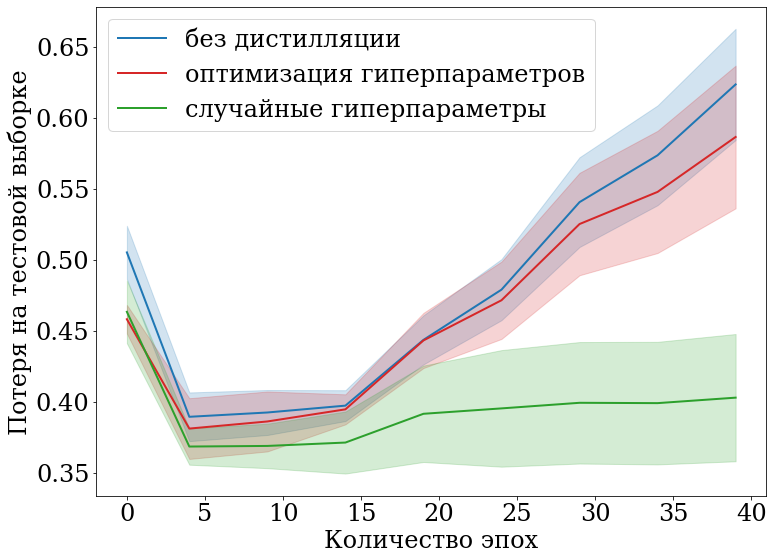

In [7]:
plot_data_params(data_b, 'test loss', 'без дистилляции', 'tab:blue', '')
#plot_data_params(data_d, 'test loss', 'оптимальные гипепараметры', 'tab:orange', '')
plot_data_params(data_dr, 'test loss', 'оптимизация гиперпараметров', 'tab:red', '')
plot_data_params(data_h, 'test loss', 'случайные гиперпараметры', 'tab:green', '')

plt.xlabel('Количество эпох')
plt.ylabel('Потеря на тестовой выборке')

plt.legend()
plt.savefig('../figs/loss_22.pdf')

In [8]:
[h['results'][-1] for h in data_h], 


([{'epoch': 39,
   'test loss': 0.38997700810432434,
   'val loss': 0.36324217915534973,
   'accuracy': 0.88919997215271,
   'temp': 9.51207160949707,
   'lambda1': 0.9976252913475037},
  {'epoch': 39,
   'test loss': 0.33168190717697144,
   'val loss': 0.31091493368148804,
   'accuracy': 0.8854999542236328,
   'temp': 6.026719093322754,
   'lambda1': 0.9990113973617554},
  {'epoch': 39,
   'test loss': 0.45246008038520813,
   'val loss': 0.42251652479171753,
   'accuracy': 0.8842999935150146,
   'temp': 1.644345760345459,
   'lambda1': 0.975446879863739},
  {'epoch': 39,
   'test loss': 0.4484977722167969,
   'val loss': 0.41780346632003784,
   'accuracy': 0.8787999749183655,
   'temp': 8.67514419555664,
   'lambda1': 0.9678934812545776},
  {'epoch': 39,
   'test loss': 0.36023807525634766,
   'val loss': 0.3295688331127167,
   'accuracy': 0.8883999586105347,
   'temp': 7.109918594360352,
   'lambda1': 0.9966252446174622},
  {'epoch': 39,
   'test loss': 0.4432668089866638,
   'val lo

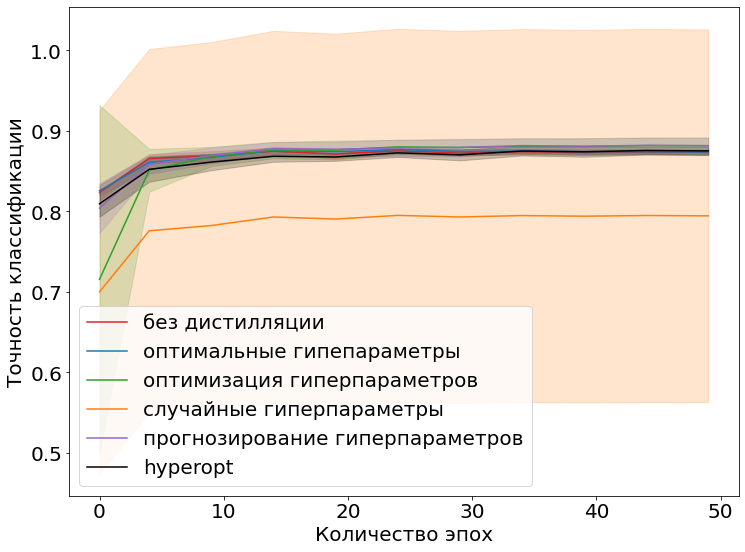

In [11]:
plot_data_params(data_b, 'accuracy', 'без дистилляции', 'tab:red', '')
plot_data_params(data_d, 'accuracy', 'оптимальные гипепараметры', 'tab:blue', '')
plot_data_params(data_h, 'accuracy', 'оптимизация гиперпараметров', 'tab:green', '')
plot_data_params(data_dr, 'accuracy', 'случайные гиперпараметры', 'tab:orange', '')
plot_data_params(data_s, 'accuracy', 'прогнозирование гиперпараметров', 'tab:purple', '')
plot_data_params(data_ho, 'accuracy', 'hyperopt', 'black', '')

plt.xlabel('Количество эпох')
plt.ylabel('Точность классификации')
plt.legend()
plt.savefig('../figs/acc_22.pdf')

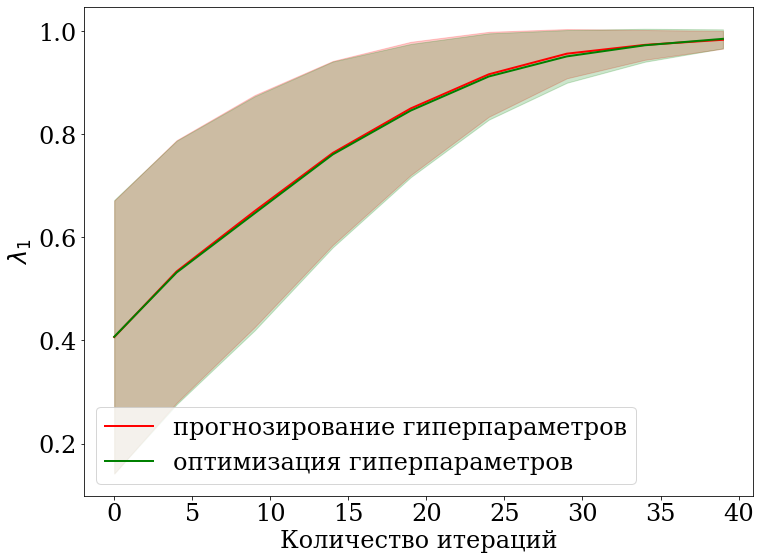

In [20]:
plot_data_params(data_s, 'lambda1', 'прогнозирование гиперпараметров', 'red', '')
# plot_data_params(data_dr, 'lambda1', 'случайные гиперпараметров', 'blue', '')
plot_data_params(data_h, 'lambda1', 'оптимизация гиперпараметров', 'green', '')
plt.xlabel('Количество итераций')
plt.ylabel(r'$\lambda_1$')
# plt.title(r'График зависимости значения $\lambda_1$ от номера итерации')
plt.legend()
plt.savefig('../figs/lambda1_iter22.pdf')
plt.show()

In [21]:
plot_data_params(data_s, 'lambda2', 'прогнозирование гиперпараметров', 'red', '')
# plot_data_params(data_dr, 'lambda2', 'случайные гиперпараметров', 'blue', '')
plot_data_params(data_h, 'lambda2', 'оптимизация гиперпараметров', 'green', '')
plt.xlabel('Количество итераций')
plt.ylabel(r'$\lambda_2$')
# plt.title(r'График зависимости значения $\lambda_2$ от номера итерации')
plt.legend()
plt.savefig('../figs/lambda2_iter22.pdf')
plt.show()

KeyError: 'lambda2'

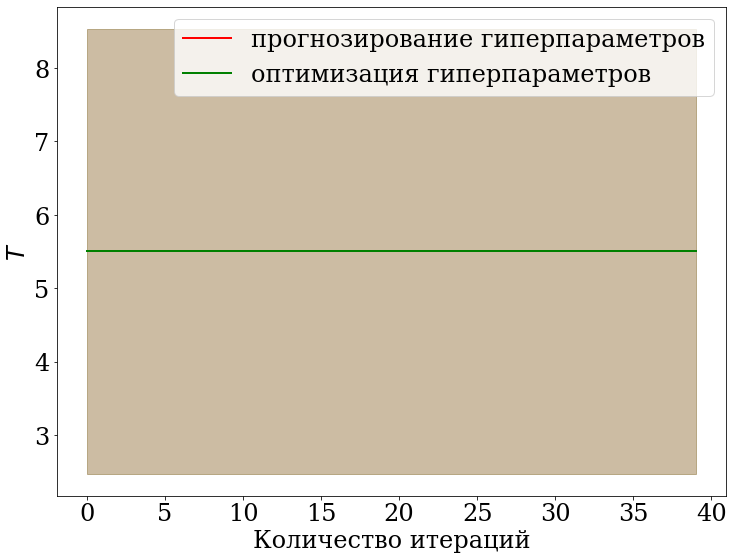

In [22]:
plot_data_params(data_s, 'temp', 'прогнозирование гиперпараметров', 'red', '')
#plot_data_params(data_dr, 'temp', 'случайные гиперпараметров', 'blue', '')
plot_data_params(data_h, 'temp', 'оптимизация гиперпараметров', 'green', '')
plt.xlabel('Количество итераций')
plt.ylabel(r'$T$')
# plt.title(r'График зависимости значения $T$ от номера итерации')
plt.legend()
plt.savefig('../figs/temp_iter22.pdf')
plt.show()

In [22]:
data_5 = open_data_json("../log/exp11_dist_h_b2_optim.jsonl")
data_2 = open_data_json("../log/exp12_dist_h_b2_optim.jsonl")
data_3 = open_data_json("../log/exp13_dist_h_b2_optim.jsonl")
data_10 = open_data_json("../log/exp14_dist_h_b2_optim.jsonl")

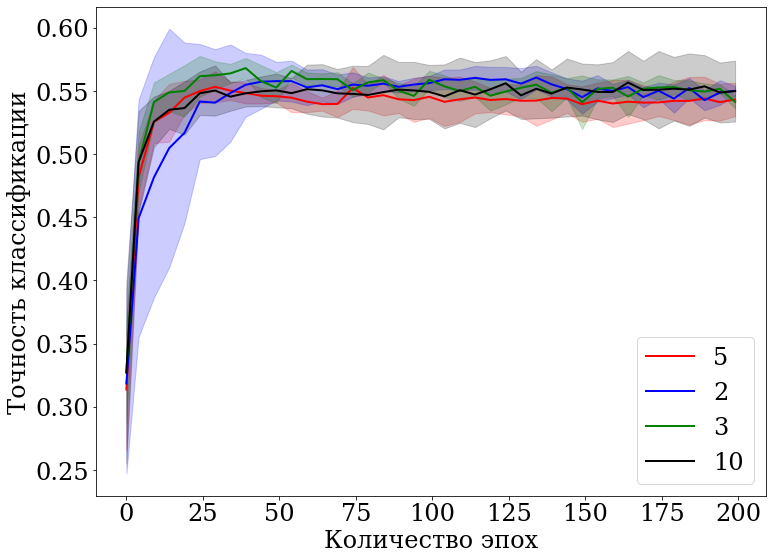

In [7]:
plot_data(data_5, '5', 'red')
plot_data(data_2, '2', 'blue')
plot_data(data_3, '3', 'green')
plot_data(data_10, '10', 'black')

plt.xlabel('Количество эпох')
plt.ylabel('Точность классификации')
plt.legend()
plt.savefig('../figs/acc_splines_.pdf')

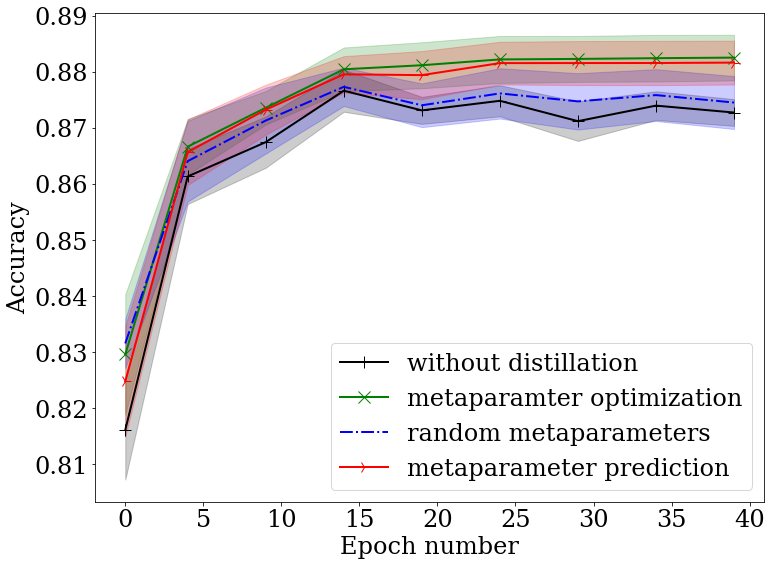

In [23]:
plot_data_params(data_b, 'accuracy', 'without distillation', 'black', '+')
plot_data_params(data_h, 'accuracy', 'metaparamter optimization', 'green', 'x')
plot_data_params(data_dr, 'accuracy', 'random metaparameters', 'blue', '.')
plot_data_params(data_s, 'accuracy', 'metaparameter prediction', 'red', '4')

plt.xlabel('Epoch number')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('../figs/acc_'+experiment_version+'_eng.pdf')

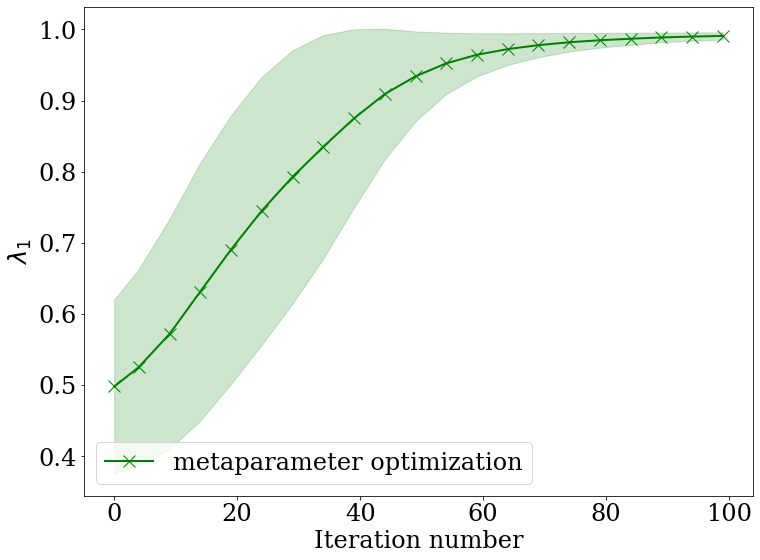

In [27]:
#plot_data_params(data_s, 'lambda1', 'metaparameter prediction', 'red', '+')
plot_data_params(data_h, 'lambda1', 'metaparameter optimization', 'green', 'x')
plt.xlabel('Iteration number')
plt.ylabel(r'$\lambda_1$')
plt.legend()
plt.savefig('../figs/lambda1_iter'+experiment_version+'_eng.pdf')
plt.show()

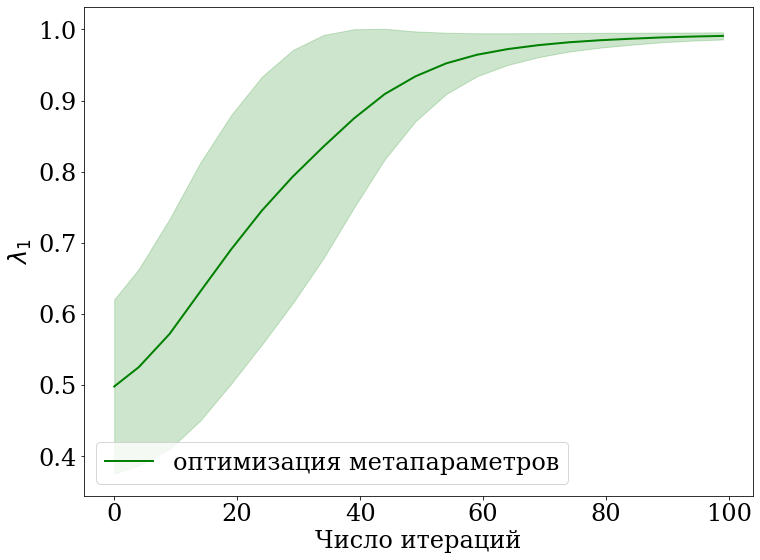

In [28]:
#plot_data_params(data_s, 'lambda1', 'прогнозирование метапараметров', 'red', '')
plot_data_params(data_h, 'lambda1', 'оптимизация метапараметров', 'green', '')
plt.xlabel('Число итераций')
plt.ylabel(r'$\lambda_1$')

plt.legend()
plt.savefig('../figs/lambda1_iter'+experiment_version+'_color.pdf')
plt.show()

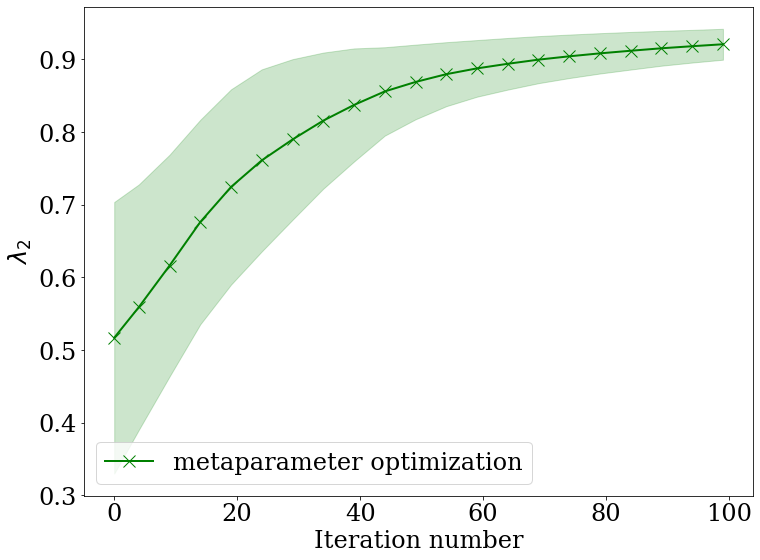

In [29]:
#plot_data_params(data_s, 'lambda2', 'metaparameter prediction', 'red', '+')
plot_data_params(data_h, 'lambda2', 'metaparameter optimization', 'green', 'x')
plt.xlabel('Iteration number')
plt.ylabel(r'$\lambda_2$')
plt.legend()
plt.savefig('../figs/lambda2_iter'+experiment_version+'_eng.pdf')
plt.show()

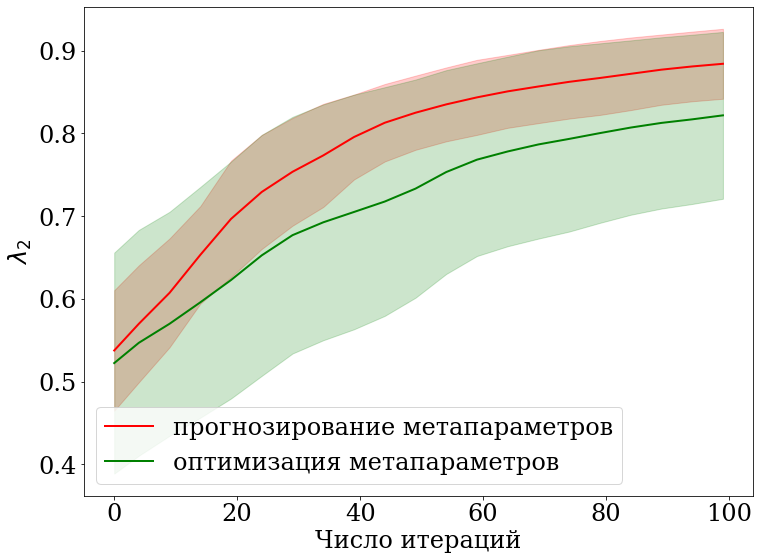

In [16]:
plot_data_params(data_s, 'lambda2', 'прогнозирование метапараметров', 'red', '')
plot_data_params(data_h, 'lambda2', 'оптимизация метапараметров', 'green', '')
plt.xlabel('Число итераций')
plt.ylabel(r'$\lambda_2$')
plt.legend()
plt.savefig('../figs/lambda2_iter'+experiment_version+'_color.pdf')
plt.show()

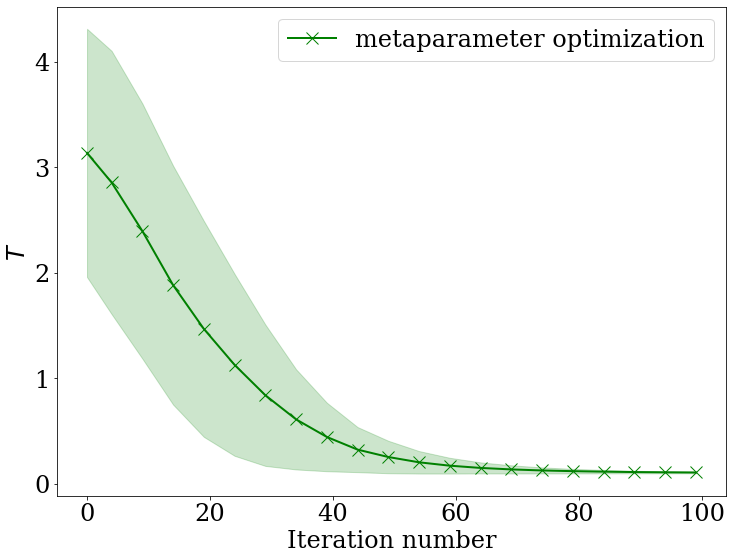

In [30]:
#plot_data_params(data_s, 'temp', 'metaparameter prediction', 'red', '+')
plot_data_params(data_h, 'temp', 'metaparameter optimization', 'green', 'x')
plt.xlabel('Iteration number')
plt.ylabel(r'$T$')
plt.legend()
plt.savefig('../figs/temp_iter'+experiment_version+'_eng.pdf')
plt.show()

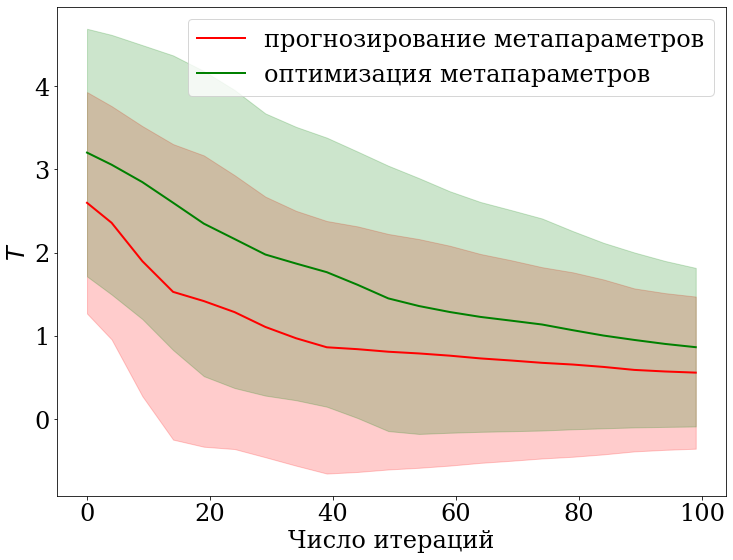

In [18]:
plot_data_params(data_s, 'temp', 'прогнозирование метапараметров', 'red', '')
plot_data_params(data_h, 'temp', 'оптимизация метапараметров', 'green', '')
plt.xlabel('Число итераций')
plt.ylabel(r'$T$')
plt.legend()
plt.savefig('../figs/temp_iter'+experiment_version+'_color.pdf')
plt.show()